In [2]:
%load_ext autoreload
%autoreload 2

# Modeling

In this notebook, we'll capitalize on the learnings derived from the EDA step. This is an interative steps as modeling will improve overtime. The problem we are trying to solve here is defined as  *predict the number of bicycles available at Bixi's stations every 15 minutes for the next 7 days within the city of Montreal*

## Baseline
Before jumping into a machine learning approach, let's first create a baseline which will be used to compare the results with. The idea is to take the baseline and create a functional end-to-end machine learning pipeline. 

With that step completed, we can now proceed with more complex solutions in order to ameliorate the results and justify the added complexity.

The metric used will be *MAE* (Mean Average Error) which will allow us to measure the number of bikes interval error. As a performance threshold, **we'll aim to obtain an MAE of maximum 4 for 80 % of the stations**.

The following article was used as a basis for the modeling step of the project: 
https://cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn

## Modeling

In [87]:
from pandas import read_csv, DataFrame, to_datetime, concat, set_option, DateOffset, pivot_table, Series
from typing import List
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from multiprocessing import Pool, cpu_count
import os
from numpy import mean, asarray, percentile, nanpercentile

from utils import standarize_station_name
from bixi_availability_prediction.etl import get_stations_capacity
from constants import STATION_CAPACITY_URL

import seaborn as sns
import matplotlib.pyplot as plt

from skforecast.recursive import ForecasterEquivalentDate, ForecasterRecursiveMultiSeries
from skforecast.model_selection import TimeSeriesFold, backtesting_forecaster_multiseries, backtesting_forecaster

from skforecast.preprocessing import series_long_to_dict
from functools import reduce

In [88]:
set_option('display.max_rows', 1500)
set_option('display.max_columns', 50)

## Utils functions to load and transform the raw data

In [89]:
def load_and_transform_availability_data(path: str)-> DataFrame:
    """
    Concatanaing all raw data into a single dataframe.
    """

    files_list = []
    for root, dirs, files in os.walk(f"{path}/"):
        for file in files:
            if file.endswith(".csv"):
                 files_list.append(os.path.join(root, file))

    df = (
        concat([read_csv(x) for x in files_list])
        .assign(datetime=lambda x: to_datetime(x['commit_at']).dt.tz_localize(None))
        .drop(['commit_at'], axis=1)
    )
    
    return df

In [90]:
def resample_data_per_time_interval(raw_data: DataFrame, timewindow: str) -> DataFrame:
    """
    Resample data by station and specific time window
    """

    df = (
        raw_data
        .groupby('station')
        .resample(
            rule='15min',
            on='datetime'
        ).max()
        .drop(columns='station')
        .groupby('station').shift(1)
        .groupby('station').ffill()
        .dropna(subset=['skipped_updates'])
        [['bikes', 'stands']].astype('uint8')
    )

    return df

In [91]:
# multiprocessing or equivalent needs to speed up the resampling step
def _resample_station_data(station_data: DataFrame, timewindow: str) -> DataFrame:
    """
    Helper function to process data for a single station.
    """
    station_name = station_data['station'].iloc[0]
    
    df = (
        station_data
        .set_index('datetime') 
        .resample(timewindow)
        .max()
        .shift(1)
        .ffill()
        .dropna(subset=['skipped_updates'])
        [['bikes', 'stands']]
        .astype('uint8')
        .assign(station=station_name)
    )
    
    return df

def resample_data_per_time_window(raw_data: DataFrame, timewindow: str) -> DataFrame:
    """
    Resample data by station and specific time window using multiprocessing.
    """

    grouped = raw_data.groupby('station')
    station_dfs = [group for _, group in grouped]

    with Pool(processes=cpu_count()) as pool:
        results = pool.starmap(_resample_station_data, [(df, timewindow) for df in station_dfs])

    final_df = concat(results).reset_index()

    return final_df

In [92]:
def create_lags(lags: List[int],  df: DataFrame, column: str='bikes') -> DataFrame:
    """
    Creates the lags based on the list and column name provided
    """
    lags_columns = {
        f'{column}_lag_{n}' : resampled_df.groupby(['station'])[f'{column}'].transform(lambda x: x.shift(n))
        for n in lags
    }

    return df.assign(**lags_columns)

In [93]:
def create_targets(targets: List[int],  df: DataFrame, column: str='bikes') -> DataFrame:
    """
    Creates the targets based on the list and column name provided
    """
    target_columns = {
        f'{column}_target_{n}' : resampled_df.groupby(['station'])[f'{column}'].transform(lambda x: x.shift(-n))
        for n in targets
    }

    return df.assign(**target_columns)

## Baseline

Before dwelling on a more sophisticated solution, a baseline will be first constructed and evaluated. Once the baseline is finished, an end-to-end pipeline will be subsequently developed. The benefits of this approach are obvious as it allows for the design and implementation of a simpler solution which will then be complexified iteratively as needed. Below, the baseline candidates are listed:
- Number of available bikes for the previous week for the same time *t* and station (recursive and direct)


In [94]:
# loading raw data
# and standarizing station name
df = load_and_transform_availability_data('raw_data')
df['station'] = standarize_station_name(df['station'])

In [95]:
# first let's aggregate our by every 15 minutes
resampled_df = resample_data_per_time_window(df, '15min')

In [96]:
# importining station capacity and cleaning station name
stations_capacity = get_stations_capacity(STATION_CAPACITY_URL)
stations_capacity['station'] = standarize_station_name(stations_capacity['station_name'])

- Let's now visualize the median number of bikes per station in order to have a better understading of the data. 

- However, certain stations are deactivated during the winter time and, given we are writing this notebook duruing the month of february, we'll only consider stations that are currently operating within the city of montreal

In [97]:
operating_stations = resampled_df.merge(stations_capacity['station'], how='inner', on='station')

In [98]:
operating_stations

,datetime,bikes,stands,station
0,2024-08-22 15:00:00,13,11,15eavenue_laurier
1,2024-08-22 15:15:00,11,13,15eavenue_laurier
2,2024-08-22 15:30:00,13,11,15eavenue_laurier
3,2024-08-22 15:45:00,12,12,15eavenue_laurier
4,2024-08-22 16:00:00,10,14,15eavenue_laurier
...,...,...,...,...
3436982,2025-02-24 11:00:00,9,14,workman_vinet
3436983,2025-02-24 11:15:00,9,14,workman_vinet
3436984,2025-02-24 11:30:00,9,14,workman_vinet
3436985,2025-02-24 11:45:00,9,14,workman_vinet


In [15]:
print(f'Number of stations during spring/summer time: {len(resampled_df["station"].unique())}')
print(f'Number of stations during winter time: {len(operating_stations["station"].unique())}')

Number of stations during spring/summer time: 984
Number of stations during winter time: 204


<Axes: xlabel='datetime'>

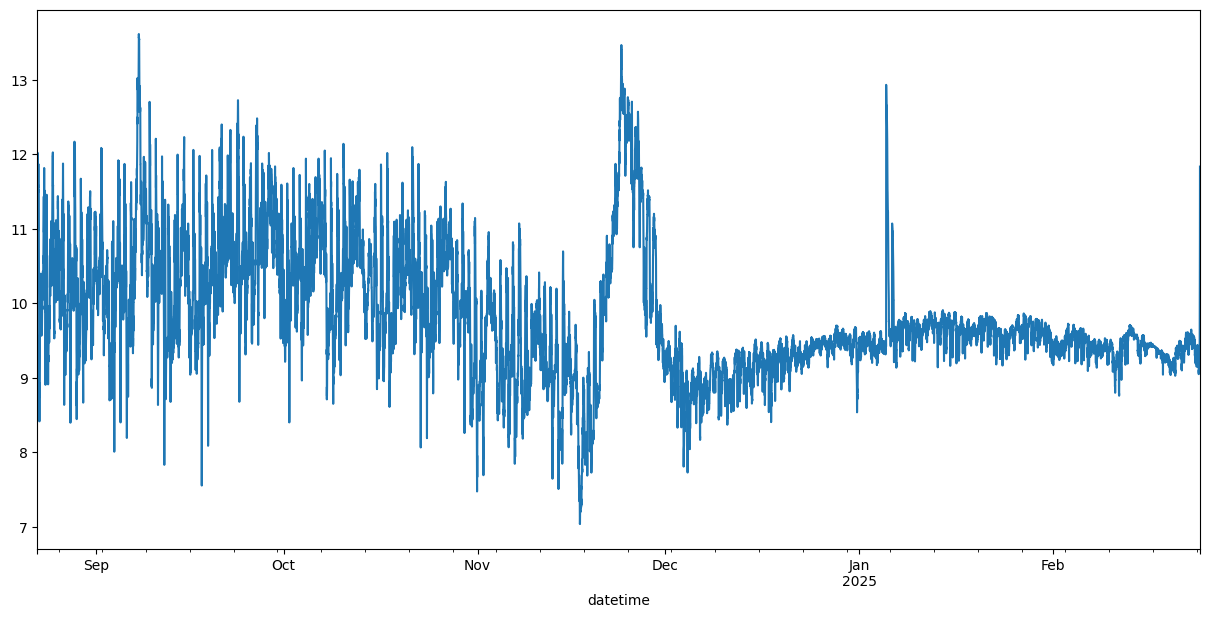

In [16]:
operating_stations.groupby(['datetime'])['bikes'].mean().plot(x='datetime', y='bikes', figsize=(15,7))

- Based on the above chart, we'll use Aug to Dec 31 as train and Jan 1 onwards as testing

In [17]:
operating_stations.head()

,datetime,bikes,stands,station
0,2024-08-22 15:00:00,13,11,15eavenue_laurier
1,2024-08-22 15:15:00,11,13,15eavenue_laurier
2,2024-08-22 15:30:00,13,11,15eavenue_laurier
3,2024-08-22 15:45:00,12,12,15eavenue_laurier
4,2024-08-22 16:00:00,10,14,15eavenue_laurier


In [18]:
# pivoting dataframe to fit the global to fit
# the global multi-sries
global_time_series = operating_stations.pivot_table(
    values='bikes',
    columns='station',
    index='datetime'
)

global_time_series = global_time_series.asfreq('15T')

stations = operating_stations['station'].drop_duplicates().to_list()

/tmp/ipykernel_2341/3759195527.py:9: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  global_time_series = global_time_series.asfreq('15T')


In [19]:
end_training = '2025-01-01 00:00:00'
train = global_time_series[global_time_series.index < end_training]
test = global_time_series[global_time_series.index >= end_training]

baseline_testing = '

In [69]:
def _backtest_baseline_forecasting_by_station(station_hist_data: DataFrame):
    """
    Evaluate the predictions of the baseline forecastor for each individual station
    """
    station_name = station_hist_data.name
    print(f"Forecasting bike availability for station {station_name}")

    forecaster = ForecasterEquivalentDate(
        offset=DateOffset(days=7),   
        n_offsets=1,
    )

    # initialize values in case of excpetion
    predictions = None
    metric = None
    
    try:
        cv = TimeSeriesFold(
             steps              = (7*4*24),
             initial_train_size = (7*4*24)+1, # one full week of initial training
             refit              = True
         )
    
        metric, predictions = backtesting_forecaster(
                              forecaster = forecaster,
                              y          = station_hist_data.dropna(),
                              cv         = cv,
                              metric     = 'mean_absolute_error',
                              verbose       = True,
                              show_progress = True 
                          )
        
        return {station_name : (predictions, metric)}

    except ValueError as e:
        print(f'Exception found for station {station}. See details below: \n {e}')
        pass

def backtest_baseline_forecasting(historical_data: DataFrame):
    """
    Backtest the predictions of the baseline forecastor for multiple stations using multiprocessing
    """
    stations = historical_data.columns
    station_series = [(historical_data[station],) for station in stations]

    with Pool(processes=cpu_count()) as pool:
        results = pool.starmap(_backtest_baseline_forecasting_by_station, station_series)
    
    return reduce(lambda x, y: {**x, **y}, results)
    

In [70]:
results_list = backtest_baseline_forecasting(global_time_series)

Forecasting bike availability for station 15eavenue_laurier
Forecasting bike availability for station 3eavenue_wellington
Forecasting bike availability for station atwater_greeneInformation of folds

Information of folds--------------------

--------------------Number of observations used for initial training: 673Forecasting bike availability for station beaubien_8eavenue

Number of observations used for backtesting: 17138Number of observations used for initial training: 673

Information of folds
Number of observations used for backtesting: 14489
    Number of folds: 26
--------------------
    Number of folds: 22
    Number skipped folds: 0 Forecasting bike availability for station berri_rachel

Number of observations used for initial training: 673
    Number skipped folds: 0 
    Number of steps per fold: 672
Information of foldsNumber of observations used for backtesting: 17109
    Number of steps per fold: 672

    Number of steps to exclude between last observed data (last window)

  0%|          | 0/5 [00:00<?, ?it/s]





Fold: 6

    Training:   2024-10-10 15:00:00 -- 2024-10-17 15:00:00  (n=673)    Validation: 2024-10-24 15:15:00 -- 2024-10-31 15:00:00  (n=672)
Fold: 4


Fold: 4    Training:   2024-12-05 15:00:00 -- 2024-12-12 15:00:00  (n=673)Fold: 10Fold: 14
Fold: 16
Fold: 5
    Validation: 2024-12-12 14:45:00 -- 2024-12-19 14:30:00  (n=672)    Training:   2024-10-03 15:00:00 -- 2024-10-10 15:00:00  (n=673)    Validation: 2024-11-14 15:15:00 -- 2024-11-21 15:00:00  (n=672)


Fold: 12    Training:   2024-11-27 20:15:00 -- 2024-12-04 20:15:00  (n=673)

    Training:   2024-10-03 15:00:00 -- 2024-10-10 15:00:00  (n=673)    Training:   2024-10-16 13:00:00 -- 2024-10-23 13:00:00  (n=673)
    Validation: 2024-10-17 15:15:00 -- 2024-10-24 15:00:00  (n=672)Fold: 9    Training:   2024-10-31 15:00:00 -- 2024-11-07 15:00:00  (n=673)



    Validation: 2024-12-12 15:15:00 -- 2024-12-19 15:00:00  (n=672)
    Training:   2025-01-09 13:15:00 -- 2025-01-16 13:15:00  (n=673)    Training:   2024-11-12 11:45:00 --

  0%|          | 0/22 [00:00<?, ?it/s]

    Training:   2024-12-05 15:00:00 -- 2024-12-12 15:00:00  (n=673)
Fold: 13
Fold: 23    Validation: 2025-02-13 14:45:00 -- 2025-02-20 14:30:00  (n=672)



Fold: 19    Validation: 2025-02-13 15:15:00 -- 2025-02-20 15:00:00  (n=672)


    Validation: 2025-01-14 12:00:00 -- 2025-01-21 11:45:00  (n=672)
    Training:   2025-01-09 15:00:00 -- 2025-01-16 15:00:00  (n=673)
Fold: 16    Validation: 2025-01-02 15:15:00 -- 2025-01-09 15:00:00  (n=672)
    Validation: 2025-02-05 20:30:00 -- 2025-02-12 20:15:00  (n=672)

    Validation: 2024-12-19 15:15:00 -- 2024-12-26 15:00:00  (n=672)    Validation: 2024-12-25 18:45:00 -- 2025-01-01 18:30:00  (n=672)
    Training:   2024-12-18 13:00:00 -- 2024-12-25 13:00:00  (n=673)
    Training:   2025-01-30 15:00:00 -- 2025-02-06 15:00:00  (n=673)

    Validation: 2024-12-12 15:15:00 -- 2024-12-19 15:00:00  (n=672)    Validation: 2025-01-23 15:15:00 -- 2025-01-30 15:00:00  (n=672)
    Training:   2025-01-02 15:00:00 -- 2025-01-09 15:00:00  (n=673)Fold: 25Fol

  0%|          | 0/26 [00:00<?, ?it/s]




    Validation: 2025-02-06 15:15:00 -- 2025-02-13 15:00:00  (n=672)


    Validation: 2025-01-22 13:15:00 -- 2025-01-29 13:00:00  (n=672)
    Validation: 2025-01-22 18:45:00 -- 2025-01-29 18:30:00  (n=672)    Training:   2025-01-09 15:00:00 -- 2025-01-16 15:00:00  (n=673)    Training:   2025-01-09 15:00:00 -- 2025-01-16 15:00:00  (n=673)    Validation: 2025-02-18 12:00:00 -- 2025-02-24 11:15:00  (n=574)    Validation: 2025-02-13 15:15:00 -- 2025-02-20 15:00:00  (n=672)Fold: 20

  0%|          | 0/23 [00:00<?, ?it/s]





    Validation: 2025-02-20 15:15:00 -- 2025-02-24 12:15:00  (n=373)
Fold: 18
    Validation: 2025-01-16 15:15:00 -- 2025-01-23 15:00:00  (n=672)Fold: 18Fold: 25    Validation: 2025-01-16 15:15:00 -- 2025-01-23 15:00:00  (n=672)



    Training:   2025-01-09 15:00:00 -- 2025-01-16 15:00:00  (n=673)


    Training:   2025-01-22 13:00:00 -- 2025-01-29 13:00:00  (n=673)
    Training:   2025-01-23 15:00:00 -- 2025-01-30 15:00:00  (n=673)
    Training:   2025-01-22 18:30:00 -- 2025-01-29 18:30:00  (n=673)Fold: 21    Training:   2025-02-13 15:00:00 -- 2025-02-20 15:00:00  (n=673)
    Validation: 2025-01-16 15:15:00 -- 2025-01-23 15:00:00  (n=672)





  0%|          | 0/17 [00:00<?, ?it/s]

    Validation: 2025-01-29 18:45:00 -- 2025-02-05 18:30:00  (n=672)    Validation: 2025-02-20 15:15:00 -- 2025-02-23 20:00:00  (n=308)
Fold: 21    Training:   2025-01-16 15:00:00 -- 2025-01-23 15:00:00  (n=673)


Fold: 24    Validation: 2025-01-30 15:15:00 -- 2025-02-06 15:00:00  (n=672)

Fold: 19
    Training:   2025-01-16 15:00:00 -- 2025-01-23 15:00:00  (n=673)
    Validation: 2025-01-23 15:15:00 -- 2025-01-30 15:00:00  (n=672)
Fold: 21    Training:   2025-02-06 15:00:00 -- 2025-02-13 15:00:00  (n=673)


    Validation: 2025-01-23 15:15:00 -- 2025-01-30 15:00:00  (n=672)Fold: 23    Training:   2025-01-16 15:00:00 -- 2025-01-23 15:00:00  (n=673)    Validation: 2025-02-13 15:15:00 -- 2025-02-20 15:00:00  (n=672)



    Training:   2025-01-30 15:00:00 -- 2025-02-06 15:00:00  (n=673)
    Validation: 2025-01-23 15:15:00 -- 2025-01-30 15:00:00  (n=672)Fold: 25Fold: 22

  0%|          | 0/26 [00:00<?, ?it/s]



    Validation: 2025-02-06 15:15:00 -- 2025-02-13 15:00:00  (n=672)
    Training:   2025-02-13 15:00:00 -- 2025-02-20 15:00:00  (n=673)    Training:   2025-01-23 15:00:00 -- 2025-01-30 15:00:00  (n=673)Fold: 22



    Validation: 2025-01-29 13:15:00 -- 2025-02-05 13:00:00  (n=672)Fold: 24Fold: 22
    Validation: 2025-02-20 15:15:00 -- 2025-02-24 12:00:00  (n=372)    Validation: 2025-01-30 15:15:00 -- 2025-02-06 15:00:00  (n=672)



    Training:   2025-01-23 15:00:00 -- 2025-01-30 15:00:00  (n=673)    Training:   2025-02-06 15:00:00 -- 2025-02-13 15:00:00  (n=673)Fold: 23    Training:   2025-01-23 15:00:00 -- 2025-01-30 15:00:00  (n=673)



    Validation: 2025-01-30 15:15:00 -- 2025-02-06 15:00:00  (n=672)    Training:   2025-01-30 15:00:00 -- 2025-02-06 15:00:00  (n=673)    Validation: 2025-01-30 15:15:00 -- 2025-02-06 15:00:00  (n=672)


Fold: 23    Validation: 2025-02-06 15:15:00 -- 2025-02-13 15:00:00  (n=672)Fold: 23

    Training:   2025-01-29 18:30:00 -- 2025-02-05 18:30:00  

  0%|          | 0/26 [00:00<?, ?it/s]

    Validation: 2025-02-13 15:15:00 -- 2025-02-20 15:00:00  (n=672)    Validation: 2025-02-05 13:15:00 -- 2025-02-12 13:00:00  (n=672)


    Validation: 2025-02-06 15:15:00 -- 2025-02-13 15:00:00  (n=672)Fold: 25Fold: 20
    Validation: 2025-02-05 18:45:00 -- 2025-02-12 18:30:00  (n=672)

    Training:   2025-02-13 15:00:00 -- 2025-02-20 15:00:00  (n=673)
Fold: 24
Fold: 20    Training:   2025-02-05 13:00:00 -- 2025-02-12 13:00:00  (n=673)
    Validation: 2025-02-20 15:15:00 -- 2025-02-23 23:15:00  (n=321)

    Training:   2025-02-06 15:00:00 -- 2025-02-13 15:00:00  (n=673)

    Training:   2025-02-05 18:30:00 -- 2025-02-12 18:30:00  (n=673)    Validation: 2025-02-12 13:15:00 -- 2025-02-19 13:00:00  (n=672)

    Validation: 2025-02-13 15:15:00 -- 2025-02-20 15:00:00  (n=672)

    Validation: 2025-02-12 18:45:00 -- 2025-02-19 18:30:00  (n=672)Fold: 25
Fold: 21




  0%|          | 0/18 [00:00<?, ?it/s]

    Training:   2025-02-13 15:00:00 -- 2025-02-20 15:00:00  (n=673)Fold: 25    Training:   2025-02-12 18:30:00 -- 2025-02-19 18:30:00  (n=673)


Fold: 25    Training:   2025-02-13 15:00:00 -- 2025-02-20 15:00:00  (n=673)



  0%|          | 0/26 [00:00<?, ?it/s]


    Training:   2025-02-13 15:00:00 -- 2025-02-20 15:00:00  (n=673)    Validation: 2025-02-19 18:45:00 -- 2025-02-24 11:15:00  (n=451)    Validation: 2025-02-20 15:15:00 -- 2025-02-24 01:30:00  (n=330)Fold: 21


    Training:   2025-02-12 13:00:00 -- 2025-02-19 13:00:00  (n=673)

  0%|          | 0/26 [00:00<?, ?it/s]

    Validation: 2025-02-20 15:15:00 -- 2025-02-24 05:00:00  (n=344)

    Validation: 2025-02-20 15:15:00 -- 2025-02-24 12:15:00  (n=373)





    Validation: 2025-02-19 13:15:00 -- 2025-02-24 11:45:00  (n=475)



  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Forecasting bike availability for station del'htel-de-ville_rachel
Information of folds
--------------------
Number of observations used for initial training: 673
Number of observations used for backtesting: 17173
    Number of folds: 26
    Number skipped folds: 0 
    Number of steps per fold: 672
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 373 observations.

Fold: 0
    Training:   2024-08-22 15:00:00 -- 2024-08-29 15:00:00  (n=673)
    Validation: 2024-08-29 15:15:00 -- 2024-09-05 15:00:00  (n=672)
Fold: 1
    Training:   2024-08-29 15:00:00 -- 2024-09-05 15:00:00  (n=673)
    Validation: 2024-09-05 15:15:00 -- 2024-09-12 15:00:00  (n=672)
Fold: 2
    Training:   2024-09-05 15:00:00 -- 2024-09-12 15:00:00  (n=673)
    Validation: 2024-09-12 15:15:00 -- 2024-09-19 15:00:00  (n=672)
Fold: 3
    Training:   2024-09-12 15:00:00 -- 2024-09-19 15:00:00  (n=673)
    Validation: 2024-09-19 15:15:00 -- 2024-09-

  0%|          | 0/26 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Fold: 4    Validation: 2024-12-12 15:15:00 -- 2024-12-19 15:00:00  (n=672)

Fold: 16
    Training:   2024-10-10 15:30:00 -- 2024-10-17 15:30:00  (n=673)    Training:   2024-12-12 15:00:00 -- 2024-12-19 15:00:00  (n=673)
    Validation: 2024-12-19 15:15:00 -- 2024-12-26 15:00:00  (n=672)

Fold: 17    Validation: 2024-10-17 15:45:00 -- 2024-10-24 15:30:00  (n=672)

Fold: 5    Training:   2024-12-19 15:00:00 -- 2024-12-26 15:00:00  (n=673)
    Validation: 2024-12-26 15:15:00 -- 2025-01-02 15:00:00  (n=672)
Fold: 18
    Training:   2024-12-26 15:00:00 -- 2025-01-02 15:00:00  (n=673)

    Validation: 2025-01-02 15:15:00 -- 2025-01-09 15:00:00  (n=672)    Training:   2024-10-17 15:30:00 -- 2024-10-24 15:30:00  (n=673)

Fold: 19    Validation: 2024-10-24 15:45:00 -- 2024-10-31 15:30:00  (n=672)
    Training:   2025-01-02 15:00:00 -- 2025-01-09 15:00:00  (n=673)

Fold: 6    Validation: 2025-01-09 15:15:00 -- 2025-01-16 15:00:00  (n=672)
Fold: 20
    Training:   2025-01-09 15:00:00 -- 2025-01-1

  0%|          | 0/26 [00:00<?, ?it/s]

    Training:   2024-12-12 15:30:00 -- 2024-12-19 15:30:00  (n=673)

    Validation: 2024-12-19 15:45:00 -- 2024-12-26 15:30:00  (n=672)    Number of steps per fold: 672
Fold: 14

    Training:   2024-12-19 15:30:00 -- 2024-12-26 15:30:00  (n=673)
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0    Validation: 2024-12-26 15:45:00 -- 2025-01-02 15:30:00  (n=672)
    Last fold only includes 334 observations.
Fold: 15


Fold: 0    Training:   2024-12-26 15:30:00 -- 2025-01-02 15:30:00  (n=673)

    Validation: 2025-01-02 15:45:00 -- 2025-01-09 15:30:00  (n=672)
    Training:   2024-08-22 15:00:00 -- 2024-08-29 15:00:00  (n=673)
    Validation: 2024-08-29 15:15:00 -- 2024-09-05 15:00:00  (n=672)
Fold: 1Fold: 16

    Training:   2025-01-02 15:30:00 -- 2025-01-09 15:30:00  (n=673)
    Validation: 2025-01-09 15:45:00 -- 2025-01-16 15:30:00  (n=672)
Fold: 17
    Training:   2025-01-09 15:30:00 -- 2025-01-16 15:30:00  (n=673)
    Validation: 2025-

  0%|          | 0/23 [00:00<?, ?it/s]

    Training:   2024-11-14 15:00:00 -- 2024-11-21 15:00:00  (n=673)
    Validation: 2024-11-21 15:15:00 -- 2024-11-28 15:00:00  (n=672)
Fold: 13
    Training:   2024-11-21 15:00:00 -- 2024-11-28 15:00:00  (n=673)
    Validation: 2024-11-28 15:15:00 -- 2024-12-05 15:00:00  (n=672)
Fold: 14
    Training:   2024-11-28 15:00:00 -- 2024-12-05 15:00:00  (n=673)
    Validation: 2024-12-05 15:15:00 -- 2024-12-12 15:00:00  (n=672)
Fold: 15
    Training:   2024-12-05 15:00:00 -- 2024-12-12 15:00:00  (n=673)
    Validation: 2024-12-12 15:15:00 -- 2024-12-19 15:00:00  (n=672)Forecasting bike availability for station desbarges_desbassins
Information of folds
--------------------
Fold: 16
Number of observations used for initial training: 673
Number of observations used for backtesting: 11769

Forecasting bike availability for station chsldrobertcliche(debellechasse_16eavenue)
Information of folds
--------------------    Training:   2024-12-12 15:00:00 -- 2024-12-19 15:00:00  (n=673)
Number of observ

  0%|          | 0/26 [00:00<?, ?it/s]

    Validation: 2024-11-14 15:30:00 -- 2024-11-21 15:15:00  (n=672)    Validation: 2024-11-07 15:15:00 -- 2024-11-14 15:00:00  (n=672)    Training:   2024-12-26 13:00:00 -- 2025-01-02 13:00:00  (n=673)

Fold: 12Fold: 11

    Training:   2024-11-14 15:15:00 -- 2024-11-21 15:15:00  (n=673)    Training:   2024-11-07 15:00:00 -- 2024-11-14 15:00:00  (n=673)
    Validation: 2024-11-14 15:15:00 -- 2024-11-21 15:00:00  (n=672)

Fold: 12
    Validation: 2024-11-21 15:30:00 -- 2024-11-28 15:15:00  (n=672)    Training:   2024-11-14 15:00:00 -- 2024-11-21 15:00:00  (n=673)
Fold: 13

    Validation: 2024-11-21 15:15:00 -- 2024-11-28 15:00:00  (n=672)

Fold: 13
    Training:   2024-11-21 15:00:00 -- 2024-11-28 15:00:00  (n=673)    Training:   2024-11-21 15:15:00 -- 2024-11-28 15:15:00  (n=673)    Validation: 2025-01-02 13:15:00 -- 2025-01-09 13:00:00  (n=672)

    Validation: 2024-11-28 15:15:00 -- 2024-12-05 15:00:00  (n=672)    Validation: 2024-11-28 15:30:00 -- 2024-12-05 15:15:00  (n=672)
Fold:

  0%|          | 0/26 [00:00<?, ?it/s]

    Training:   2024-10-17 15:00:00 -- 2024-10-24 15:00:00  (n=673)--------------------    Validation: 2024-09-05 15:15:00 -- 2024-09-12 15:00:00  (n=672)

    Training:   2025-02-06 15:00:00 -- 2025-02-13 15:00:00  (n=673)    Validation: 2024-10-31 15:15:00 -- 2024-11-07 15:00:00  (n=672)

Fold: 3

Fold: 0

    Validation: 2024-10-24 15:15:00 -- 2024-10-31 15:00:00  (n=672)    Training:   2024-09-12 15:00:00 -- 2024-09-19 15:00:00  (n=673)Fold: 10

Fold: 2    Validation: 2025-02-13 15:15:00 -- 2025-02-20 15:00:00  (n=672)
Number of observations used for initial training: 673



    Training:   2024-09-12 15:00:00 -- 2024-09-19 15:00:00  (n=673)Fold: 9Fold: 25Number of observations used for backtesting: 17172    Training:   2024-08-22 15:00:00 -- 2024-08-29 15:00:00  (n=673)
    Validation: 2024-09-19 15:15:00 -- 2024-09-26 15:00:00  (n=672)


    Number of folds: 26
    Training:   2024-09-05 15:00:00 -- 2024-09-12 15:00:00  (n=673)    Training:   2024-10-24 15:00:00 -- 2024-10-31 15:

  0%|          | 0/18 [00:00<?, ?it/s]



Fold: 1


    Validation: 2025-02-20 15:15:00 -- 2025-02-23 23:00:00  (n=320)Fold: 3
    Number of steps per fold: 672    Training:   2024-08-22 16:45:00 -- 2024-08-29 16:45:00  (n=673)

Fold: 10
Fold: 4
    Training:   2024-08-29 15:00:00 -- 2024-09-05 15:00:00  (n=673)
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0

    Training:   2024-09-12 15:00:00 -- 2024-09-19 15:00:00  (n=673)

    Training:   2024-10-31 15:00:00 -- 2024-11-07 15:00:00  (n=673)

    Training:   2024-09-19 15:00:00 -- 2024-09-26 15:00:00  (n=673)    Last fold only includes 372 observations.
    Validation: 2024-09-05 15:15:00 -- 2024-09-12 15:00:00  (n=672)
    Validation: 2024-11-07 15:15:00 -- 2024-11-14 15:00:00  (n=672)    Training:   2024-10-31 15:00:00 -- 2024-11-07 15:00:00  (n=673)



Fold: 11    Validation: 2024-09-19 15:15:00 -- 2024-09-26 15:00:00  (n=672)Fold: 0    Validation: 2024-08-29 17:00:00 -- 2024-09-05 16:45:00  (n=672)
Fold: 4Fold: 2
    Va

  0%|          | 0/26 [00:00<?, ?it/s]


    Validation: 2024-09-05 17:00:00 -- 2024-09-12 16:45:00  (n=672)Number of observations used for backtesting: 17136
    Training:   2024-10-03 15:00:00 -- 2024-10-10 15:00:00  (n=673)
    Training:   2024-10-03 15:00:00 -- 2024-10-10 15:00:00  (n=673)
Fold: 7
    Training:   2024-11-14 15:00:00 -- 2024-11-21 15:00:00  (n=673)
Fold: 2



    Validation: 2024-10-10 15:15:00 -- 2024-10-17 15:00:00  (n=672)    Training:   2024-11-14 15:00:00 -- 2024-11-21 15:00:00  (n=673)    Validation: 2024-09-26 15:15:00 -- 2024-10-03 15:00:00  (n=672)    Number of folds: 26Fold: 2
    Training:   2024-09-05 15:00:00 -- 2024-09-12 15:00:00  (n=673)

    Validation: 2024-11-21 15:15:00 -- 2024-11-28 15:00:00  (n=672)


    Validation: 2024-11-21 15:15:00 -- 2024-11-28 15:00:00  (n=672)    Validation: 2024-10-10 15:15:00 -- 2024-10-17 15:00:00  (n=672)
    Training:   2024-09-05 16:45:00 -- 2024-09-12 16:45:00  (n=673)


Fold: 7    Validation: 2024-09-12 15:15:00 -- 2024-09-19 15:00:00  (n=672)Fold: 5 

  0%|          | 0/26 [00:00<?, ?it/s]

    Validation: 2025-01-09 15:15:00 -- 2025-01-16 15:00:00  (n=672)Fold: 22
    Validation: 2025-01-30 15:15:00 -- 2025-02-06 15:00:00  (n=672)    Validation: 2024-12-12 17:00:00 -- 2024-12-19 16:45:00  (n=672)




    Validation: 2024-12-05 15:15:00 -- 2024-12-12 15:00:00  (n=672)
Fold: 20    Training:   2025-01-23 15:00:00 -- 2025-01-30 15:00:00  (n=673)Fold: 23    Validation: 2024-12-19 15:15:00 -- 2024-12-26 15:00:00  (n=672)Fold: 16


    Validation: 2025-01-30 15:15:00 -- 2025-02-06 15:00:00  (n=672)    Training:   2025-01-30 15:00:00 -- 2025-02-06 15:00:00  (n=673)    Training:   2024-12-12 16:45:00 -- 2024-12-19 16:45:00  (n=673)



Fold: 23Fold: 19    Validation: 2024-12-19 17:00:00 -- 2024-12-26 16:45:00  (n=672)
    Validation: 2025-02-06 15:15:00 -- 2025-02-13 15:00:00  (n=672)


    Training:   2025-01-30 15:00:00 -- 2025-02-06 15:00:00  (n=673)    Training:   2025-01-09 15:00:00 -- 2025-01-16 15:00:00  (n=673)
Fold: 15    Training:   2025-01-02 15:00:00 -- 2025-01-09 15:0

  0%|          | 0/25 [00:00<?, ?it/s]

    Validation: 2025-02-20 15:15:00 -- 2025-02-22 01:30:00  (n=138)Fold: 20    Validation: 2025-01-30 15:15:00 -- 2025-02-06 15:00:00  (n=672)
    Validation: 2025-01-23 15:15:00 -- 2025-01-30 15:00:00  (n=672)

Fold: 18Fold: 23

    Training:   2025-01-09 16:45:00 -- 2025-01-16 16:45:00  (n=673)Fold: 22    Training:   2025-01-30 15:00:00 -- 2025-02-06 15:00:00  (n=673)




    Training:   2024-12-26 15:00:00 -- 2025-01-02 15:00:00  (n=673)    Validation: 2025-01-16 17:00:00 -- 2025-01-23 16:45:00  (n=672)    Validation: 2025-02-06 15:15:00 -- 2025-02-13 15:00:00  (n=672)




Fold: 24Fold: 21    Validation: 2025-01-02 15:15:00 -- 2025-01-09 15:00:00  (n=672)    Training:   2024-12-19 15:00:00 -- 2024-12-26 15:00:00  (n=673)



    Validation: 2024-12-26 15:15:00 -- 2025-01-02 15:00:00  (n=672)Fold: 19    Training:   2025-01-16 16:45:00 -- 2025-01-23 16:45:00  (n=673)    Training:   2025-01-23 15:00:00 -- 2025-01-30 15:00:00  (n=673)

    Training:   2025-02-06 15:00:00 -- 2025-02-13 15

  0%|          | 0/26 [00:00<?, ?it/s]


Fold: 19    Validation: 2025-02-06 15:15:00 -- 2025-02-13 15:00:00  (n=672)    Training:   2025-01-09 15:00:00 -- 2025-01-16 15:00:00  (n=673)


Fold: 23
    Training:   2025-01-02 15:00:00 -- 2025-01-09 15:00:00  (n=673)Fold: 24
    Validation: 2025-01-16 15:15:00 -- 2025-01-23 15:00:00  (n=672)

    Training:   2025-02-06 15:00:00 -- 2025-02-13 15:00:00  (n=673)    Training:   2025-01-30 16:45:00 -- 2025-02-06 16:45:00  (n=673)
    Validation: 2025-01-09 15:15:00 -- 2025-01-16 15:00:00  (n=672)

Fold: 21
    Validation: 2025-02-13 15:15:00 -- 2025-02-20 15:00:00  (n=672)    Validation: 2025-02-06 17:00:00 -- 2025-02-13 16:45:00  (n=672)

    Training:   2025-01-16 15:00:00 -- 2025-01-23 15:00:00  (n=673)
Fold: 24Fold: 25


    Training:   2025-02-06 16:45:00 -- 2025-02-13 16:45:00  (n=673)    Training:   2025-02-13 15:00:00 -- 2025-02-20 15:00:00  (n=673)
    Validation: 2025-02-13 17:00:00 -- 2025-02-20 16:45:00  (n=672)

  0%|          | 0/25 [00:00<?, ?it/s]

Fold: 20

    Validation: 2025-01-23 15:15:00 -- 2025-01-30 15:00:00  (n=672)Forecasting bike availability for station delacommune_berri
    Validation: 2025-02-20 15:15:00 -- 2025-02-24 12:00:00  (n=372)

    Training:   2025-01-09 15:00:00 -- 2025-01-16 15:00:00  (n=673)Fold: 22


  0%|          | 0/26 [00:00<?, ?it/s]

Information of folds

    Training:   2025-01-23 15:00:00 -- 2025-01-30 15:00:00  (n=673)Fold: 25

--------------------


    Validation: 2025-01-30 15:15:00 -- 2025-02-06 15:00:00  (n=672)Number of observations used for initial training: 673    Training:   2025-02-13 16:45:00 -- 2025-02-20 16:45:00  (n=673)
Number of observations used for backtesting: 17040
    Number of folds: 26
    Number skipped folds: 0 
    Number of steps per fold: 672
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 240 observations.

Fold: 0    Validation: 2025-01-16 15:15:00 -- 2025-01-23 15:00:00  (n=672)



    Training:   2024-08-22 15:00:00 -- 2024-08-29 15:00:00  (n=673)    Validation: 2025-02-20 17:00:00 -- 2025-02-24 12:00:00  (n=365)

Fold: 23    Validation: 2024-08-29 15:15:00 -- 2024-09-05 15:00:00  (n=672)

    Training:   2025-01-30 15:00:00 -- 2025-02-06 15:00:00  (n=673)
    Validation: 2025-02-06 15:15:00 -- 2025-02-13

  0%|          | 0/26 [00:00<?, ?it/s]

Fold: 24

    Training:   2024-09-12 15:00:00 -- 2024-09-19 15:00:00  (n=673)
    Validation: 2024-09-19 15:15:00 -- 2024-09-26 15:00:00  (n=672)    Training:   2025-02-06 15:00:00 -- 2025-02-13 15:00:00  (n=673)

    Validation: 2025-02-13 15:15:00 -- 2025-02-20 15:00:00  (n=672)Fold: 4

Fold: 25    Training:   2024-09-19 15:00:00 -- 2024-09-26 15:00:00  (n=673)
    Training:   2025-02-13 15:00:00 -- 2025-02-20 15:00:00  (n=673)
    Validation: 2025-02-20 15:15:00 -- 2025-02-24 11:45:00  (n=371)



  0%|          | 0/26 [00:00<?, ?it/s]


    Validation: 2024-09-26 15:15:00 -- 2024-10-03 15:00:00  (n=672)
Fold: 5
    Training:   2024-09-26 15:00:00 -- 2024-10-03 15:00:00  (n=673)

  0%|          | 0/26 [00:00<?, ?it/s]


    Validation: 2024-10-03 15:15:00 -- 2024-10-10 15:00:00  (n=672)


  0%|          | 0/26 [00:00<?, ?it/s]

Fold: 6
    Training:   2024-10-03 15:00:00 -- 2024-10-10 15:00:00  (n=673)
    Validation: 2024-10-10 15:15:00 -- 2024-10-17 15:00:00  (n=672)
Fold: 7
    Training:   2024-10-10 15:00:00 -- 2024-10-17 15:00:00  (n=673)
    Validation: 2024-10-17 15:15:00 -- 2024-10-24 15:00:00  (n=672)
Fold: 8
    Training:   2024-10-17 15:00:00 -- 2024-10-24 15:00:00  (n=673)
    Validation: 2024-10-24 15:15:00 -- 2024-10-31 15:00:00  (n=672)
Fold: 9
    Training:   2024-10-24 15:00:00 -- 2024-10-31 15:00:00  (n=673)
    Validation: 2024-10-31 15:15:00 -- 2024-11-07 15:00:00  (n=672)
Fold: 10
    Training:   2024-10-31 15:00:00 -- 2024-11-07 15:00:00  (n=673)
    Validation: 2024-11-07 15:15:00 -- 2024-11-14 15:00:00  (n=672)
Fold: 11
    Training:   2024-11-07 15:00:00 -- 2024-11-14 15:00:00  (n=673)
    Validation: 2024-11-14 15:15:00 -- 2024-11-21 15:00:00  (n=672)
Fold: 12
    Training:   2024-11-14 15:00:00 -- 2024-11-21 15:00:00  (n=673)
    Validation: 2024-11-21 15:15:00 -- 2024-11-28 15:00:0

  0%|          | 0/26 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)




    Validation: 2024-10-10 15:15:00 -- 2024-10-17 15:00:00  (n=672)
Fold: 7    Training:   2024-10-10 15:00:00 -- 2024-10-17 15:00:00  (n=673)
    Training:   2025-01-02 15:00:00 -- 2025-01-09 15:00:00  (n=673)
    Validation: 2025-01-09 15:15:00 -- 2025-01-16 15:00:00  (n=672)
Fold: 20
    Validation: 2024-10-17 15:15:00 -- 2024-10-24 15:00:00  (n=672)

    Training:   2025-01-09 15:00:00 -- 2025-01-16 15:00:00  (n=673)
    Validation: 2025-01-16 15:15:00 -- 2025-01-23 15:00:00  (n=672)
Fold: 21
    Training:   2025-01-16 15:00:00 -- 2025-01-23 15:00:00  (n=673)
Fold: 8    Validation: 2025-01-23 15:15:00 -- 2025-01-30 15:00:00  (n=672)

    Training:   2024-10-17 15:00:00 -- 2024-10-24 15:00:00  (n=673)Fold: 22

    Training:   2025-01-23 15:00:00 -- 2025-01-30 15:00:00  (n=673)
    Validation: 2025-01-30 15:15:00 -- 2025-02-06 15:00:00  (n=672)
Fold: 23    Validation: 2024-10-24 15:15:00 -- 2024-10-31 15:00:00  (n=672)

Fold: 9    Training:   2025-01-30 15:00:00 -- 2025-02-06 15:00:

  0%|          | 0/26 [00:00<?, ?it/s]

    Validation: 2024-12-12 15:15:00 -- 2024-12-19 15:00:00  (n=672)
Fold: 16
    Training:   2024-12-12 15:00:00 -- 2024-12-19 15:00:00  (n=673)
    Validation: 2024-12-19 15:15:00 -- 2024-12-26 15:00:00  (n=672)
Fold: 17
    Training:   2024-12-19 15:00:00 -- 2024-12-26 15:00:00  (n=673)
    Validation: 2024-12-26 15:15:00 -- 2025-01-02 15:00:00  (n=672)
Fold: 18
    Training:   2024-12-26 15:00:00 -- 2025-01-02 15:00:00  (n=673)
    Validation: 2025-01-02 15:15:00 -- 2025-01-09 15:00:00  (n=672)
Fold: 19
    Training:   2025-01-02 15:00:00 -- 2025-01-09 15:00:00  (n=673)
    Validation: 2025-01-09 15:15:00 -- 2025-01-16 15:00:00  (n=672)
Fold: 20
Forecasting bike availability for station 9eavenue_masson    Training:   2025-01-09 15:00:00 -- 2025-01-16 15:00:00  (n=673)

Information of folds    Validation: 2025-01-16 15:15:00 -- 2025-01-23 15:00:00  (n=672)
--------------------
Fold: 21

Number of observations used for initial training: 673    Training:   2025-01-16 15:00:00 -- 2025-0

  0%|          | 0/26 [00:00<?, ?it/s]


    Training:   2024-11-22 15:30:00 -- 2024-11-29 15:30:00  (n=673)
    Validation: 2024-11-29 15:45:00 -- 2024-12-06 15:30:00  (n=672)
Fold: 10
    Training:   2024-11-29 15:30:00 -- 2024-12-06 15:30:00  (n=673)
    Validation: 2024-12-06 15:45:00 -- 2024-12-13 15:30:00  (n=672)
Fold: 11
    Training:   2024-12-06 15:30:00 -- 2024-12-13 15:30:00  (n=673)
    Validation: 2024-12-13 15:45:00 -- 2024-12-20 15:30:00  (n=672)
Fold: 12
    Training:   2024-12-13 15:30:00 -- 2024-12-20 15:30:00  (n=673)
    Validation: 2024-12-20 15:45:00 -- 2024-12-27 15:30:00  (n=672)
Fold: 13
    Training:   2024-12-20 15:30:00 -- 2024-12-27 15:30:00  (n=673)
    Validation: 2024-12-27 15:45:00 -- 2025-01-03 15:30:00  (n=672)
Fold: 14
Forecasting bike availability for station chuste-justine(delacteste-catherine_hudson)
    Training:   2024-12-27 15:30:00 -- 2025-01-03 15:30:00  (n=673)Information of folds

    Validation: 2025-01-03 15:45:00 -- 2025-01-10 15:30:00  (n=672)--------------------
Number of o

  0%|          | 0/22 [00:00<?, ?it/s]


    Training:   2024-11-28 15:00:00 -- 2024-12-05 15:00:00  (n=673)
    Validation: 2024-12-05 15:15:00 -- 2024-12-12 15:00:00  (n=672)    Training:   2024-09-19 15:00:00 -- 2024-09-26 15:00:00  (n=673)

    Validation: 2024-09-26 15:15:00 -- 2024-10-03 15:00:00  (n=672)Fold: 15

    Training:   2024-12-05 15:00:00 -- 2024-12-12 15:00:00  (n=673)
    Validation: 2024-12-12 15:15:00 -- 2024-12-19 15:00:00  (n=672)
Fold: 16
    Training:   2024-12-12 15:00:00 -- 2024-12-19 15:00:00  (n=673)Fold: 5

    Validation: 2024-12-19 15:15:00 -- 2024-12-26 15:00:00  (n=672)    Training:   2024-09-26 15:00:00 -- 2024-10-03 15:00:00  (n=673)

Fold: 17    Validation: 2024-10-03 15:15:00 -- 2024-10-10 15:00:00  (n=672)

    Training:   2024-12-19 15:00:00 -- 2024-12-26 15:00:00  (n=673)Fold: 6

    Validation: 2024-12-26 15:15:00 -- 2025-01-02 15:00:00  (n=672)    Training:   2024-10-03 15:00:00 -- 2024-10-10 15:00:00  (n=673)

Fold: 18    Validation: 2024-10-10 15:15:00 -- 2024-10-17 15:00:00  (n=6

  0%|          | 0/26 [00:00<?, ?it/s]



    Number of folds: 26    Training:   2025-01-23 15:00:00 -- 2025-01-30 15:00:00  (n=673)

    Number skipped folds: 0     Validation: 2025-01-30 15:15:00 -- 2025-02-06 15:00:00  (n=672)

    Number of steps per fold: 672Fold: 23

    Number of steps to exclude between last observed data (last window) and predictions (gap): 0    Training:   2025-01-30 15:00:00 -- 2025-02-06 15:00:00  (n=673)
    Last fold only includes 336 observations.

Fold: 0
    Training:   2024-08-22 15:00:00 -- 2024-08-29 15:00:00  (n=673)
    Validation: 2024-08-29 15:15:00 -- 2024-09-05 15:00:00  (n=672)

Fold: 1    Validation: 2025-02-06 15:15:00 -- 2025-02-13 15:00:00  (n=672)

    Training:   2024-08-29 15:00:00 -- 2024-09-05 15:00:00  (n=673)Fold: 24
    Training:   2025-02-06 15:00:00 -- 2025-02-13 15:00:00  (n=673)

    Validation: 2025-02-13 15:15:00 -- 2025-02-20 15:00:00  (n=672)    Validation: 2024-09-05 15:15:00 -- 2024-09-12 15:00:00  (n=672)
Fold: 25

Fold: 2    Training:   2025-02-13 15:00:00 -

  0%|          | 0/26 [00:00<?, ?it/s]



Forecasting bike availability for station 20eavenue_debellechasse    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 278 observations.


Information of foldsFold: 0

    Training:   2024-09-26 16:45:00 -- 2024-10-03 16:45:00  (n=673)
Information of folds    Validation: 2024-10-03 17:00:00 -- 2024-10-10 16:45:00  (n=672)

--------------------Fold: 1
    Number skipped folds: 0     Validation: 2024-11-14 15:15:00 -- 2024-11-21 15:00:00  (n=672)

--------------------Number of observations used for initial training: 673    Training:   2024-10-03 16:45:00 -- 2024-10-10 16:45:00  (n=673)
Number of observations used for initial training: 673

    Number of steps per fold: 672
Fold: 12    Validation: 2024-10-10 17:00:00 -- 2024-10-17 16:45:00  (n=672)

    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
Fold: 2

    Training:   2024-11-14 15:00:00 -- 2024-11-21 15:00:00  (n=6

  0%|          | 0/21 [00:00<?, ?it/s]



Number of observations used for backtesting: 17167    Validation: 2025-02-13 15:15:00 -- 2025-02-20 15:00:00  (n=672)

    Training:   2025-01-23 15:00:00 -- 2025-01-30 15:00:00  (n=673)    Validation: 2024-12-19 15:15:00 -- 2024-12-26 15:00:00  (n=672)

    Training:   2024-12-14 14:15:00 -- 2024-12-21 14:15:00  (n=673)    Validation: 2024-11-28 15:15:00 -- 2024-12-05 15:00:00  (n=672)    Training:   2024-10-24 15:00:00 -- 2024-10-31 15:00:00  (n=673)    Training:   2024-10-03 15:00:00 -- 2024-10-10 15:00:00  (n=673)


Fold: 25
    Number of folds: 26

Fold: 17    Training:   2025-02-13 18:30:00 -- 2025-02-20 18:30:00  (n=673)    Validation: 2025-01-30 15:15:00 -- 2025-02-06 15:00:00  (n=672)    Validation: 2024-10-31 15:15:00 -- 2024-11-07 15:00:00  (n=672)Fold: 14

    Validation: 2024-12-21 14:30:00 -- 2024-12-28 14:15:00  (n=672)

    Validation: 2024-10-10 15:15:00 -- 2024-10-17 15:00:00  (n=672)    Training:   2024-12-19 15:00:00 -- 2024-12-26 15:00:00  (n=673)Fold: 10
    Tra

  0%|          | 0/26 [00:00<?, ?it/s]

    Validation: 2024-09-05 15:15:00 -- 2024-09-12 15:00:00  (n=672)    Validation: 2024-11-28 15:15:00 -- 2024-12-05 15:00:00  (n=672)    Training:   2024-12-26 15:00:00 -- 2025-01-02 15:00:00  (n=673)
    Training:   2024-10-31 15:00:00 -- 2024-11-07 15:00:00  (n=673)
    Validation: 2025-01-16 15:15:00 -- 2025-01-23 15:00:00  (n=672)Fold: 6


Fold: 14
Fold: 2    Validation: 2025-01-02 15:15:00 -- 2025-01-09 15:00:00  (n=672)
Fold: 21    Training:   2025-01-11 14:15:00 -- 2025-01-18 14:15:00  (n=673)
    Validation: 2025-02-20 15:15:00 -- 2025-02-24 12:00:00  (n=372)
    Training:   2024-11-28 15:00:00 -- 2024-12-05 15:00:00  (n=673)
    Validation: 2024-11-07 15:15:00 -- 2024-11-14 15:00:00  (n=672)



    Training:   2025-01-16 15:00:00 -- 2025-01-23 15:00:00  (n=673)
    Validation: 2025-01-18 14:30:00 -- 2025-01-25 14:15:00  (n=672)
Fold: 11    Validation: 2024-12-05 15:15:00 -- 2024-12-12 15:00:00  (n=672)




  0%|          | 0/16 [00:00<?, ?it/s]

    Validation: 2025-01-23 15:15:00 -- 2025-01-30 15:00:00  (n=672)    Training:   2024-11-07 15:00:00 -- 2024-11-14 15:00:00  (n=673)Fold: 15Fold: 7

Fold: 19    Training:   2024-09-05 15:00:00 -- 2024-09-12 15:00:00  (n=673)
Fold: 22
    Training:   2024-12-05 15:00:00 -- 2024-12-12 15:00:00  (n=673)


    Validation: 2024-12-12 15:15:00 -- 2024-12-19 15:00:00  (n=672)    Training:   2025-01-23 15:00:00 -- 2025-01-30 15:00:00  (n=673)    Training:   2025-01-02 15:00:00 -- 2025-01-09 15:00:00  (n=673)

    Validation: 2025-01-30 15:15:00 -- 2025-02-06 15:00:00  (n=672)Fold: 16


    Validation: 2024-11-14 15:15:00 -- 2024-11-21 15:00:00  (n=672)

    Training:   2025-01-18 14:15:00 -- 2025-01-25 14:15:00  (n=673)Fold: 23    Validation: 2024-09-12 15:15:00 -- 2024-09-19 15:00:00  (n=672)
    Validation: 2025-01-09 15:15:00 -- 2025-01-16 15:00:00  (n=672)    Training:   2024-12-12 15:00:00 -- 2024-12-19 15:00:00  (n=673)

Fold: 12Fold: 3    Training:   2025-01-30 15:00:00 -- 2025-02-06 

  0%|          | 0/26 [00:00<?, ?it/s]


Fold: 16Fold: 5

    Training:   2024-09-26 15:00:00 -- 2024-10-03 15:00:00  (n=673)
    Training:   2024-12-12 15:00:00 -- 2024-12-19 15:00:00  (n=673)


    Training:   2025-02-06 15:00:00 -- 2025-02-13 15:00:00  (n=673)    Validation: 2024-10-03 15:15:00 -- 2024-10-10 15:00:00  (n=672)
    Validation: 2024-12-19 15:15:00 -- 2024-12-26 15:00:00  (n=672)
    Validation: 2025-02-13 15:15:00 -- 2025-02-20 15:00:00  (n=672)


    Validation: 2025-01-16 15:15:00 -- 2025-01-23 15:00:00  (n=672)Fold: 25    Training:   2025-01-25 14:15:00 -- 2025-02-01 14:15:00  (n=673)Fold: 17





  0%|          | 0/26 [00:00<?, ?it/s]

    Training:   2025-02-13 15:00:00 -- 2025-02-20 15:00:00  (n=673)Fold: 21    Training:   2024-12-19 15:00:00 -- 2024-12-26 15:00:00  (n=673)    Validation: 2025-02-01 14:30:00 -- 2025-02-08 14:15:00  (n=672)
    Training:   2025-01-16 15:00:00 -- 2025-01-23 15:00:00  (n=673)


    Validation: 2024-12-26 15:15:00 -- 2025-01-02 15:00:00  (n=672)    Validation: 2025-01-23 15:15:00 -- 2025-01-30 15:00:00  (n=672)Fold: 9

Fold: 18Fold: 22

    Training:   2024-12-26 15:00:00 -- 2025-01-02 15:00:00  (n=673)    Training:   2025-01-23 15:00:00 -- 2025-01-30 15:00:00  (n=673)

    Validation: 2025-01-02 15:15:00 -- 2025-01-09 15:00:00  (n=672)    Validation: 2025-01-30 15:15:00 -- 2025-02-06 15:00:00  (n=672)
Fold: 6
Fold: 19

Fold: 23

    Validation: 2025-02-20 15:15:00 -- 2025-02-24 12:00:00  (n=372)    Training:   2025-01-02 15:00:00 -- 2025-01-09 15:00:00  (n=673)    Training:   2025-01-30 15:00:00 -- 2025-02-06 15:00:00  (n=673)

    Validation: 2025-01-09 15:15:00 -- 2025-01-16 15:00:0

  0%|          | 0/26 [00:00<?, ?it/s]


    Validation: 2025-02-06 15:15:00 -- 2025-02-13 15:00:00  (n=672)
    Validation: 2024-12-05 15:15:00 -- 2024-12-12 15:00:00  (n=672)Fold: 24

Fold: 15    Training:   2025-02-06 15:00:00 -- 2025-02-13 15:00:00  (n=673)


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

    Validation: 2025-02-13 15:15:00 -- 2025-02-20 15:00:00  (n=672)
Fold: 25
    Training:   2024-12-05 15:00:00 -- 2024-12-12 15:00:00  (n=673)
    Validation: 2024-12-12 15:15:00 -- 2024-12-19 15:00:00  (n=672)
Fold: 16
    Training:   2024-12-12 15:00:00 -- 2024-12-19 15:00:00  (n=673)
    Validation: 2024-12-19 15:15:00 -- 2024-12-26 15:00:00  (n=672)
Fold: 17
    Training:   2024-12-19 15:00:00 -- 2024-12-26 15:00:00  (n=673)
    Validation: 2024-12-26 15:15:00 -- 2025-01-02 15:00:00  (n=672)
Fold: 18
    Training:   2024-12-26 15:00:00 -- 2025-01-02 15:00:00  (n=673)
    Training:   2025-02-13 15:00:00 -- 2025-02-20 15:00:00  (n=673)
    Validation: 2025-02-20 15:15:00 -- 2025-02-24 11:30:00  (n=370)


    Validation: 2025-01-02 15:15:00 -- 2025-01-09 15:00:00  (n=672)
Fold: 19
    Training:   2025-01-02 15:00:00 -- 2025-01-09 15:00:00  (n=673)
    Validation: 2025-01-09 15:15:00 -- 2025-01-16 15:00:00  (n=672)
Fold: 20
    Training:   2025-01-09 15:00:00 -- 2025-01-16 15:00:00  

  0%|          | 0/26 [00:00<?, ?it/s]

Fold: 24
    Training:   2025-02-06 15:00:00 -- 2025-02-13 15:00:00  (n=673)
    Validation: 2025-02-13 15:15:00 -- 2025-02-20 15:00:00  (n=672)
Fold: 25
    Training:   2025-02-13 15:00:00 -- 2025-02-20 15:00:00  (n=673)
    Validation: 2025-02-20 15:15:00 -- 2025-02-24 10:45:00  (n=367)



  0%|          | 0/26 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



    Number of steps to exclude between last observed data (last window) and predictions (gap): 0Number of observations used for backtesting: 17173

    Last fold only includes 355 observations.    Number of folds: 26

    Number skipped folds: 0 

Fold: 0
    Number of steps per fold: 672    Training:   2024-08-22 15:00:00 -- 2024-08-29 15:00:00  (n=673)
    Validation: 2024-08-29 15:15:00 -- 2024-09-05 15:00:00  (n=672)
Fold: 1
    Training:   2024-08-29 15:00:00 -- 2024-09-05 15:00:00  (n=673)
    Validation: 2024-09-05 15:15:00 -- 2024-09-12 15:00:00  (n=672)
Fold: 2
    Training:   2024-09-05 15:00:00 -- 2024-09-12 15:00:00  (n=673)
    Validation: 2024-09-12 15:15:00 -- 2024-09-19 15:00:00  (n=672)

    Number of steps to exclude between last observed data (last window) and predictions (gap): 0Fold: 3

    Training:   2024-09-12 15:00:00 -- 2024-09-19 15:00:00  (n=673)
    Validation: 2024-09-19 15:15:00 -- 2024-09-26 15:00:00  (n=672)    Last fold only includes 373 observations.


  0%|          | 0/26 [00:00<?, ?it/s]

    Validation: 2025-01-09 15:15:00 -- 2025-01-16 15:00:00  (n=672)    Validation: 2024-11-28 15:15:00 -- 2024-12-05 15:00:00  (n=672)    Training:   2024-12-05 15:00:00 -- 2024-12-12 15:00:00  (n=673)
Fold: 14

Fold: 20
Fold: 11
    Training:   2024-11-07 15:00:00 -- 2024-11-14 15:00:00  (n=673)
    Validation: 2024-12-12 15:15:00 -- 2024-12-19 15:00:00  (n=672)


    Validation: 2024-11-14 15:15:00 -- 2024-11-21 15:00:00  (n=672)    Training:   2025-01-09 15:00:00 -- 2025-01-16 15:00:00  (n=673)
    Training:   2024-11-28 15:00:00 -- 2024-12-05 15:00:00  (n=673)
    Validation: 2025-01-16 15:15:00 -- 2025-01-23 15:00:00  (n=672)Fold: 12

    Training:   2024-11-14 15:00:00 -- 2024-11-21 15:00:00  (n=673)Fold: 21

    Validation: 2024-11-21 15:15:00 -- 2024-11-28 15:00:00  (n=672)
    Training:   2025-01-16 15:00:00 -- 2025-01-23 15:00:00  (n=673)

    Validation: 2024-12-05 15:15:00 -- 2024-12-12 15:00:00  (n=672)    Validation: 2025-01-23 15:15:00 -- 2025-01-30 15:00:00  (n=672)

Fo

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Forecasting bike availability for station cartier_marie-anne
Information of folds
--------------------
Number of observations used for initial training: 673
Number of observations used for backtesting: 17144
    Number of folds: 26
    Number skipped folds: 0 
    Number of steps per fold: 672
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 344 observations.

Fold: 0
    Training:   2024-08-22 15:00:00 -- 2024-08-29 15:00:00  (n=673)
    Validation: 2024-08-29 15:15:00 -- 2024-09-05 15:00:00  (n=672)
Fold: 1
    Training:   2024-08-29 15:00:00 -- 2024-09-05 15:00:00  (n=673)
    Validation: 2024-09-05 15:15:00 -- 2024-09-12 15:00:00  (n=672)
Fold: 2
    Training:   2024-09-05 15:00:00 -- 2024-09-12 15:00:00  (n=673)
    Validation: 2024-09-12 15:15:00 -- 2024-09-19 15:00:00  (n=672)
Fold: 3
    Training:   2024-09-12 15:00:00 -- 2024-09-19 15:00:00  (n=673)
    Validation: 2024-09-19 15:15:00 -- 2024-09-26 15:

  0%|          | 0/26 [00:00<?, ?it/s]


    Validation: 2024-11-12 15:30:00 -- 2024-11-19 15:15:00  (n=672)
Fold: 7
    Training:   2024-11-12 15:15:00 -- 2024-11-19 15:15:00  (n=673)
    Validation: 2024-11-19 15:30:00 -- 2024-11-26 15:15:00  (n=672)    Training:   2024-12-05 15:00:00 -- 2024-12-12 15:00:00  (n=673)

    Validation: 2024-12-12 15:15:00 -- 2024-12-19 15:00:00  (n=672)Fold: 8
Fold: 16

    Training:   2024-12-12 15:00:00 -- 2024-12-19 15:00:00  (n=673)    Training:   2024-11-19 15:15:00 -- 2024-11-26 15:15:00  (n=673)
    Validation: 2024-12-19 15:15:00 -- 2024-12-26 15:00:00  (n=672)

Fold: 17    Validation: 2024-11-26 15:30:00 -- 2024-12-03 15:15:00  (n=672)

Fold: 9
    Training:   2024-12-19 15:00:00 -- 2024-12-26 15:00:00  (n=673)    Training:   2024-11-26 15:15:00 -- 2024-12-03 15:15:00  (n=673)
    Validation: 2024-12-03 15:30:00 -- 2024-12-10 15:15:00  (n=672)
Fold: 10

    Training:   2024-12-03 15:15:00 -- 2024-12-10 15:15:00  (n=673)
    Validation: 2024-12-10 15:30:00 -- 2024-12-17 15:15:00  (n=6

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Forecasting bike availability for station banq(berri)
Information of folds
--------------------
Number of observations used for initial training: 673
Number of observations used for backtesting: 17161
    Number of folds: 26
    Number skipped folds: 0 
Forecasting bike availability for station 3eavenue_bannantyne    Number of steps per fold: 672
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 361 observations.


Fold: 0
Information of folds    Training:   2024-08-22 15:00:00 -- 2024-08-29 15:00:00  (n=673)

--------------------    Validation: 2024-08-29 15:15:00 -- 2024-09-05 15:00:00  (n=672)

Number of observations used for initial training: 673Fold: 1

Number of observations used for backtesting: 10899    Training:   2024-08-29 15:00:00 -- 2024-09-05 15:00:00  (n=673)

    Number of folds: 17    Validation: 2024-09-05 15:15:00 -- 2024-09-12 15:00:00  (n=672)

Fold: 2    Number skipped folds: 0 

    Traini

  0%|          | 0/17 [00:00<?, ?it/s]



    Training:   2024-11-07 15:00:00 -- 2024-11-14 15:00:00  (n=673)Number of observations used for initial training: 673

Number of observations used for backtesting: 17127    Validation: 2024-11-14 15:15:00 -- 2024-11-21 15:00:00  (n=672)
    Number of folds: 26
Fold: 17

    Training:   2024-12-19 15:00:00 -- 2024-12-26 15:00:00  (n=673)
    Validation: 2024-12-26 15:15:00 -- 2025-01-02 15:00:00  (n=672)
Fold: 18Fold: 22Fold: 12    Number skipped folds: 0 

    Training:   2024-12-26 15:00:00 -- 2025-01-02 15:00:00  (n=673)    Training:   2025-01-23 15:00:00 -- 2025-01-30 15:00:00  (n=673)

    Number of steps per fold: 672    Validation: 2025-01-02 15:15:00 -- 2025-01-09 15:00:00  (n=672)


    Training:   2024-11-14 15:00:00 -- 2024-11-21 15:00:00  (n=673)Fold: 19


    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 327 observations.

Forecasting bike availability for station chabanel_duparcFold: 0
    Trai

  0%|          | 0/26 [00:00<?, ?it/s]

    Training:   2024-10-24 15:00:00 -- 2024-10-31 15:00:00  (n=673)    Validation: 2025-01-23 15:15:00 -- 2025-01-30 15:00:00  (n=672)Fold: 4

Fold: 22
    Training:   2024-09-19 15:00:00 -- 2024-09-26 15:00:00  (n=673)
    Validation: 2024-09-26 15:15:00 -- 2024-10-03 15:00:00  (n=672)

Fold: 5
    Validation: 2024-10-31 15:15:00 -- 2024-11-07 15:00:00  (n=672)    Training:   2024-09-26 15:00:00 -- 2024-10-03 15:00:00  (n=673)

    Training:   2025-01-23 15:00:00 -- 2025-01-30 15:00:00  (n=673)

  0%|          | 0/26 [00:00<?, ?it/s]


    Validation: 2024-10-03 15:15:00 -- 2024-10-10 15:00:00  (n=672)
    Validation: 2025-01-30 15:15:00 -- 2025-02-06 15:00:00  (n=672)Fold: 10Fold: 6


Fold: 23
    Training:   2025-01-30 15:00:00 -- 2025-02-06 15:00:00  (n=673)
    Validation: 2025-02-06 15:15:00 -- 2025-02-13 15:00:00  (n=672)
Fold: 24
    Training:   2025-02-06 15:00:00 -- 2025-02-13 15:00:00  (n=673)
    Validation: 2025-02-13 15:15:00 -- 2025-02-20 15:00:00  (n=672)
    Training:   2024-10-31 15:00:00 -- 2024-11-07 15:00:00  (n=673)
Fold: 25    Validation: 2024-11-07 15:15:00 -- 2024-11-14 15:00:00  (n=672)
Fold: 11
    Training:   2024-11-07 15:00:00 -- 2024-11-14 15:00:00  (n=673)
    Validation: 2024-11-14 15:15:00 -- 2024-11-21 15:00:00  (n=672)

    Training:   2024-10-03 15:00:00 -- 2024-10-10 15:00:00  (n=673)
    Validation: 2024-10-10 15:15:00 -- 2024-10-17 15:00:00  (n=672)Fold: 12
Forecasting bike availability for station desrables_rachel
    Training:   2024-11-14 15:00:00 -- 2024-11-21 15:00:00  (n=

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Fold: 17
    Training:   2024-12-19 15:00:00 -- 2024-12-26 15:00:00  (n=673)
    Validation: 2024-12-26 15:15:00 -- 2025-01-02 15:00:00  (n=672)
Fold: 18
    Training:   2024-12-26 15:00:00 -- 2025-01-02 15:00:00  (n=673)
    Validation: 2025-01-02 15:15:00 -- 2025-01-09 15:00:00  (n=672)
Fold: 19
    Training:   2025-01-02 15:00:00 -- 2025-01-09 15:00:00  (n=673)
    Validation: 2025-01-09 15:15:00 -- 2025-01-16 15:00:00  (n=672)
Fold: 20
    Training:   2025-01-09 15:00:00 -- 2025-01-16 15:00:00  (n=673)
    Validation: 2025-01-16 15:15:00 -- 2025-01-23 15:00:00  (n=672)
Fold: 21
    Training:   2025-01-16 15:00:00 -- 2025-01-23 15:00:00  (n=673)
    Validation: 2025-01-23 15:15:00 -- 2025-01-30 15:00:00  (n=672)
Fold: 22
    Training:   2025-01-23 15:00:00 -- 2025-01-30 15:00:00  (n=673)
    Validation: 2025-01-30 15:15:00 -- 2025-02-06 15:00:00  (n=672)
Fold: 23
    Training:   2025-01-30 15:00:00 -- 2025-02-06 15:00:00  (n=673)
    Validation: 2025-02-06 15:15:00 -- 2025-02-13 15:

  0%|          | 0/26 [00:00<?, ?it/s]

Forecasting bike availability for station dumont-royal_st-andr
Information of folds
--------------------
Number of observations used for initial training: 673
Number of observations used for backtesting: 9985
    Number of folds: 15
    Number skipped folds: 0 
    Number of steps per fold: 672
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 577 observations.

Fold: 0
    Training:   2024-11-05 11:30:00 -- 2024-11-12 11:30:00  (n=673)
    Validation: 2024-11-12 11:45:00 -- 2024-11-19 11:30:00  (n=672)
Fold: 1
    Training:   2024-11-12 11:30:00 -- 2024-11-19 11:30:00  (n=673)
    Validation: 2024-11-19 11:45:00 -- 2024-11-26 11:30:00  (n=672)
Fold: 2
    Training:   2024-11-19 11:30:00 -- 2024-11-26 11:30:00  (n=673)
    Validation: 2024-11-26 11:45:00 -- 2024-12-03 11:30:00  (n=672)
Fold: 3
    Training:   2024-11-26 11:30:00 -- 2024-12-03 11:30:00  (n=673)
    Validation: 2024-12-03 11:45:00 -- 2024-12-10 11

  0%|          | 0/15 [00:00<?, ?it/s]


    Validation: 2024-08-29 15:15:00 -- 2024-09-05 15:00:00  (n=672)
Fold: 1Forecasting bike availability for station hec(decelles_jean-brillant)

Number of observations used for backtesting: 17109
    Training:   2024-08-29 15:00:00 -- 2024-09-05 15:00:00  (n=673)
Information of folds    Validation: 2024-09-05 15:15:00 -- 2024-09-12 15:00:00  (n=672)    Validation: 2025-01-23 11:30:00 -- 2025-01-30 11:15:00  (n=672)

Fold: 2    Number of folds: 26

    Training:   2024-09-05 15:00:00 -- 2024-09-12 15:00:00  (n=673)
Fold: 13
    Number skipped folds: 0 
    Training:   2025-01-23 11:15:00 -- 2025-01-30 11:15:00  (n=673)--------------------    Validation: 2024-09-12 15:15:00 -- 2024-09-19 15:00:00  (n=672)


Fold: 3    Validation: 2025-01-30 11:30:00 -- 2025-02-06 11:15:00  (n=672)

    Number of steps per fold: 672
Number of observations used for initial training: 673Forecasting bike availability for station iusmm(georges-villeneuve)
Fold: 14    Training:   2024-09-12 15:00:00 -- 2024-

  0%|          | 0/17 [00:00<?, ?it/s]






Number of observations used for backtesting: 17138    Validation: 2024-11-14 15:15:00 -- 2024-11-21 15:00:00  (n=672)    Training:   2024-10-10 15:00:00 -- 2024-10-17 15:00:00  (n=673)    Training:   2024-09-26 15:00:00 -- 2024-10-03 15:00:00  (n=673)


Fold: 12    Training:   2024-10-03 15:00:00 -- 2024-10-10 15:00:00  (n=673)


    Validation: 2024-10-03 15:15:00 -- 2024-10-10 15:00:00  (n=672)    Validation: 2024-10-17 15:15:00 -- 2024-10-24 15:00:00  (n=672)    Validation: 2024-10-10 15:15:00 -- 2024-10-17 15:00:00  (n=672)Fold: 8

    Training:   2024-10-17 15:00:00 -- 2024-10-24 15:00:00  (n=673)
Fold: 7    Validation: 2024-10-24 15:15:00 -- 2024-10-31 15:00:00  (n=672)

    Training:   2024-11-14 15:00:00 -- 2024-11-21 15:00:00  (n=673)
Fold: 9    Training:   2024-10-10 15:00:00 -- 2024-10-17 15:00:00  (n=673)
Fold: 6
    Training:   2024-10-24 15:00:00 -- 2024-10-31 15:00:00  (n=673)


    Training:   2024-10-03 15:00:00 -- 2024-10-10 15:00:00  (n=673)    Validation: 2024-

  0%|          | 0/26 [00:00<?, ?it/s]

Fold: 22


  0%|          | 0/26 [00:00<?, ?it/s]



Fold: 25    Training:   2025-01-23 15:00:00 -- 2025-01-30 15:00:00  (n=673)

    Training:   2025-02-13 15:00:00 -- 2025-02-20 15:00:00  (n=673)    Validation: 2025-01-30 15:15:00 -- 2025-02-06 15:00:00  (n=672)
    Validation: 2025-02-20 15:15:00 -- 2025-02-23 20:15:00  (n=309)
    Validation: 2024-09-12 15:15:00 -- 2024-09-19 15:00:00  (n=672)Fold: 23


    Training:   2025-01-30 15:00:00 -- 2025-02-06 15:00:00  (n=673)

    Validation: 2025-02-06 15:15:00 -- 2025-02-13 15:00:00  (n=672)
Fold: 24
    Training:   2025-02-06 15:00:00 -- 2025-02-13 15:00:00  (n=673)
Fold: 3

  0%|          | 0/26 [00:00<?, ?it/s]

    Validation: 2025-02-13 15:15:00 -- 2025-02-20 15:00:00  (n=672)

    Training:   2024-09-12 15:00:00 -- 2024-09-19 15:00:00  (n=673)
Fold: 25    Validation: 2024-09-19 15:15:00 -- 2024-09-26 15:00:00  (n=672)


  0%|          | 0/26 [00:00<?, ?it/s]

    Training:   2025-02-13 15:00:00 -- 2025-02-20 15:00:00  (n=673)

    Validation: 2025-02-20 15:15:00 -- 2025-02-24 03:30:00  (n=338)

Fold: 4
    Training:   2024-09-19 15:00:00 -- 2024-09-26 15:00:00  (n=673)
    Validation: 2024-09-26 15:15:00 -- 2024-10-03 15:00:00  (n=672)
Fold: 5
    Training:   2024-09-26 15:00:00 -- 2024-10-03 15:00:00  (n=673)
    Validation: 2024-10-03 15:15:00 -- 2024-10-10 15:00:00  (n=672)
Fold: 6

  0%|          | 0/26 [00:00<?, ?it/s]


    Training:   2024-10-03 15:00:00 -- 2024-10-10 15:00:00  (n=673)
    Validation: 2024-10-10 15:15:00 -- 2024-10-17 15:00:00  (n=672)
Fold: 7
    Training:   2024-10-10 15:00:00 -- 2024-10-17 15:00:00  (n=673)
    Validation: 2024-10-17 15:15:00 -- 2024-10-24 15:00:00  (n=672)
Fold: 8
    Training:   2024-10-17 15:00:00 -- 2024-10-24 15:00:00  (n=673)
    Validation: 2024-10-24 15:15:00 -- 2024-10-31 15:00:00  (n=672)
Fold: 9
    Training:   2024-10-24 15:00:00 -- 2024-10-31 15:00:00  (n=673)
    Validation: 2024-10-31 15:15:00 -- 2024-11-07 15:00:00  (n=672)
Fold: 10
    Training:   2024-10-31 15:00:00 -- 2024-11-07 15:00:00  (n=673)
    Validation: 2024-11-07 15:15:00 -- 2024-11-14 15:00:00  (n=672)
Fold: 11
    Training:   2024-11-07 15:00:00 -- 2024-11-14 15:00:00  (n=673)
    Validation: 2024-11-14 15:15:00 -- 2024-11-21 15:00:00  (n=672)
Fold: 12
    Training:   2024-11-14 15:00:00 -- 2024-11-21 15:00:00  (n=673)
    Validation: 2024-11-21 15:15:00 -- 2024-11-28 15:00:00  (n=6

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Forecasting bike availability for station mctavish_sherbrooke
Information of folds
--------------------
Number of observations used for initial training: 673
Number of observations used for backtesting: 17172
    Number of folds: 26
    Number skipped folds: 0 
    Number of steps per fold: 672
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 372 observations.

Fold: 0
    Training:   2024-08-22 15:00:00 -- 2024-08-29 15:00:00  (n=673)
    Validation: 2024-08-29 15:15:00 -- 2024-09-05 15:00:00  (n=672)
Fold: 1
    Training:   2024-08-29 15:00:00 -- 2024-09-05 15:00:00  (n=673)
    Validation: 2024-09-05 15:15:00 -- 2024-09-12 15:00:00  (n=672)
Fold: 2
    Training:   2024-09-05 15:00:00 -- 2024-09-12 15:00:00  (n=673)
    Validation: 2024-09-12 15:15:00 -- 2024-09-19 15:00:00  (n=672)
Fold: 3
    Training:   2024-09-12 15:00:00 -- 2024-09-19 15:00:00  (n=673)
    Validation: 2024-09-19 15:15:00 -- 2024-09-26 15

  0%|          | 0/26 [00:00<?, ?it/s]



Fold: 20    Training:   2024-12-19 15:00:00 -- 2024-12-26 15:00:00  (n=673)

    Validation: 2024-12-26 15:15:00 -- 2025-01-02 15:00:00  (n=672)
    Training:   2025-01-21 10:00:00 -- 2025-01-28 10:00:00  (n=673)Fold: 18

    Validation: 2025-01-28 10:15:00 -- 2025-02-04 10:00:00  (n=672)
Fold: 21    Training:   2024-12-26 15:00:00 -- 2025-01-02 15:00:00  (n=673)

    Training:   2025-01-28 10:00:00 -- 2025-02-04 10:00:00  (n=673)
    Validation: 2025-02-04 10:15:00 -- 2025-02-11 10:00:00  (n=672)
Forecasting bike availability for station mtrofrontenac(ontario_duhavre)Fold: 22

    Training:   2025-02-04 10:00:00 -- 2025-02-11 10:00:00  (n=673)
Information of folds    Validation: 2025-02-11 10:15:00 -- 2025-02-18 10:00:00  (n=672)
Fold: 23

    Training:   2025-02-11 10:00:00 -- 2025-02-18 10:00:00  (n=673)
    Validation: 2025-02-18 10:15:00 -- 2025-02-24 12:00:00  (n=584)
    Validation: 2025-01-02 15:15:00 -- 2025-01-09 15:00:00  (n=672)Forecasting bike availability for station mt

  0%|          | 0/24 [00:00<?, ?it/s]


    Training:   2024-08-22 15:00:00 -- 2024-08-29 15:00:00  (n=673)    Training:   2025-01-16 15:00:00 -- 2025-01-23 15:00:00  (n=673)

    Validation: 2025-01-23 15:15:00 -- 2025-01-30 15:00:00  (n=672)
Fold: 22
    Training:   2025-01-23 15:00:00 -- 2025-01-30 15:00:00  (n=673)
    Validation: 2025-01-30 15:15:00 -- 2025-02-06 15:00:00  (n=672)    Validation: 2024-08-29 15:15:00 -- 2024-09-05 15:00:00  (n=672)

Fold: 1
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
Fold: 23    Training:   2024-08-29 15:00:00 -- 2024-09-05 15:00:00  (n=673)
    Validation: 2024-09-05 15:15:00 -- 2024-09-12 15:00:00  (n=672)

    Last fold only includes 91 observations.Fold: 2

Fold: 0
    Training:   2024-08-22 15:00:00 -- 2024-08-29 15:00:00  (n=673)
    Validation: 2024-08-29 15:15:00 -- 2024-09-05 15:00:00  (n=672)
Fold: 1


    Training:   2024-08-29 15:00:00 -- 2024-09-05 15:00:00  (n=673)    Training:   2025-01-30 15:00:00 -- 2025-02-06 15:00:00

  0%|          | 0/26 [00:00<?, ?it/s]

Fold: 9    Number of steps to exclude between last observed data (last window) and predictions (gap): 0

    Last fold only includes 372 observations.
    Training:   2024-10-24 15:00:00 -- 2024-10-31 15:00:00  (n=673)
Fold: 0    Validation: 2024-09-19 15:15:00 -- 2024-09-26 15:00:00  (n=672)    Training:   2024-09-12 15:00:00 -- 2024-09-19 15:00:00  (n=673)


    Training:   2024-08-22 15:00:00 -- 2024-08-29 15:00:00  (n=673)    Validation: 2024-10-31 15:15:00 -- 2024-11-07 15:00:00  (n=672)
Fold: 10
Fold: 4
    Training:   2024-09-19 15:00:00 -- 2024-09-26 15:00:00  (n=673)    Validation: 2024-09-19 15:15:00 -- 2024-09-26 15:00:00  (n=672)


Fold: 4
    Validation: 2024-09-26 15:15:00 -- 2024-10-03 15:00:00  (n=672)
    Training:   2024-09-19 15:00:00 -- 2024-09-26 15:00:00  (n=673)
    Training:   2024-10-31 15:00:00 -- 2024-11-07 15:00:00  (n=673)    Validation: 2024-09-26 15:15:00 -- 2024-10-03 15:00:00  (n=672)

Fold: 5
    Validation: 2024-11-07 15:15:00 -- 2024-11-14 15:00:00  

  0%|          | 0/26 [00:00<?, ?it/s]




    Validation: 2024-09-26 15:30:00 -- 2024-10-03 15:15:00  (n=672)Fold: 9

    Training:   2024-10-24 15:00:00 -- 2024-10-31 15:00:00  (n=673)    Number skipped folds: 0 
    Validation: 2024-10-31 15:15:00 -- 2024-11-07 15:00:00  (n=672)    Validation: 2024-11-14 15:15:00 -- 2024-11-21 15:00:00  (n=672)

Fold: 12Fold: 10
    Training:   2024-11-14 15:00:00 -- 2024-11-21 15:00:00  (n=673)

    Validation: 2024-11-21 15:15:00 -- 2024-11-28 15:00:00  (n=672)    Training:   2024-10-31 15:00:00 -- 2024-11-07 15:00:00  (n=673)    Validation: 2025-02-13 15:15:00 -- 2025-02-20 15:00:00  (n=672)



    Validation: 2024-11-07 15:15:00 -- 2024-11-14 15:00:00  (n=672)    Number of steps per fold: 672Fold: 13

Fold: 11


Fold: 25    Training:   2024-11-07 15:00:00 -- 2024-11-14 15:00:00  (n=673)    Training:   2024-11-21 15:00:00 -- 2024-11-28 15:00:00  (n=673)

    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Validation: 2024-11-14 15:15:00 

  0%|          | 0/26 [00:00<?, ?it/s]


    Validation: 2024-12-05 15:15:00 -- 2024-12-12 15:00:00  (n=672)

Fold: 15    Validation: 2024-10-10 15:30:00 -- 2024-10-17 15:15:00  (n=672)
Fold: 7
    Training:   2024-10-10 15:15:00 -- 2024-10-17 15:15:00  (n=673)
Fold: 15
    Training:   2024-09-05 15:00:00 -- 2024-09-12 15:00:00  (n=673)
    Validation: 2024-10-17 15:30:00 -- 2024-10-24 15:15:00  (n=672)
    Training:   2024-12-05 15:00:00 -- 2024-12-12 15:00:00  (n=673)Fold: 8

    Validation: 2024-12-12 15:15:00 -- 2024-12-19 15:00:00  (n=672)
    Training:   2024-10-17 15:15:00 -- 2024-10-24 15:15:00  (n=673)


Fold: 16    Validation: 2024-10-24 15:30:00 -- 2024-10-31 15:15:00  (n=672)    Validation: 2024-09-12 15:15:00 -- 2024-09-19 15:00:00  (n=672)

Fold: 9
    Training:   2024-12-12 15:00:00 -- 2024-12-19 15:00:00  (n=673)    Training:   2024-10-24 15:15:00 -- 2024-10-31 15:15:00  (n=673)
    Training:   2024-12-05 15:00:00 -- 2024-12-12 15:00:00  (n=673)


    Validation: 2024-12-19 15:15:00 -- 2024-12-26 15:00:00  (n

  0%|          | 0/26 [00:00<?, ?it/s]



    Training:   2024-10-31 15:15:00 -- 2024-11-07 15:15:00  (n=673)    Training:   2024-09-12 15:00:00 -- 2024-09-19 15:00:00  (n=673)    Training:   2024-12-19 15:00:00 -- 2024-12-26 15:00:00  (n=673)
    Validation: 2024-11-07 15:30:00 -- 2024-11-14 15:15:00  (n=672)
    Validation: 2024-12-26 15:15:00 -- 2025-01-02 15:00:00  (n=672)

Fold: 11Fold: 18

    Training:   2024-11-07 15:15:00 -- 2024-11-14 15:15:00  (n=673)    Training:   2024-12-26 15:00:00 -- 2025-01-02 15:00:00  (n=673)


    Validation: 2025-01-02 15:15:00 -- 2025-01-09 15:00:00  (n=672)    Validation: 2024-09-19 15:15:00 -- 2024-09-26 15:00:00  (n=672)    Validation: 2024-11-14 15:30:00 -- 2024-11-21 15:15:00  (n=672)

Fold: 4Fold: 19


    Training:   2025-01-02 15:00:00 -- 2025-01-09 15:00:00  (n=673)    Training:   2024-09-19 15:00:00 -- 2024-09-26 15:00:00  (n=673)

    Validation: 2025-01-09 15:15:00 -- 2025-01-16 15:00:00  (n=672)Fold: 12    Validation: 2024-12-12 15:15:00 -- 2024-12-19 15:00:00  (n=672)

Fol

  0%|          | 0/26 [00:00<?, ?it/s]

    Training:   2025-02-13 15:00:00 -- 2025-02-20 15:00:00  (n=673)

    Validation: 2025-02-20 15:15:00 -- 2025-02-24 12:00:00  (n=372)

    Training:   2025-01-02 15:00:00 -- 2025-01-09 15:00:00  (n=673)
    Validation: 2025-01-09 15:15:00 -- 2025-01-16 15:00:00  (n=672)
Fold: 20
    Training:   2025-01-09 15:00:00 -- 2025-01-16 15:00:00  (n=673)
    Validation: 2025-01-16 15:15:00 -- 2025-01-23 15:00:00  (n=672)
Fold: 21
    Training:   2025-01-16 15:00:00 -- 2025-01-23 15:00:00  (n=673)
    Validation: 2025-01-23 15:15:00 -- 2025-01-30 15:00:00  (n=672)
Fold: 22
    Training:   2025-01-23 15:00:00 -- 2025-01-30 15:00:00  (n=673)
    Validation: 2025-01-30 15:15:00 -- 2025-02-06 15:00:00  (n=672)
Fold: 23
    Training:   2025-01-30 15:00:00 -- 2025-02-06 15:00:00  (n=673)
    Validation: 2025-02-06 15:15:00 -- 2025-02-13 15:00:00  (n=672)
Fold: 24
    Training:   2025-02-06 15:00:00 -- 2025-02-13 15:00:00  (n=673)


  0%|          | 0/26 [00:00<?, ?it/s]

    Validation: 2025-02-13 15:15:00 -- 2025-02-20 15:00:00  (n=672)
Fold: 25


  0%|          | 0/25 [00:00<?, ?it/s]

    Training:   2025-02-13 15:00:00 -- 2025-02-20 15:00:00  (n=673)
    Validation: 2025-02-20 15:15:00 -- 2025-02-24 10:30:00  (n=366)



  0%|          | 0/26 [00:00<?, ?it/s]

Forecasting bike availability for station georges-vanier_notre-dame
Information of folds
--------------------
Number of observations used for initial training: 673
Number of observations used for backtesting: 15351
    Number of folds: 23
    Number skipped folds: 0 
    Number of steps per fold: 672
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 567 observations.

Fold: 0
Forecasting bike availability for station jacques-casault_christophe-colomb    Training:   2024-08-22 15:00:00 -- 2024-08-29 15:00:00  (n=673)

    Validation: 2024-08-29 15:15:00 -- 2024-09-05 15:00:00  (n=672)
Information of foldsFold: 1

--------------------    Training:   2024-08-29 15:00:00 -- 2024-09-05 15:00:00  (n=673)

Number of observations used for initial training: 673    Validation: 2024-09-05 15:15:00 -- 2024-09-12 15:00:00  (n=672)

Number of observations used for backtesting: 17170Fold: 2

    Training:   2024-09-05 15:00:00

  0%|          | 0/5 [00:00<?, ?it/s]

Fold: 20
    Validation: 2024-12-19 15:15:00 -- 2024-12-26 15:00:00  (n=672)    Training:   2024-11-28 15:00:00 -- 2024-12-05 15:00:00  (n=673)
    Last fold only includes 532 observations.Fold: 17
    Training:   2025-01-09 15:00:00 -- 2025-01-16 15:00:00  (n=673)
    Validation: 2024-12-05 15:15:00 -- 2024-12-12 15:00:00  (n=672)



    Training:   2024-12-19 15:00:00 -- 2024-12-26 15:00:00  (n=673)Fold: 0    Validation: 2025-01-16 15:15:00 -- 2025-01-23 15:00:00  (n=672)
    Validation: 2024-12-26 15:15:00 -- 2025-01-02 15:00:00  (n=672)

Fold: 21Fold: 18
Fold: 15

    Training:   2025-01-16 15:00:00 -- 2025-01-23 15:00:00  (n=673)
    Training:   2024-12-26 15:00:00 -- 2025-01-02 15:00:00  (n=673)    Training:   2024-09-10 11:45:00 -- 2024-09-17 11:45:00  (n=673)

    Training:   2024-12-05 15:00:00 -- 2024-12-12 15:00:00  (n=673)
    Validation: 2025-01-23 15:15:00 -- 2025-01-30 15:00:00  (n=672)    Validation: 2025-01-02 15:15:00 -- 2025-01-09 15:00:00  (n=672)
    Validation: 20

  0%|          | 0/23 [00:00<?, ?it/s]


    Training:   2024-10-01 11:45:00 -- 2024-10-08 11:45:00  (n=673)
Fold: 22
    Validation: 2024-10-08 12:00:00 -- 2024-10-15 11:45:00  (n=672)    Training:   2025-01-23 15:00:00 -- 2025-01-30 15:00:00  (n=673)

Fold: 4    Validation: 2025-01-30 15:15:00 -- 2025-02-06 15:00:00  (n=672)
    Training:   2024-10-08 11:45:00 -- 2024-10-15 11:45:00  (n=673)
    Validation: 2024-10-15 12:00:00 -- 2024-10-22 11:45:00  (n=672)
Fold: 5

Fold: 23    Training:   2024-10-15 11:45:00 -- 2024-10-22 11:45:00  (n=673)
    Validation: 2024-10-22 12:00:00 -- 2024-10-29 11:45:00  (n=672)

    Training:   2025-01-30 15:00:00 -- 2025-02-06 15:00:00  (n=673)Fold: 6

    Training:   2024-10-22 11:45:00 -- 2024-10-29 11:45:00  (n=673)    Validation: 2025-02-06 15:15:00 -- 2025-02-13 15:00:00  (n=672)
Fold: 24

    Validation: 2024-10-29 12:00:00 -- 2024-11-05 11:45:00  (n=672)    Training:   2025-02-06 15:00:00 -- 2025-02-13 15:00:00  (n=673)

  0%|          | 0/26 [00:00<?, ?it/s]



Fold: 7
    Validation: 2025-02-13 15:15:00 -- 2025-02-20 15:00:00  (n=672)    Training:   2024-10-29 11:45:00 -- 2024-11-05 11:45:00  (n=673)

Fold: 25    Validation: 2024-11-05 12:00:00 -- 2024-11-12 11:45:00  (n=672)
Fold: 8
    Training:   2024-11-05 11:45:00 -- 2024-11-12 11:45:00  (n=673)

    Training:   2025-02-13 15:00:00 -- 2025-02-20 15:00:00  (n=673)    Validation: 2024-11-12 12:00:00 -- 2024-11-19 11:45:00  (n=672)

Fold: 9    Validation: 2025-02-20 15:15:00 -- 2025-02-24 11:30:00  (n=370)

    Training:   2024-11-12 11:45:00 -- 2024-11-19 11:45:00  (n=673)

    Validation: 2024-11-19 12:00:00 -- 2024-11-26 11:45:00  (n=672)
Fold: 10
    Training:   2024-11-19 11:45:00 -- 2024-11-26 11:45:00  (n=673)
    Validation: 2024-11-26 12:00:00 -- 2024-12-03 11:45:00  (n=672)
Fold: 11
    Training:   2024-11-26 11:45:00 -- 2024-12-03 11:45:00  (n=673)
    Validation: 2024-12-03 12:00:00 -- 2024-12-10 11:45:00  (n=672)
Fold: 12
    Training:   2024-12-03 11:45:00 -- 2024-12-10 11:

  0%|          | 0/26 [00:00<?, ?it/s]


    Training:   2024-08-29 15:00:00 -- 2024-09-05 15:00:00  (n=673)
    Validation: 2024-09-05 15:15:00 -- 2024-09-12 15:00:00  (n=672)
Fold: 2
    Training:   2024-09-05 15:00:00 -- 2024-09-12 15:00:00  (n=673)
    Validation: 2024-09-12 15:15:00 -- 2024-09-19 15:00:00  (n=672)
Fold: 3
    Training:   2024-09-12 15:00:00 -- 2024-09-19 15:00:00  (n=673)
    Validation: 2024-09-19 15:15:00 -- 2024-09-26 15:00:00  (n=672)
Fold: 4
    Training:   2024-09-19 15:00:00 -- 2024-09-26 15:00:00  (n=673)
    Validation: 2024-09-26 15:15:00 -- 2024-10-03 15:00:00  (n=672)
Fold: 5


  0%|          | 0/23 [00:00<?, ?it/s]

    Training:   2024-09-26 15:00:00 -- 2024-10-03 15:00:00  (n=673)
    Validation: 2024-10-03 15:15:00 -- 2024-10-10 15:00:00  (n=672)
Fold: 6
    Training:   2024-10-03 15:00:00 -- 2024-10-10 15:00:00  (n=673)
    Validation: 2024-10-10 15:15:00 -- 2024-10-17 15:00:00  (n=672)
Fold: 7
    Training:   2024-10-10 15:00:00 -- 2024-10-17 15:00:00  (n=673)
    Validation: 2024-10-17 15:15:00 -- 2024-10-24 15:00:00  (n=672)
Fold: 8
    Training:   2024-10-17 15:00:00 -- 2024-10-24 15:00:00  (n=673)
    Validation: 2024-10-24 15:15:00 -- 2024-10-31 15:00:00  (n=672)
Fold: 9
    Training:   2024-10-24 15:00:00 -- 2024-10-31 15:00:00  (n=673)
    Validation: 2024-10-31 15:15:00 -- 2024-11-07 15:00:00  (n=672)
Fold: 10
    Training:   2024-10-31 15:00:00 -- 2024-11-07 15:00:00  (n=673)
    Validation: 2024-11-07 15:15:00 -- 2024-11-14 15:00:00  (n=672)
Fold: 11
    Training:   2024-11-07 15:00:00 -- 2024-11-14 15:00:00  (n=673)
    Validation: 2024-11-14 15:15:00 -- 2024-11-21 15:00:00  (n=672

  0%|          | 0/26 [00:00<?, ?it/s]

    Validation: 2024-11-28 15:15:00 -- 2024-12-05 15:00:00  (n=672)
Fold: 14
    Training:   2024-11-28 15:00:00 -- 2024-12-05 15:00:00  (n=673)
    Validation: 2024-12-05 15:15:00 -- 2024-12-12 15:00:00  (n=672)
Fold: 15
    Training:   2024-12-05 15:00:00 -- 2024-12-12 15:00:00  (n=673)
    Validation: 2024-12-12 15:15:00 -- 2024-12-19 15:00:00  (n=672)
Fold: 16
    Training:   2024-12-12 15:00:00 -- 2024-12-19 15:00:00  (n=673)
    Validation: 2024-12-19 15:15:00 -- 2024-12-26 15:00:00  (n=672)
Fold: 17
    Training:   2024-12-19 15:00:00 -- 2024-12-26 15:00:00  (n=673)
    Validation: 2024-12-26 15:15:00 -- 2025-01-02 15:00:00  (n=672)
Fold: 18
    Training:   2024-12-26 15:00:00 -- 2025-01-02 15:00:00  (n=673)
    Validation: 2025-01-02 15:15:00 -- 2025-01-09 15:00:00  (n=672)
Fold: 19
    Training:   2025-01-02 15:00:00 -- 2025-01-09 15:00:00  (n=673)
    Validation: 2025-01-09 15:15:00 -- 2025-01-16 15:00:00  (n=672)
Fold: 20
    Training:   2025-01-09 15:00:00 -- 2025-01-16 15:

  0%|          | 0/26 [00:00<?, ?it/s]

Forecasting bike availability for station melrose_deverdun
Information of folds
--------------------
Number of observations used for initial training: 673
Number of observations used for backtesting: 13855
    Number of folds: 21
    Number skipped folds: 0 
    Number of steps per fold: 672
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 415 observations.

Fold: 0
    Training:   2024-09-25 17:00:00 -- 2024-10-02 17:00:00  (n=673)
    Validation: 2024-10-02 17:15:00 -- 2024-10-09 17:00:00  (n=672)
Fold: 1
    Training:   2024-10-02 17:00:00 -- 2024-10-09 17:00:00  (n=673)
    Validation: 2024-10-09 17:15:00 -- 2024-10-16 17:00:00  (n=672)
Fold: 2
    Training:   2024-10-09 17:00:00 -- 2024-10-16 17:00:00  (n=673)Forecasting bike availability for station mile-duploy_sherbrooke

    Validation: 2024-10-16 17:15:00 -- 2024-10-23 17:00:00  (n=672)
Information of foldsFold: 3
--------------------
Number of observa

  0%|          | 0/26 [00:00<?, ?it/s]

    Training:   2024-09-26 15:00:00 -- 2024-10-03 15:00:00  (n=673)    Validation: 2024-10-24 15:15:00 -- 2024-10-31 15:00:00  (n=672)
    Validation: 2024-10-03 15:15:00 -- 2024-10-10 15:00:00  (n=672)

Fold: 6
    Training:   2024-10-03 15:00:00 -- 2024-10-10 15:00:00  (n=673)
Fold: 9

Fold: 17


  0%|          | 0/21 [00:00<?, ?it/s]

    Training:   2025-02-13 14:15:00 -- 2025-02-20 14:15:00  (n=673)
    Training:   2024-10-24 15:00:00 -- 2024-10-31 15:00:00  (n=673)    Validation: 2025-02-20 14:30:00 -- 2025-02-24 08:45:00  (n=362)


    Validation: 2024-10-31 15:15:00 -- 2024-11-07 15:00:00  (n=672)    Validation: 2024-10-10 15:15:00 -- 2024-10-17 15:00:00  (n=672)
Fold: 10

Fold: 7    Training:   2024-10-31 15:00:00 -- 2024-11-07 15:00:00  (n=673)
    Training:   2024-10-10 15:00:00 -- 2024-10-17 15:00:00  (n=673)

    Validation: 2024-10-17 15:15:00 -- 2024-10-24 15:00:00  (n=672)    Validation: 2024-11-07 15:15:00 -- 2024-11-14 15:00:00  (n=672)
Fold: 11
    Training:   2024-11-07 15:00:00 -- 2024-11-14 15:00:00  (n=673)
    Validation: 2024-11-14 15:15:00 -- 2024-11-21 15:00:00  (n=672)

Fold: 8Forecasting bike availability for station mtrolaurier(berri_st-joseph)
Fold: 12
Information of folds    Training:   2024-11-14 15:00:00 -- 2024-11-21 15:00:00  (n=673)


--------------------
Number of observations used

  0%|          | 0/18 [00:00<?, ?it/s]


    Training:   2024-08-22 15:00:00 -- 2024-08-29 15:00:00  (n=673)
Fold: 15    Training:   2024-10-24 15:00:00 -- 2024-10-31 15:00:00  (n=673)


    Validation: 2024-08-29 15:15:00 -- 2024-09-05 15:00:00  (n=672)    Training:   2024-12-05 15:00:00 -- 2024-12-12 15:00:00  (n=673)
    Validation: 2024-10-31 15:15:00 -- 2024-11-07 15:00:00  (n=672)
Fold: 1

Fold: 10    Validation: 2024-12-12 15:15:00 -- 2024-12-19 15:00:00  (n=672)
    Training:   2024-08-29 15:00:00 -- 2024-09-05 15:00:00  (n=673)
Fold: 16

    Validation: 2024-09-05 15:15:00 -- 2024-09-12 15:00:00  (n=672)    Training:   2024-10-31 15:00:00 -- 2024-11-07 15:00:00  (n=673)
    Training:   2024-12-12 15:00:00 -- 2024-12-19 15:00:00  (n=673)
Fold: 2    Validation: 2024-12-19 15:15:00 -- 2024-12-26 15:00:00  (n=672)

    Training:   2024-09-05 15:00:00 -- 2024-09-12 15:00:00  (n=673)Fold: 17

    Validation: 2024-09-12 15:15:00 -- 2024-09-19 15:00:00  (n=672)    Training:   2024-12-19 15:00:00 -- 2024-12-26 15:00:00  (n=6

  0%|          | 0/26 [00:00<?, ?it/s]



Fold: 17
Fold: 3Fold: 11Fold: 8
    Training:   2024-09-12 15:00:00 -- 2024-09-19 15:00:00  (n=673)
    Validation: 2024-09-19 15:15:00 -- 2024-09-26 15:00:00  (n=672)

    Training:   2024-11-07 15:00:00 -- 2024-11-14 15:00:00  (n=673)

    Validation: 2024-11-14 15:15:00 -- 2024-11-21 15:00:00  (n=672)    Validation: 2024-09-19 15:15:00 -- 2024-09-26 15:00:00  (n=672)Fold: 4


    Training:   2024-09-19 15:00:00 -- 2024-09-26 15:00:00  (n=673)Fold: 12    Training:   2024-12-19 15:00:00 -- 2024-12-26 15:00:00  (n=673)
Fold: 4
    Validation: 2024-09-26 15:15:00 -- 2024-10-03 15:00:00  (n=672)

    Training:   2024-11-14 15:00:00 -- 2024-11-21 15:00:00  (n=673)    Training:   2024-09-19 15:00:00 -- 2024-09-26 15:00:00  (n=673)
Fold: 5    Validation: 2024-11-21 15:15:00 -- 2024-11-28 15:00:00  (n=672)    Training:   2024-10-17 15:00:00 -- 2024-10-24 15:00:00  (n=673)



Fold: 13
    Training:   2024-09-26 15:00:00 -- 2024-10-03 15:00:00  (n=673)
    Validation: 2024-12-26 15:15:00 -- 

  0%|          | 0/26 [00:00<?, ?it/s]

Fold: 24
    Validation: 2025-01-30 15:15:00 -- 2025-02-06 15:00:00  (n=672)
    Training:   2025-02-06 15:00:00 -- 2025-02-13 15:00:00  (n=673)
Fold: 23

  0%|          | 0/26 [00:00<?, ?it/s]


    Training:   2025-01-30 15:00:00 -- 2025-02-06 15:00:00  (n=673)    Validation: 2025-02-13 15:15:00 -- 2025-02-20 15:00:00  (n=672)

Fold: 25    Validation: 2025-02-06 15:15:00 -- 2025-02-13 15:00:00  (n=672)

    Training:   2025-02-13 15:00:00 -- 2025-02-20 15:00:00  (n=673)Fold: 24
    Validation: 2025-02-20 15:15:00 -- 2025-02-24 12:00:00  (n=372)

    Training:   2025-02-06 15:00:00 -- 2025-02-13 15:00:00  (n=673)

    Validation: 2025-02-13 15:15:00 -- 2025-02-20 15:00:00  (n=672)
Fold: 25
    Training:   2025-02-13 15:00:00 -- 2025-02-20 15:00:00  (n=673)
    Validation: 2025-02-20 15:15:00 -- 2025-02-24 11:45:00  (n=371)



  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Forecasting bike availability for station dumont-royal_clark
Information of folds
--------------------
Number of observations used for initial training: 673
Number of observations used for backtesting: 17173
    Number of folds: 26
    Number skipped folds: 0 
    Number of steps per fold: 672
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 373 observations.

Fold: 0
    Training:   2024-08-22 15:00:00 -- 2024-08-29 15:00:00  (n=673)
    Validation: 2024-08-29 15:15:00 -- 2024-09-05 15:00:00  (n=672)
Fold: 1
    Training:   2024-08-29 15:00:00 -- 2024-09-05 15:00:00  (n=673)
    Validation: 2024-09-05 15:15:00 -- 2024-09-12 15:00:00  (n=672)
Fold: 2
    Training:   2024-09-05 15:00:00 -- 2024-09-12 15:00:00  (n=673)
    Validation: 2024-09-12 15:15:00 -- 2024-09-19 15:00:00  (n=672)
Fold: 3
    Training:   2024-09-12 15:00:00 -- 2024-09-19 15:00:00  (n=673)
    Validation: 2024-09-19 15:15:00 -- 2024-09-26 15:

  0%|          | 0/26 [00:00<?, ?it/s]

Forecasting bike availability for station grandboulevard_sherbrooke
Information of folds
--------------------
Number of observations used for initial training: 673
Number of observations used for backtesting: 17117
    Number of folds: 26
    Number skipped folds: 0 
    Number of steps per fold: 672
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 317 observations.

Fold: 0
    Training:   2024-08-22 15:00:00 -- 2024-08-29 15:00:00  (n=673)
    Validation: 2024-08-29 15:15:00 -- 2024-09-05 15:00:00  (n=672)
Fold: 1
    Training:   2024-08-29 15:00:00 -- 2024-09-05 15:00:00  (n=673)
    Validation: 2024-09-05 15:15:00 -- 2024-09-12 15:00:00  (n=672)
Fold: 2
    Training:   2024-09-05 15:00:00 -- 2024-09-12 15:00:00  (n=673)
    Validation: 2024-09-12 15:15:00 -- 2024-09-19 15:00:00  (n=672)
Fold: 3
    Training:   2024-09-12 15:00:00 -- 2024-09-19 15:00:00  (n=673)
    Validation: 2024-09-19 15:15:00 -- 2024-09

  0%|          | 0/26 [00:00<?, ?it/s]



    Validation: 2024-09-12 15:15:00 -- 2024-09-19 15:00:00  (n=672)Fold: 21

Fold: 3

    Training:   2025-01-16 15:00:00 -- 2025-01-23 15:00:00  (n=673)    Training:   2024-09-12 15:00:00 -- 2024-09-19 15:00:00  (n=673)
    Training:   2025-01-16 15:00:00 -- 2025-01-23 15:00:00  (n=673)    Validation: 2025-01-23 15:15:00 -- 2025-01-30 15:00:00  (n=672)
    Validation: 2024-09-19 15:15:00 -- 2024-09-26 15:00:00  (n=672)


Fold: 22    Validation: 2025-01-23 15:15:00 -- 2025-01-30 15:00:00  (n=672)Fold: 4    Training:   2024-09-19 15:00:00 -- 2024-09-26 15:00:00  (n=673)


    Validation: 2024-09-26 15:15:00 -- 2024-10-03 15:00:00  (n=672)    Training:   2025-01-23 15:00:00 -- 2025-01-30 15:00:00  (n=673)


    Validation: 2025-01-30 15:15:00 -- 2025-02-06 15:00:00  (n=672)
Fold: 22Fold: 5Fold: 23
    Training:   2025-01-30 15:00:00 -- 2025-02-06 15:00:00  (n=673)

    Training:   2024-09-26 15:00:00 -- 2024-10-03 15:00:00  (n=673)    Validation: 2025-02-06 15:15:00 -- 2025-02-13 15:00

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

    Validation: 2024-12-19 15:15:00 -- 2024-12-26 15:00:00  (n=672)
Forecasting bike availability for station mtrocrmazie(crmazie_lajeunesse)Fold: 17

Information of folds    Training:   2024-12-19 15:00:00 -- 2024-12-26 15:00:00  (n=673)
    Validation: 2024-12-26 15:15:00 -- 2025-01-02 15:00:00  (n=672)
Fold: 18
    Training:   2024-12-26 15:00:00 -- 2025-01-02 15:00:00  (n=673)

--------------------    Validation: 2025-01-02 15:15:00 -- 2025-01-09 15:00:00  (n=672)
Number of observations used for initial training: 673
Number of observations used for backtesting: 17173
    Number of folds: 26

    Number skipped folds: 0 Fold: 19

    Training:   2025-01-02 15:00:00 -- 2025-01-09 15:00:00  (n=673)    Number of steps per fold: 672

    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Validation: 2025-01-09 15:15:00 -- 2025-01-16 15:00:00  (n=672)    Last fold only includes 373 observations.


Fold: 0
    Training:   2024-08-22 15:00:00 -

  0%|          | 0/26 [00:00<?, ?it/s]


Fold: 9
    Training:   2024-10-24 15:00:00 -- 2024-10-31 15:00:00  (n=673)    Validation: 2024-10-31 15:15:00 -- 2024-11-07 15:00:00  (n=672)
Fold: 10
    Training:   2024-10-31 15:00:00 -- 2024-11-07 15:00:00  (n=673)
    Validation: 2024-11-07 15:15:00 -- 2024-11-14 15:00:00  (n=672)
Fold: 11
    Training:   2024-11-07 15:00:00 -- 2024-11-14 15:00:00  (n=673)
    Validation: 2024-11-14 15:15:00 -- 2024-11-21 15:00:00  (n=672)
Fold: 12
    Training:   2024-11-14 15:00:00 -- 2024-11-21 15:00:00  (n=673)
    Validation: 2024-11-21 15:15:00 -- 2024-11-28 15:00:00  (n=672)
Fold: 13
    Training:   2024-11-21 15:00:00 -- 2024-11-28 15:00:00  (n=673)
    Validation: 2024-11-28 15:15:00 -- 2024-12-05 15:00:00  (n=672)
Fold: 14
    Training:   2024-11-28 15:00:00 -- 2024-12-05 15:00:00  (n=673)
    Validation: 2024-12-05 15:15:00 -- 2024-12-12 15:00:00  (n=672)
Forecasting bike availability for station mery_st-denisFold: 15

Information of folds    Training:   2024-12-05 15:00:00 -- 2024-12

  0%|          | 0/26 [00:00<?, ?it/s]


    Training:   2025-01-09 19:00:00 -- 2025-01-16 19:00:00  (n=673)

    Validation: 2024-10-10 15:15:00 -- 2024-10-17 15:00:00  (n=672)    Validation: 2025-01-16 19:15:00 -- 2025-01-23 19:00:00  (n=672)


Fold: 7Number of observations used for initial training: 673Fold: 12



    Training:   2024-10-10 15:00:00 -- 2024-10-17 15:00:00  (n=673)Number of observations used for backtesting: 17173    Training:   2025-01-16 19:00:00 -- 2025-01-23 19:00:00  (n=673)    Validation: 2024-10-17 15:15:00 -- 2024-10-24 15:00:00  (n=672)

Fold: 8
    Training:   2024-10-17 15:00:00 -- 2024-10-24 15:00:00  (n=673)
    Validation: 2024-10-24 15:15:00 -- 2024-10-31 15:00:00  (n=672)
Fold: 9
    Validation: 2025-01-23 19:15:00 -- 2025-01-30 19:00:00  (n=672)    Training:   2024-10-24 15:00:00 -- 2024-10-31 15:00:00  (n=673)

    Validation: 2024-10-31 15:15:00 -- 2024-11-07 15:00:00  (n=672)    Number of folds: 26
Fold: 10


    Number skipped folds: 0     Training:   2024-10-31 15:00:00 -- 2024-11-07 

  0%|          | 0/17 [00:00<?, ?it/s]


    Training:   2024-11-07 15:00:00 -- 2024-11-14 15:00:00  (n=673)
    Validation: 2024-11-14 15:15:00 -- 2024-11-21 15:00:00  (n=672)
Fold: 12
    Training:   2024-11-14 15:00:00 -- 2024-11-21 15:00:00  (n=673)
    Validation: 2024-11-21 15:15:00 -- 2024-11-28 15:00:00  (n=672)
    Training:   2025-01-02 15:00:00 -- 2025-01-09 15:00:00  (n=673)
    Validation: 2025-01-09 15:15:00 -- 2025-01-16 15:00:00  (n=672)
Fold: 20
    Training:   2025-01-09 15:00:00 -- 2025-01-16 15:00:00  (n=673)Fold: 13
    Validation: 2025-01-16 15:15:00 -- 2025-01-23 15:00:00  (n=672)

Fold: 21
    Training:   2025-01-16 15:00:00 -- 2025-01-23 15:00:00  (n=673)
    Validation: 2025-01-23 15:15:00 -- 2025-01-30 15:00:00  (n=672)
    Training:   2024-11-21 15:00:00 -- 2024-11-28 15:00:00  (n=673)Fold: 22
    Validation: 2024-11-28 15:15:00 -- 2024-12-05 15:00:00  (n=672)
    Training:   2025-01-23 15:00:00 -- 2025-01-30 15:00:00  (n=673)
    Validation: 2025-01-30 15:15:00 -- 2025-02-06 15:00:00  (n=672)
Fol

  0%|          | 0/26 [00:00<?, ?it/s]


    Training:   2024-09-12 15:00:00 -- 2024-09-19 15:00:00  (n=673)
    Validation: 2024-09-19 15:15:00 -- 2024-09-26 15:00:00  (n=672)
Fold: 4
    Training:   2024-09-19 15:00:00 -- 2024-09-26 15:00:00  (n=673)
    Validation: 2024-09-26 15:15:00 -- 2024-10-03 15:00:00  (n=672)
Fold: 5
    Training:   2024-09-26 15:00:00 -- 2024-10-03 15:00:00  (n=673)
    Validation: 2024-10-03 15:15:00 -- 2024-10-10 15:00:00  (n=672)
Fold: 6
    Training:   2024-10-03 15:00:00 -- 2024-10-10 15:00:00  (n=673)
    Validation: 2024-10-10 15:15:00 -- 2024-10-17 15:00:00  (n=672)
Fold: 7
    Training:   2024-10-10 15:00:00 -- 2024-10-17 15:00:00  (n=673)
    Validation: 2024-10-17 15:15:00 -- 2024-10-24 15:00:00  (n=672)
Fold: 8
    Training:   2024-10-17 15:00:00 -- 2024-10-24 15:00:00  (n=673)
    Validation: 2024-10-24 15:15:00 -- 2024-10-31 15:00:00  (n=672)
Fold: 9
    Training:   2024-10-24 15:00:00 -- 2024-10-31 15:00:00  (n=673)
    Validation: 2024-10-31 15:15:00 -- 2024-11-07 15:00:00  (n=672)

  0%|          | 0/26 [00:00<?, ?it/s]


    Validation: 2024-11-21 15:15:00 -- 2024-11-28 15:00:00  (n=672)
Fold: 13
    Training:   2024-11-21 15:00:00 -- 2024-11-28 15:00:00  (n=673)
    Validation: 2024-11-28 15:15:00 -- 2024-12-05 15:00:00  (n=672)
Fold: 14
    Training:   2024-11-28 15:00:00 -- 2024-12-05 15:00:00  (n=673)
    Validation: 2024-12-05 15:15:00 -- 2024-12-12 15:00:00  (n=672)
Fold: 15
    Training:   2024-12-05 15:00:00 -- 2024-12-12 15:00:00  (n=673)
    Validation: 2024-12-12 15:15:00 -- 2024-12-19 15:00:00  (n=672)
Fold: 16
    Training:   2024-12-12 15:00:00 -- 2024-12-19 15:00:00  (n=673)
    Validation: 2024-12-19 15:15:00 -- 2024-12-26 15:00:00  (n=672)
Fold: 17
    Training:   2024-12-19 15:00:00 -- 2024-12-26 15:00:00  (n=673)
    Validation: 2024-12-26 15:15:00 -- 2025-01-02 15:00:00  (n=672)
Fold: 18
    Training:   2024-12-26 15:00:00 -- 2025-01-02 15:00:00  (n=673)
    Validation: 2025-01-02 15:15:00 -- 2025-01-09 15:00:00  (n=672)
Fold: 19
    Training:   2025-01-02 15:00:00 -- 2025-01-09 15

  0%|          | 0/26 [00:00<?, ?it/s]

Fold: 0
    Training:   2024-09-11 17:30:00 -- 2024-09-18 17:30:00  (n=673)
    Validation: 2024-09-18 17:45:00 -- 2024-09-25 17:30:00  (n=672)
Fold: 1
    Training:   2024-09-18 17:30:00 -- 2024-09-25 17:30:00  (n=673)
    Validation: 2024-09-25 17:45:00 -- 2024-10-02 17:30:00  (n=672)
Fold: 2
    Training:   2024-09-25 17:30:00 -- 2024-10-02 17:30:00  (n=673)
    Validation: 2024-10-02 17:45:00 -- 2024-10-09 17:30:00  (n=672)
Fold: 3
    Training:   2024-10-02 17:30:00 -- 2024-10-09 17:30:00  (n=673)Forecasting bike availability for station mtrolionel-groulx(st-jacques_atwater)

    Validation: 2024-10-09 17:45:00 -- 2024-10-16 17:30:00  (n=672)
Information of foldsFold: 4
    Training:   2024-10-09 17:30:00 -- 2024-10-16 17:30:00  (n=673)
    Validation: 2024-10-16 17:45:00 -- 2024-10-23 17:30:00  (n=672)
Fold: 5
    Training:   2024-10-16 17:30:00 -- 2024-10-23 17:30:00  (n=673)
    Validation: 2024-10-23 17:45:00 -- 2024-10-30 17:30:00  (n=672)

--------------------Fold: 6

Number

  0%|          | 0/23 [00:00<?, ?it/s]


--------------------    Training:   2024-12-19 15:00:00 -- 2024-12-26 15:00:00  (n=673)
Number of observations used for initial training: 673
Number of observations used for backtesting: 16901

    Number of folds: 26    Validation: 2024-12-26 15:15:00 -- 2025-01-02 15:00:00  (n=672)

    Number skipped folds: 0 
Fold: 18    Number of steps per fold: 672

    Training:   2024-12-26 15:00:00 -- 2025-01-02 15:00:00  (n=673)    Number of steps to exclude between last observed data (last window) and predictions (gap): 0

    Last fold only includes 101 observations.

Fold: 0
    Training:   2024-08-22 15:00:00 -- 2024-08-29 15:00:00  (n=673)
    Validation: 2024-08-29 15:15:00 -- 2024-09-05 15:00:00  (n=672)    Validation: 2025-01-02 15:15:00 -- 2025-01-09 15:00:00  (n=672)
Forecasting bike availability for station frontenac_ste-catherine
Fold: 19Fold: 1

    Training:   2024-08-29 15:00:00 -- 2024-09-05 15:00:00  (n=673)
    Validation: 2024-09-05 15:15:00 -- 2024-09-12 15:00:00  (n=672)

  0%|          | 0/26 [00:00<?, ?it/s]

Fold: 12Forecasting bike availability for station elmwood_mcdougall


Fold: 11    Training:   2024-11-14 15:00:00 -- 2024-11-21 15:00:00  (n=673)
Information of folds    Training:   2024-11-07 15:00:00 -- 2024-11-14 15:00:00  (n=673)
--------------------
Number of observations used for initial training: 673
Number of observations used for backtesting: 10278
    Number of folds: 16
    Number skipped folds: 0 
    Number of folds: 26    Validation: 2024-11-21 15:15:00 -- 2024-11-28 15:00:00  (n=672)

    Number of steps per fold: 672Fold: 13

    Number of steps to exclude between last observed data (last window) and predictions (gap): 0    Training:   2024-11-21 15:00:00 -- 2024-11-28 15:00:00  (n=673)

    Last fold only includes 198 observations.
    Validation: 2024-11-28 15:15:00 -- 2024-12-05 15:00:00  (n=672)    Number skipped folds: 0 



Fold: 14    Number of steps per fold: 672    Validation: 2024-11-14 15:15:00 -- 2024-11-21 15:00:00  (n=672)
    Number of steps to exclude be

  0%|          | 0/26 [00:00<?, ?it/s]


    Validation: 2024-12-05 15:15:00 -- 2024-12-12 15:00:00  (n=672)

    Training:   2025-01-16 16:30:00 -- 2025-01-23 16:30:00  (n=673)Fold: 15

    Training:   2024-12-05 15:00:00 -- 2024-12-12 15:00:00  (n=673)
    Validation: 2025-01-23 16:45:00 -- 2025-01-30 16:30:00  (n=672)    Validation: 2024-12-12 15:15:00 -- 2024-12-19 15:00:00  (n=672)
Fold: 12
    Training:   2025-01-23 16:30:00 -- 2025-01-30 16:30:00  (n=673)

Fold: 16    Validation: 2025-01-30 16:45:00 -- 2025-02-06 16:30:00  (n=672)
    Training:   2024-12-12 15:00:00 -- 2024-12-19 15:00:00  (n=673)

Fold: 13Forecasting bike availability for station dumont-royal_debrbeuf    Validation: 2024-12-19 15:15:00 -- 2024-12-26 15:00:00  (n=672)
Information of folds
--------------------
Number of observations used for initial training: 673
Number of observations used for backtesting: 9776




  0%|          | 0/26 [00:00<?, ?it/s]

Fold: 17
    Training:   2024-12-19 15:00:00 -- 2024-12-26 15:00:00  (n=673)    Number of folds: 15
    Validation: 2024-12-26 15:15:00 -- 2025-01-02 15:00:00  (n=672)
    Training:   2025-01-30 16:30:00 -- 2025-02-06 16:30:00  (n=673)
    Number skipped folds: 0 Fold: 18
    Number of steps per fold: 672
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 368 observations.

Fold: 0


    Training:   2024-11-07 13:15:00 -- 2024-11-14 13:15:00  (n=673)    Validation: 2025-02-06 16:45:00 -- 2025-02-13 16:30:00  (n=672)
    Validation: 2024-11-14 13:30:00 -- 2024-11-21 13:15:00  (n=672)
Fold: 1
    Training:   2024-11-14 13:15:00 -- 2024-11-21 13:15:00  (n=673)

Fold: 14    Validation: 2024-11-21 13:30:00 -- 2024-11-28 13:15:00  (n=672)
    Training:   2025-02-06 16:30:00 -- 2025-02-13 16:30:00  (n=673)
    Validation: 2025-02-13 16:45:00 -- 2025-02-20 16:30:00  (n=672)
    Training:   2024-12-26 15:00:00 -- 2025-01-

  0%|          | 0/16 [00:00<?, ?it/s]



    Training:   2025-01-30 15:00:00 -- 2025-02-06 15:00:00  (n=673)    Validation: 2025-01-02 13:30:00 -- 2025-01-09 13:15:00  (n=672)

Fold: 8    Validation: 2025-02-06 15:15:00 -- 2025-02-13 15:00:00  (n=672)

Fold: 24    Training:   2025-01-02 13:15:00 -- 2025-01-09 13:15:00  (n=673)

    Validation: 2025-01-09 13:30:00 -- 2025-01-16 13:15:00  (n=672)
    Training:   2025-02-06 15:00:00 -- 2025-02-13 15:00:00  (n=673)
    Validation: 2025-02-13 15:15:00 -- 2025-02-20 15:00:00  (n=672)
Fold: 25
Fold: 9
    Training:   2025-02-13 15:00:00 -- 2025-02-20 15:00:00  (n=673)    Training:   2025-01-09 13:15:00 -- 2025-01-16 13:15:00  (n=673)
    Validation: 2025-02-20 15:15:00 -- 2025-02-23 23:00:00  (n=320)

    Validation: 2025-01-16 13:30:00 -- 2025-01-23 13:15:00  (n=672)
Fold: 10
    Training:   2025-01-16 13:15:00 -- 2025-01-23 13:15:00  (n=673)
    Validation: 2025-01-23 13:30:00 -- 2025-01-30 13:15:00  (n=672)
Fold: 11

    Training:   2025-01-23 13:15:00 -- 2025-01-30 13:15:00  (

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Forecasting bike availability for station messier_st-joseph
Information of folds
--------------------
Forecasting bike availability for station grey_sherbrookeNumber of observations used for initial training: 673
Information of folds
--------------------
Number of observations used for backtesting: 17172
    Number of folds: 26

Number of observations used for initial training: 673
    Number skipped folds: 0 Number of observations used for backtesting: 17123

    Number of folds: 26    Number of steps per fold: 672

    Number skipped folds: 0 
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0    Number of steps per fold: 672

    Last fold only includes 372 observations.

Fold: 0
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0    Training:   2024-08-22 15:00:00 -- 2024-08-29 15:00:00  (n=673)
    Validation: 2024-08-29 15:15:00 -- 2024-09-05 15:00:00  (n=672)

    Last fold only includes 3

  0%|          | 0/26 [00:00<?, ?it/s]

    Training:   2024-09-05 15:00:00 -- 2024-09-12 15:00:00  (n=673)
    Validation: 2024-09-12 15:15:00 -- 2024-09-19 15:00:00  (n=672)
Fold: 3
    Training:   2024-09-12 15:00:00 -- 2024-09-19 15:00:00  (n=673)
Fold: 1

  0%|          | 0/26 [00:00<?, ?it/s]


    Training:   2024-08-29 15:00:00 -- 2024-09-05 15:00:00  (n=673)    Validation: 2024-09-19 15:15:00 -- 2024-09-26 15:00:00  (n=672)

Fold: 4
    Training:   2024-09-19 15:00:00 -- 2024-09-26 15:00:00  (n=673)
    Validation: 2024-09-05 15:15:00 -- 2024-09-12 15:00:00  (n=672)    Validation: 2024-09-26 15:15:00 -- 2024-10-03 15:00:00  (n=672)
Fold: 2

Fold: 5
    Training:   2024-09-05 15:00:00 -- 2024-09-12 15:00:00  (n=673)    Training:   2024-09-26 15:00:00 -- 2024-10-03 15:00:00  (n=673)

    Validation: 2024-09-12 15:15:00 -- 2024-09-19 15:00:00  (n=672)
Fold: 3    Validation: 2024-10-03 15:15:00 -- 2024-10-10 15:00:00  (n=672)

Forecasting bike availability for station jeanne-mance_sherbrooke    Training:   2024-09-12 15:00:00 -- 2024-09-19 15:00:00  (n=673)Fold: 6

    Validation: 2024-09-19 15:15:00 -- 2024-09-26 15:00:00  (n=672)

    Training:   2024-10-03 15:00:00 -- 2024-10-10 15:00:00  (n=673)Fold: 4

    Validation: 2024-10-10 15:15:00 -- 2024-10-17 15:00:00  (n=672)  

  0%|          | 0/26 [00:00<?, ?it/s]

--------------------Fold: 20
Number of observations used for initial training: 673

    Training:   2025-02-12 17:15:00 -- 2025-02-19 17:15:00  (n=673)
    Validation: 2025-02-19 17:30:00 -- 2025-02-24 11:00:00  (n=455)

Number of observations used for backtesting: 17127


  0%|          | 0/26 [00:00<?, ?it/s]

    Number of folds: 26
    Number skipped folds: 0 
    Number of steps per fold: 672
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 327 observations.

Fold: 0
    Training:   2024-08-22 15:00:00 -- 2024-08-29 15:00:00  (n=673)
    Validation: 2024-08-29 15:15:00 -- 2024-09-05 15:00:00  (n=672)
Fold: 1
    Training:   2024-08-29 15:00:00 -- 2024-09-05 15:00:00  (n=673)
    Validation: 2024-09-05 15:15:00 -- 2024-09-12 15:00:00  (n=672)


  0%|          | 0/21 [00:00<?, ?it/s]

Fold: 2
    Training:   2024-09-05 15:00:00 -- 2024-09-12 15:00:00  (n=673)
    Validation: 2024-09-12 15:15:00 -- 2024-09-19 15:00:00  (n=672)
Fold: 3
    Training:   2024-09-12 15:00:00 -- 2024-09-19 15:00:00  (n=673)
    Validation: 2024-09-19 15:15:00 -- 2024-09-26 15:00:00  (n=672)
Fold: 4
    Training:   2024-09-19 15:00:00 -- 2024-09-26 15:00:00  (n=673)
    Validation: 2024-09-26 15:15:00 -- 2024-10-03 15:00:00  (n=672)
Fold: 5
    Training:   2024-09-26 15:00:00 -- 2024-10-03 15:00:00  (n=673)
    Validation: 2024-10-03 15:15:00 -- 2024-10-10 15:00:00  (n=672)
Fold: 6
    Training:   2024-10-03 15:00:00 -- 2024-10-10 15:00:00  (n=673)
    Validation: 2024-10-10 15:15:00 -- 2024-10-17 15:00:00  (n=672)
Fold: 7
    Training:   2024-10-10 15:00:00 -- 2024-10-17 15:00:00  (n=673)
    Validation: 2024-10-17 15:15:00 -- 2024-10-24 15:00:00  (n=672)
Fold: 8
    Training:   2024-10-17 15:00:00 -- 2024-10-24 15:00:00  (n=673)
    Validation: 2024-10-24 15:15:00 -- 2024-10-31 15:00:00  

  0%|          | 0/26 [00:00<?, ?it/s]


Fold: 5
Fold: 2
Fold: 3
    Training:   2024-09-26 15:00:00 -- 2024-10-03 15:00:00  (n=673)    Validation: 2024-09-19 15:15:00 -- 2024-09-26 15:00:00  (n=672)    Training:   2024-09-05 15:00:00 -- 2024-09-12 15:00:00  (n=673)

    Training:   2024-09-12 15:00:00 -- 2024-09-19 15:00:00  (n=673)

    Validation: 2024-09-12 15:15:00 -- 2024-09-19 15:00:00  (n=672)
    Validation: 2024-10-03 15:15:00 -- 2024-10-10 15:00:00  (n=672)
    Validation: 2024-09-19 15:15:00 -- 2024-09-26 15:00:00  (n=672)
Fold: 3Fold: 4



    Training:   2024-09-12 15:00:00 -- 2024-09-19 15:00:00  (n=673)    Training:   2024-09-19 15:00:00 -- 2024-09-26 15:00:00  (n=673)Fold: 6Fold: 4

    Validation: 2024-09-26 15:15:00 -- 2024-10-03 15:00:00  (n=672)    Training:   2024-10-03 15:00:00 -- 2024-10-10 15:00:00  (n=673)
    Validation: 2024-09-19 15:15:00 -- 2024-09-26 15:00:00  (n=672)

Fold: 4    Validation: 2024-10-10 15:15:00 -- 2024-10-17 15:00:00  (n=672)

    Training:   2024-09-19 15:00:00 -- 2024-09-26 1

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]


    Training:   2024-09-05 15:00:00 -- 2024-09-12 15:00:00  (n=673)    Training:   2024-11-28 15:00:00 -- 2024-12-05 15:00:00  (n=673)


  0%|          | 0/26 [00:00<?, ?it/s]

    Validation: 2024-09-12 15:15:00 -- 2024-09-19 15:00:00  (n=672)
    Validation: 2024-12-05 15:15:00 -- 2024-12-12 15:00:00  (n=672)


  0%|          | 0/26 [00:00<?, ?it/s]

Fold: 15
Fold: 3
    Training:   2024-09-12 15:00:00 -- 2024-09-19 15:00:00  (n=673)

    Training:   2024-12-05 15:00:00 -- 2024-12-12 15:00:00  (n=673)
    Validation: 2024-12-12 15:15:00 -- 2024-12-19 15:00:00  (n=672)
Fold: 16
    Training:   2024-12-12 15:00:00 -- 2024-12-19 15:00:00  (n=673)    Validation: 2024-09-19 15:15:00 -- 2024-09-26 15:00:00  (n=672)

    Validation: 2024-12-19 15:15:00 -- 2024-12-26 15:00:00  (n=672)Fold: 4
Fold: 17

    Training:   2024-12-19 15:00:00 -- 2024-12-26 15:00:00  (n=673)
    Training:   2024-09-19 15:00:00 -- 2024-09-26 15:00:00  (n=673)    Validation: 2024-12-26 15:15:00 -- 2025-01-02 15:00:00  (n=672)

Fold: 18
    Validation: 2024-09-26 15:15:00 -- 2024-10-03 15:00:00  (n=672)    Training:   2024-12-26 15:00:00 -- 2025-01-02 15:00:00  (n=673)

    Validation: 2025-01-02 15:15:00 -- 2025-01-09 15:00:00  (n=672)Fold: 5
Fold: 19

    Training:   2025-01-02 15:00:00 -- 2025-01-09 15:00:00  (n=673)
    Training:   2024-09-26 15:00:00 -- 2024-10

  0%|          | 0/26 [00:00<?, ?it/s]

Fold: 22
    Training:   2025-01-23 15:00:00 -- 2025-01-30 15:00:00  (n=673)
    Validation: 2025-01-30 15:15:00 -- 2025-02-06 15:00:00  (n=672)
Fold: 23
    Training:   2025-01-30 15:00:00 -- 2025-02-06 15:00:00  (n=673)
    Validation: 2025-02-06 15:15:00 -- 2025-02-13 15:00:00  (n=672)
Fold: 24
    Training:   2025-02-06 15:00:00 -- 2025-02-13 15:00:00  (n=673)
    Validation: 2025-02-13 15:15:00 -- 2025-02-20 15:00:00  (n=672)
Fold: 25
    Training:   2025-02-13 15:00:00 -- 2025-02-20 15:00:00  (n=673)
    Validation: 2025-02-20 15:15:00 -- 2025-02-23 13:00:00  (n=280)

Forecasting bike availability for station notre-dame_st-martin
Information of folds
--------------------
Number of observations used for initial training: 673
Forecasting bike availability for station mtrolucien-l'allier(lucienl'allier_argyle)Number of observations used for backtesting: 17173


  0%|          | 0/26 [00:00<?, ?it/s]

Information of folds
--------------------
Number of observations used for initial training: 673

Number of observations used for backtesting: 17159    Number of folds: 26

    Number of folds: 26
    Number skipped folds: 0     Number skipped folds: 0 

    Number of steps per fold: 672    Number of steps per fold: 672
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 373 observations.

Fold: 0
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 359 observations.

    Training:   2024-08-22 15:00:00 -- 2024-08-29 15:00:00  (n=673)
Fold: 0

    Validation: 2024-08-29 15:15:00 -- 2024-09-05 15:00:00  (n=672)
Fold: 1    Training:   2024-08-22 15:00:00 -- 2024-08-29 15:00:00  (n=673)
    Training:   2024-08-29 15:00:00 -- 2024-09-05 15:00:00  (n=673)

    Validation: 2024-08-29 15:15:00 -- 2024-09-05 15:00:00  (n=672)    Validation: 2024-09-05 

  0%|          | 0/26 [00:00<?, ?it/s]


Fold: 17
    Training:   2024-12-19 15:00:00 -- 2024-12-26 15:00:00  (n=673)
    Validation: 2024-12-26 15:15:00 -- 2025-01-02 15:00:00  (n=672)
Fold: 18
    Training:   2024-12-26 15:00:00 -- 2025-01-02 15:00:00  (n=673)
    Validation: 2025-01-02 15:15:00 -- 2025-01-09 15:00:00  (n=672)
Fold: 19
    Training:   2025-01-02 15:00:00 -- 2025-01-09 15:00:00  (n=673)
    Validation: 2025-01-09 15:15:00 -- 2025-01-16 15:00:00  (n=672)Forecasting bike availability for station ottawa_william

Information of foldsFold: 20

--------------------
Number of observations used for initial training: 673
Number of observations used for backtesting: 17172
    Number of folds: 26
    Number skipped folds: 0 
    Training:   2025-01-09 15:00:00 -- 2025-01-16 15:00:00  (n=673)    Number of steps per fold: 672

    Validation: 2025-01-16 15:15:00 -- 2025-01-23 15:00:00  (n=672)    Number of steps to exclude between last observed data (last window) and predictions (gap): 0

    Last fold only includes 372

  0%|          | 0/26 [00:00<?, ?it/s]


    Training:   2024-09-05 15:00:00 -- 2024-09-12 15:00:00  (n=673)
    Validation: 2024-09-12 15:15:00 -- 2024-09-19 15:00:00  (n=672)
Fold: 3
    Training:   2024-09-12 15:00:00 -- 2024-09-19 15:00:00  (n=673)    Training:   2025-01-23 15:00:00 -- 2025-01-30 15:00:00  (n=673)

    Validation: 2024-09-19 15:15:00 -- 2024-09-26 15:00:00  (n=672)    Validation: 2025-01-30 15:15:00 -- 2025-02-06 15:00:00  (n=672)

Fold: 4Fold: 23

    Training:   2024-09-19 15:00:00 -- 2024-09-26 15:00:00  (n=673)    Training:   2025-01-30 15:00:00 -- 2025-02-06 15:00:00  (n=673)
    Validation: 2025-02-06 15:15:00 -- 2025-02-13 15:00:00  (n=672)
Fold: 24

    Validation: 2024-09-26 15:15:00 -- 2024-10-03 15:00:00  (n=672)
    Training:   2025-02-06 15:00:00 -- 2025-02-13 15:00:00  (n=673)Fold: 5
    Validation: 2025-02-13 15:15:00 -- 2025-02-20 15:00:00  (n=672)

    Training:   2024-09-26 15:00:00 -- 2024-10-03 15:00:00  (n=673)Fold: 25

    Validation: 2024-10-03 15:15:00 -- 2024-10-10 15:00:00  (n=6

  0%|          | 0/26 [00:00<?, ?it/s]


    Training:   2024-11-14 15:00:00 -- 2024-11-21 15:00:00  (n=673)
    Validation: 2024-11-21 15:15:00 -- 2024-11-28 15:00:00  (n=672)
Fold: 13
    Training:   2024-11-21 15:00:00 -- 2024-11-28 15:00:00  (n=673)
    Validation: 2024-11-28 15:15:00 -- 2024-12-05 15:00:00  (n=672)
Fold: 14
    Training:   2024-11-28 15:00:00 -- 2024-12-05 15:00:00  (n=673)
    Validation: 2024-12-05 15:15:00 -- 2024-12-12 15:00:00  (n=672)
Fold: 15
    Training:   2024-12-05 15:00:00 -- 2024-12-12 15:00:00  (n=673)
    Validation: 2024-12-12 15:15:00 -- 2024-12-19 15:00:00  (n=672)
Fold: 16
    Training:   2024-12-12 15:00:00 -- 2024-12-19 15:00:00  (n=673)
    Validation: 2024-12-19 15:15:00 -- 2024-12-26 15:00:00  (n=672)
Fold: 17
    Training:   2024-12-19 15:00:00 -- 2024-12-26 15:00:00  (n=673)
    Validation: 2024-12-26 15:15:00 -- 2025-01-02 15:00:00  (n=672)
Fold: 18
    Training:   2024-12-26 15:00:00 -- 2025-01-02 15:00:00  (n=673)
    Validation: 2025-01-02 15:15:00 -- 2025-01-09 15:00:00  (

  0%|          | 0/26 [00:00<?, ?it/s]

Forecasting bike availability for station parcdupre-marquette(debellechasse_delanaudire)
Information of folds
--------------------
Number of observations used for initial training: 673
Number of observations used for backtesting: 12495
    Number of folds: 19
    Number skipped folds: 0 
    Number of steps per fold: 672
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 399 observations.

Fold: 0
Forecasting bike availability for station parclabelle(lasalle_henri-duhamel)    Training:   2024-10-09 18:45:00 -- 2024-10-16 18:45:00  (n=673)

    Validation: 2024-10-16 19:00:00 -- 2024-10-23 18:45:00  (n=672)Information of folds

Fold: 1--------------------

    Training:   2024-10-16 18:45:00 -- 2024-10-23 18:45:00  (n=673)Number of observations used for initial training: 673

Number of observations used for backtesting: 17170    Validation: 2024-10-23 19:00:00 -- 2024-10-30 18:45:00  (n=672)

    Number of folds: 

  0%|          | 0/19 [00:00<?, ?it/s]

    Number of folds: 26
    Number skipped folds: 0 
    Number of steps per fold: 672
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 296 observations.

Fold: 0
    Training:   2024-08-22 15:00:00 -- 2024-08-29 15:00:00  (n=673)    Validation: 2024-12-26 15:15:00 -- 2025-01-02 15:00:00  (n=672)

    Validation: 2024-08-29 15:15:00 -- 2024-09-05 15:00:00  (n=672)Fold: 18

    Training:   2024-12-26 15:00:00 -- 2025-01-02 15:00:00  (n=673)Fold: 1

    Training:   2024-08-29 15:00:00 -- 2024-09-05 15:00:00  (n=673)    Validation: 2025-01-02 15:15:00 -- 2025-01-09 15:00:00  (n=672)

Fold: 19    Validation: 2024-09-05 15:15:00 -- 2024-09-12 15:00:00  (n=672)

    Training:   2025-01-02 15:00:00 -- 2025-01-09 15:00:00  (n=673)Fold: 2

    Training:   2024-09-05 15:00:00 -- 2024-09-12 15:00:00  (n=673)    Validation: 2025-01-09 15:15:00 -- 2025-01-16 15:00:00  (n=672)

    Validation: 2024-09-12 15:15:00 -- 2024-09-

  0%|          | 0/26 [00:00<?, ?it/s]

    Validation: 2025-01-16 15:15:00 -- 2025-01-23 15:00:00  (n=672)
Fold: 21
    Training:   2025-01-16 15:00:00 -- 2025-01-23 15:00:00  (n=673)
    Validation: 2025-01-23 15:15:00 -- 2025-01-30 15:00:00  (n=672)
Fold: 22
    Training:   2025-01-23 15:00:00 -- 2025-01-30 15:00:00  (n=673)
    Validation: 2025-01-30 15:15:00 -- 2025-02-06 15:00:00  (n=672)
Fold: 23
    Training:   2025-01-30 15:00:00 -- 2025-02-06 15:00:00  (n=673)
    Validation: 2025-02-06 15:15:00 -- 2025-02-13 15:00:00  (n=672)
Fold: 24
    Training:   2025-02-06 15:00:00 -- 2025-02-13 15:00:00  (n=673)
    Validation: 2025-02-13 15:15:00 -- 2025-02-20 15:00:00  (n=672)
Forecasting bike availability for station pierre-de-coubertin_airdFold: 25

    Training:   2025-02-13 15:00:00 -- 2025-02-20 15:00:00  (n=673)Information of folds

    Validation: 2025-02-20 15:15:00 -- 2025-02-23 17:00:00  (n=296)
--------------------

Number of observations used for initial training: 673
Number of observations used for backtesting

  0%|          | 0/26 [00:00<?, ?it/s]


    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 370 observations.

Fold: 0
Forecasting bike availability for station rachel_debrbeuf
Information of folds    Training:   2024-08-22 15:00:00 -- 2024-08-29 15:00:00  (n=673)
--------------------
    Validation: 2024-08-29 15:15:00 -- 2024-09-05 15:00:00  (n=672)
Fold: 1
    Training:   2024-08-29 15:00:00 -- 2024-09-05 15:00:00  (n=673)
    Validation: 2024-09-05 15:15:00 -- 2024-09-12 15:00:00  (n=672)
Fold: 2

    Training:   2024-09-05 15:00:00 -- 2024-09-12 15:00:00  (n=673)Number of observations used for initial training: 673

Number of observations used for backtesting: 17173
    Number of folds: 26
    Number skipped folds: 0 
    Validation: 2024-09-12 15:15:00 -- 2024-09-19 15:00:00  (n=672)    Number of steps per fold: 672

Fold: 3    Number of steps to exclude between last observed data (last window) and predictions (gap): 0

    Last fold only include

  0%|          | 0/26 [00:00<?, ?it/s]


    Validation: 2025-01-16 15:15:00 -- 2025-01-23 15:00:00  (n=672)
Fold: 21
    Training:   2025-01-16 15:00:00 -- 2025-01-23 15:00:00  (n=673)
    Validation: 2025-01-23 15:15:00 -- 2025-01-30 15:00:00  (n=672)
Fold: 22
    Training:   2025-01-23 15:00:00 -- 2025-01-30 15:00:00  (n=673)
    Validation: 2025-01-30 15:15:00 -- 2025-02-06 15:00:00  (n=672)
Fold: 23
    Training:   2025-01-30 15:00:00 -- 2025-02-06 15:00:00  (n=673)
    Validation: 2025-02-06 15:15:00 -- 2025-02-13 15:00:00  (n=672)
Fold: 24
    Training:   2025-02-06 15:00:00 -- 2025-02-13 15:00:00  (n=673)
    Validation: 2025-02-13 15:15:00 -- 2025-02-20 15:00:00  (n=672)
Fold: 25
    Training:   2025-02-13 15:00:00 -- 2025-02-20 15:00:00  (n=673)
    Validation: 2025-02-20 15:15:00 -- 2025-02-24 12:15:00  (n=373)



  0%|          | 0/26 [00:00<?, ?it/s]

Forecasting bike availability for station roy_saint-laurent
Information of folds
--------------------
Number of observations used for initial training: 673
Number of observations used for backtesting: 17171
    Number of folds: 26
    Number skipped folds: 0 
    Number of steps per fold: 672
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 371 observations.

Fold: 0
    Training:   2024-08-22 15:00:00 -- 2024-08-29 15:00:00  (n=673)
    Validation: 2024-08-29 15:15:00 -- 2024-09-05 15:00:00  (n=672)
Fold: 1
    Training:   2024-08-29 15:00:00 -- 2024-09-05 15:00:00  (n=673)
    Validation: 2024-09-05 15:15:00 -- 2024-09-12 15:00:00  (n=672)
Fold: 2
    Training:   2024-09-05 15:00:00 -- 2024-09-12 15:00:00  (n=673)
    Validation: 2024-09-12 15:15:00 -- 2024-09-19 15:00:00  (n=672)
Fold: 3
    Training:   2024-09-12 15:00:00 -- 2024-09-19 15:00:00  (n=673)
    Validation: 2024-09-19 15:15:00 -- 2024-09-26 15:0

  0%|          | 0/26 [00:00<?, ?it/s]


    Validation: 2024-12-19 15:15:00 -- 2024-12-26 15:00:00  (n=672)
Forecasting bike availability for station mtroviau(pierre-de-coubertin_viau)Fold: 22
    Validation: 2025-01-23 15:15:00 -- 2025-01-30 15:00:00  (n=672)

Fold: 22Information of folds
    Training:   2025-01-23 15:00:00 -- 2025-01-30 15:00:00  (n=673)

--------------------    Validation: 2025-01-30 15:15:00 -- 2025-02-06 15:00:00  (n=672)    Training:   2025-01-23 15:00:00 -- 2025-01-30 15:00:00  (n=673)

Number of observations used for initial training: 673
Fold: 23Number of observations used for backtesting: 17168

    Number of folds: 26    Training:   2025-01-30 15:00:00 -- 2025-02-06 15:00:00  (n=673)

    Validation: 2025-02-06 15:15:00 -- 2025-02-13 15:00:00  (n=672)Fold: 17

Fold: 24    Training:   2024-12-19 15:00:00 -- 2024-12-26 15:00:00  (n=673)


    Training:   2025-02-06 15:00:00 -- 2025-02-13 15:00:00  (n=673)    Validation: 2025-01-30 15:15:00 -- 2025-02-06 15:00:00  (n=672)    Validation: 2024-12-26 1

  0%|          | 0/16 [00:00<?, ?it/s]


    Training:   2025-02-13 15:00:00 -- 2025-02-20 15:00:00  (n=673)    Number of steps per fold: 672Fold: 18


    Validation: 2025-02-20 15:15:00 -- 2025-02-24 12:15:00  (n=373)    Number skipped folds: 0 

    Training:   2024-12-26 15:00:00 -- 2025-01-02 15:00:00  (n=673)

Fold: 23    Validation: 2025-01-02 15:15:00 -- 2025-01-09 15:00:00  (n=672)
Forecasting bike availability for station st-antoine_jean-paulriopelle

    Number of steps to exclude between last observed data (last window) and predictions (gap): 0    Training:   2025-01-30 15:00:00 -- 2025-02-06 15:00:00  (n=673)

Fold: 19
    Last fold only includes 368 observations.    Validation: 2025-02-06 15:15:00 -- 2025-02-13 15:00:00  (n=672)
Information of folds

Fold: 24


--------------------    Training:   2025-02-06 15:00:00 -- 2025-02-13 15:00:00  (n=673)

Fold: 0Number of observations used for initial training: 673    Validation: 2025-02-13 15:15:00 -- 2025-02-20 15:00:00  (n=672)


Fold: 25    Training:   2024-08-22 

  0%|          | 0/26 [00:00<?, ?it/s]


Fold: 2    Validation: 2025-01-30 15:15:00 -- 2025-02-06 15:00:00  (n=672)


Fold: 23    Training:   2024-09-05 15:00:00 -- 2024-09-12 15:00:00  (n=673)

  0%|          | 0/26 [00:00<?, ?it/s]


    Training:   2025-01-30 15:00:00 -- 2025-02-06 15:00:00  (n=673)

Fold: 2
    Training:   2024-09-05 15:00:00 -- 2024-09-12 15:00:00  (n=673)
    Validation: 2024-09-12 15:15:00 -- 2024-09-19 15:00:00  (n=672)
Fold: 3    Validation: 2025-02-06 15:15:00 -- 2025-02-13 15:00:00  (n=672)
    Training:   2024-09-12 15:00:00 -- 2024-09-19 15:00:00  (n=673)
    Validation: 2024-09-19 15:15:00 -- 2024-09-26 15:00:00  (n=672)
Fold: 4
    Training:   2024-09-19 15:00:00 -- 2024-09-26 15:00:00  (n=673)
    Validation: 2024-09-12 15:15:00 -- 2024-09-19 15:00:00  (n=672)
Fold: 24
Fold: 3
    Training:   2025-02-06 15:00:00 -- 2025-02-13 15:00:00  (n=673)
    Training:   2024-09-12 15:00:00 -- 2024-09-19 15:00:00  (n=673)
    Validation: 2024-09-19 15:15:00 -- 2024-09-26 15:00:00  (n=672)    Validation: 2024-09-26 15:15:00 -- 2024-10-03 15:00:00  (n=672)

Fold: 4
Fold: 5    Training:   2024-09-19 15:00:00 -- 2024-09-26 15:00:00  (n=673)

    Training:   2024-09-26 15:00:00 -- 2024-10-03 15:00:00

  0%|          | 0/26 [00:00<?, ?it/s]


Fold: 11    Training:   2024-10-31 15:00:00 -- 2024-11-07 15:00:00  (n=673)

    Validation: 2024-11-07 15:15:00 -- 2024-11-14 15:00:00  (n=672)
Fold: 11
    Training:   2024-11-07 15:00:00 -- 2024-11-14 15:00:00  (n=673)
    Training:   2024-11-07 15:00:00 -- 2024-11-14 15:00:00  (n=673)    Validation: 2024-11-14 15:15:00 -- 2024-11-21 15:00:00  (n=672)

    Validation: 2024-11-14 15:15:00 -- 2024-11-21 15:00:00  (n=672)
Fold: 12
Fold: 12    Training:   2024-11-14 15:00:00 -- 2024-11-21 15:00:00  (n=673)
    Training:   2024-11-14 15:00:00 -- 2024-11-21 15:00:00  (n=673)

    Validation: 2024-11-21 15:15:00 -- 2024-11-28 15:00:00  (n=672)    Validation: 2024-11-21 15:15:00 -- 2024-11-28 15:00:00  (n=672)

Fold: 13Fold: 13
    Training:   2024-11-21 15:00:00 -- 2024-11-28 15:00:00  (n=673)
    Validation: 2024-11-28 15:15:00 -- 2024-12-05 15:00:00  (n=672)
Fold: 14
    Training:   2024-11-28 15:00:00 -- 2024-12-05 15:00:00  (n=673)
    Validation: 2024-12-05 15:15:00 -- 2024-12-12 15:

  0%|          | 0/26 [00:00<?, ?it/s]


    Training:   2024-11-07 15:00:00 -- 2024-11-14 15:00:00  (n=673)

    Validation: 2024-11-14 15:15:00 -- 2024-11-21 15:00:00  (n=672)    Training:   2024-11-21 15:00:00 -- 2024-11-28 15:00:00  (n=673)

Fold: 12    Validation: 2024-11-28 15:15:00 -- 2024-12-05 15:00:00  (n=672)

    Training:   2024-11-14 15:00:00 -- 2024-11-21 15:00:00  (n=673)Fold: 14

    Validation: 2024-11-21 15:15:00 -- 2024-11-28 15:00:00  (n=672)    Training:   2024-11-28 15:00:00 -- 2024-12-05 15:00:00  (n=673)

    Validation: 2024-12-05 15:15:00 -- 2024-12-12 15:00:00  (n=672)Fold: 13

Fold: 15    Training:   2024-11-21 15:00:00 -- 2024-11-28 15:00:00  (n=673)

    Training:   2024-12-05 15:00:00 -- 2024-12-12 15:00:00  (n=673)    Validation: 2024-11-28 15:15:00 -- 2024-12-05 15:00:00  (n=672)

Fold: 14    Validation: 2024-12-12 15:15:00 -- 2024-12-19 15:00:00  (n=672)

Fold: 16

  0%|          | 0/26 [00:00<?, ?it/s]

    Training:   2024-11-28 15:00:00 -- 2024-12-05 15:00:00  (n=673)

    Validation: 2024-12-05 15:15:00 -- 2024-12-12 15:00:00  (n=672)    Training:   2024-12-12 15:00:00 -- 2024-12-19 15:00:00  (n=673)

Fold: 15    Validation: 2024-12-19 15:15:00 -- 2024-12-26 15:00:00  (n=672)

    Training:   2024-12-05 15:00:00 -- 2024-12-12 15:00:00  (n=673)Fold: 17
    Validation: 2024-12-12 15:15:00 -- 2024-12-19 15:00:00  (n=672)

    Training:   2024-12-19 15:00:00 -- 2024-12-26 15:00:00  (n=673)
Fold: 16    Validation: 2024-12-26 15:15:00 -- 2025-01-02 15:00:00  (n=672)

    Training:   2024-12-12 15:00:00 -- 2024-12-19 15:00:00  (n=673)Fold: 18
    Validation: 2024-12-19 15:15:00 -- 2024-12-26 15:00:00  (n=672)
Fold: 17
    Training:   2024-12-19 15:00:00 -- 2024-12-26 15:00:00  (n=673)
    Validation: 2024-12-26 15:15:00 -- 2025-01-02 15:00:00  (n=672)

    Training:   2024-12-26 15:00:00 -- 2025-01-02 15:00:00  (n=673)
    Validation: 2025-01-02 15:15:00 -- 2025-01-09 15:00:00  (n=672)
Fo

  0%|          | 0/26 [00:00<?, ?it/s]

    Training:   2024-10-10 15:00:00 -- 2024-10-17 15:00:00  (n=673)
    Validation: 2024-10-17 15:15:00 -- 2024-10-24 15:00:00  (n=672)
Fold: 8
    Training:   2024-10-17 15:00:00 -- 2024-10-24 15:00:00  (n=673)
    Validation: 2024-10-24 15:15:00 -- 2024-10-31 15:00:00  (n=672)
Fold: 9
    Training:   2024-10-24 15:00:00 -- 2024-10-31 15:00:00  (n=673)
    Validation: 2024-10-31 15:15:00 -- 2024-11-07 15:00:00  (n=672)
Fold: 10
    Training:   2024-10-31 15:00:00 -- 2024-11-07 15:00:00  (n=673)
    Validation: 2024-11-07 15:15:00 -- 2024-11-14 15:00:00  (n=672)
Fold: 11
    Training:   2024-11-07 15:00:00 -- 2024-11-14 15:00:00  (n=673)Forecasting bike availability for station parcgeorgesst-pierre(oxford_upperlachine)

    Validation: 2024-11-14 15:15:00 -- 2024-11-21 15:00:00  (n=672)

  0%|          | 0/26 [00:00<?, ?it/s]

Information of folds

Fold: 12--------------------

Number of observations used for initial training: 673    Training:   2024-11-14 15:00:00 -- 2024-11-21 15:00:00  (n=673)

Number of observations used for backtesting: 17132    Validation: 2024-11-21 15:15:00 -- 2024-11-28 15:00:00  (n=672)
    Number of folds: 26

Fold: 13    Number skipped folds: 0 

    Training:   2024-11-21 15:00:00 -- 2024-11-28 15:00:00  (n=673)    Number of steps per fold: 672

    Validation: 2024-11-28 15:15:00 -- 2024-12-05 15:00:00  (n=672)    Number of steps to exclude between last observed data (last window) and predictions (gap): 0

Fold: 14    Last fold only includes 332 observations.

    Training:   2024-11-28 15:00:00 -- 2024-12-05 15:00:00  (n=673)

Fold: 0    Validation: 2024-12-05 15:15:00 -- 2024-12-12 15:00:00  (n=672)
    Training:   2024-08-22 15:00:00 -- 2024-08-29 15:00:00  (n=673)

    Validation: 2024-08-29 15:15:00 -- 2024-09-05 15:00:00  (n=672)
Fold: 1
    Training:   2024-08-29 15:00:0

  0%|          | 0/26 [00:00<?, ?it/s]

    Training:   2025-01-09 15:00:00 -- 2025-01-16 15:00:00  (n=673)
    Validation: 2025-01-16 15:15:00 -- 2025-01-23 15:00:00  (n=672)
Fold: 21
    Training:   2025-01-16 15:00:00 -- 2025-01-23 15:00:00  (n=673)
    Validation: 2025-01-23 15:15:00 -- 2025-01-30 15:00:00  (n=672)
Fold: 22
    Training:   2025-01-23 15:00:00 -- 2025-01-30 15:00:00  (n=673)
    Validation: 2025-01-30 15:15:00 -- 2025-02-06 15:00:00  (n=672)
Fold: 23
    Training:   2025-01-30 15:00:00 -- 2025-02-06 15:00:00  (n=673)


  0%|          | 0/26 [00:00<?, ?it/s]

    Validation: 2025-02-06 15:15:00 -- 2025-02-13 15:00:00  (n=672)
Fold: 24
    Training:   2025-02-06 15:00:00 -- 2025-02-13 15:00:00  (n=673)
    Validation: 2025-02-13 15:15:00 -- 2025-02-20 15:00:00  (n=672)
Fold: 25
    Training:   2025-02-13 15:00:00 -- 2025-02-20 15:00:00  (n=673)
    Validation: 2025-02-20 15:15:00 -- 2025-02-21 22:30:00  (n=126)



  0%|          | 0/26 [00:00<?, ?it/s]

Forecasting bike availability for station parcmacdonald(clanranald_isabella)
Information of folds
--------------------
Number of observations used for initial training: 673
Number of observations used for backtesting: 16952
    Number of folds: 26
    Number skipped folds: 0 
    Number of steps per fold: 672
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 152 observations.

Fold: 0
    Training:   2024-08-22 15:00:00 -- 2024-08-29 15:00:00  (n=673)
    Validation: 2024-08-29 15:15:00 -- 2024-09-05 15:00:00  (n=672)
Fold: 1
    Training:   2024-08-29 15:00:00 -- 2024-09-05 15:00:00  (n=673)
    Validation: 2024-09-05 15:15:00 -- 2024-09-12 15:00:00  (n=672)
Fold: 2
    Training:   2024-09-05 15:00:00 -- 2024-09-12 15:00:00  (n=673)
    Validation: 2024-09-12 15:15:00 -- 2024-09-19 15:00:00  (n=672)
Fold: 3
    Training:   2024-09-12 15:00:00 -- 2024-09-19 15:00:00  (n=673)
    Validation: 2024-09-19 15:15:00 -

  0%|          | 0/26 [00:00<?, ?it/s]

--------------------
Number of observations used for initial training: 673    Training:   2024-11-14 15:00:00 -- 2024-11-21 15:00:00  (n=673)
    Validation: 2024-11-21 15:15:00 -- 2024-11-28 15:00:00  (n=672)
Fold: 13
    Training:   2024-11-21 15:00:00 -- 2024-11-28 15:00:00  (n=673)

    Validation: 2024-11-28 15:15:00 -- 2024-12-05 15:00:00  (n=672)Number of observations used for backtesting: 16944

Fold: 14    Number of folds: 26
    Training:   2024-11-28 15:00:00 -- 2024-12-05 15:00:00  (n=673)

    Validation: 2024-12-05 15:15:00 -- 2024-12-12 15:00:00  (n=672)    Number skipped folds: 0 
Fold: 15
    Training:   2024-12-05 15:00:00 -- 2024-12-12 15:00:00  (n=673)
    Validation: 2024-12-12 15:15:00 -- 2024-12-19 15:00:00  (n=672)
Fold: 16
    Training:   2024-12-12 15:00:00 -- 2024-12-19 15:00:00  (n=673)

    Validation: 2024-12-19 15:15:00 -- 2024-12-26 15:00:00  (n=672)
    Number of steps per fold: 672Fold: 17

    Training:   2024-12-19 15:00:00 -- 2024-12-26 15:00:00  (n

  0%|          | 0/26 [00:00<?, ?it/s]


    Validation: 2024-11-21 15:15:00 -- 2024-11-28 15:00:00  (n=672)
Fold: 13Forecasting bike availability for station placeducanada(peel_descanadiens-de-montral)

    Training:   2024-11-21 15:00:00 -- 2024-11-28 15:00:00  (n=673)
    Validation: 2024-11-28 15:15:00 -- 2024-12-05 15:00:00  (n=672)Information of folds

Fold: 14
    Training:   2024-11-28 15:00:00 -- 2024-12-05 15:00:00  (n=673)--------------------

    Validation: 2024-12-05 15:15:00 -- 2024-12-12 15:00:00  (n=672)Number of observations used for initial training: 673
Fold: 15
    Training:   2024-12-05 15:00:00 -- 2024-12-12 15:00:00  (n=673)
    Validation: 2024-12-12 15:15:00 -- 2024-12-19 15:00:00  (n=672)
Fold: 16

Number of observations used for backtesting: 17118
    Training:   2024-12-12 15:00:00 -- 2024-12-19 15:00:00  (n=673)    Number of folds: 26

    Number skipped folds: 0     Validation: 2024-12-19 15:15:00 -- 2024-12-26 15:00:00  (n=672)

    Number of steps per fold: 672
Fold: 17    Number of steps to 

  0%|          | 0/26 [00:00<?, ?it/s]

    Training:   2025-01-23 15:00:00 -- 2025-01-30 15:00:00  (n=673)

    Validation: 2025-01-30 15:15:00 -- 2025-02-06 15:00:00  (n=672)    Training:   2024-09-19 15:00:00 -- 2024-09-26 15:00:00  (n=673)
    Validation: 2024-09-26 15:15:00 -- 2024-10-03 15:00:00  (n=672)
Fold: 5
    Training:   2024-09-26 15:00:00 -- 2024-10-03 15:00:00  (n=673)
    Validation: 2024-10-03 15:15:00 -- 2024-10-10 15:00:00  (n=672)

Fold: 6
Fold: 23    Training:   2024-10-03 15:00:00 -- 2024-10-10 15:00:00  (n=673)

    Training:   2025-01-30 15:00:00 -- 2025-02-06 15:00:00  (n=673)
    Validation: 2024-10-10 15:15:00 -- 2024-10-17 15:00:00  (n=672)    Validation: 2025-02-06 15:15:00 -- 2025-02-13 15:00:00  (n=672)

Fold: 7Fold: 24

    Training:   2025-02-06 15:00:00 -- 2025-02-13 15:00:00  (n=673)
    Validation: 2025-02-13 15:15:00 -- 2025-02-20 15:00:00  (n=672)
Fold: 25
    Training:   2025-02-13 15:00:00 -- 2025-02-20 15:00:00  (n=673)
    Validation: 2025-02-20 15:15:00 -- 2025-02-23 22:30:00  (n=3

  0%|          | 0/26 [00:00<?, ?it/s]


Fold: 14
    Training:   2024-11-28 15:00:00 -- 2024-12-05 15:00:00  (n=673)
    Validation: 2024-12-05 15:15:00 -- 2024-12-12 15:00:00  (n=672)
Fold: 15
    Training:   2024-12-05 15:00:00 -- 2024-12-12 15:00:00  (n=673)
    Validation: 2024-12-12 15:15:00 -- 2024-12-19 15:00:00  (n=672)
Fold: 16
    Training:   2024-12-12 15:00:00 -- 2024-12-19 15:00:00  (n=673)
    Validation: 2024-12-19 15:15:00 -- 2024-12-26 15:00:00  (n=672)
Fold: 17
    Training:   2024-12-19 15:00:00 -- 2024-12-26 15:00:00  (n=673)
    Validation: 2024-12-26 15:15:00 -- 2025-01-02 15:00:00  (n=672)
Fold: 18
    Training:   2024-12-26 15:00:00 -- 2025-01-02 15:00:00  (n=673)
    Validation: 2025-01-02 15:15:00 -- 2025-01-09 15:00:00  (n=672)
Fold: 19
    Training:   2025-01-02 15:00:00 -- 2025-01-09 15:00:00  (n=673)
    Validation: 2025-01-09 15:15:00 -- 2025-01-16 15:00:00  (n=672)
Fold: 20
    Training:   2025-01-09 15:00:00 -- 2025-01-16 15:00:00  (n=673)
    Validation: 2025-01-16 15:15:00 -- 2025-01-23 15

  0%|          | 0/26 [00:00<?, ?it/s]

Forecasting bike availability for station roy_st-andr
Information of folds
--------------------
Number of observations used for initial training: 673
Number of observations used for backtesting: 17172
    Number of folds: 26
    Number skipped folds: 0 
    Number of steps per fold: 672
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 372 observations.

Fold: 0
    Training:   2024-08-22 15:00:00 -- 2024-08-29 15:00:00  (n=673)
    Validation: 2024-08-29 15:15:00 -- 2024-09-05 15:00:00  (n=672)
Fold: 1
    Training:   2024-08-29 15:00:00 -- 2024-09-05 15:00:00  (n=673)
    Validation: 2024-09-05 15:15:00 -- 2024-09-12 15:00:00  (n=672)
Fold: 2
    Training:   2024-09-05 15:00:00 -- 2024-09-12 15:00:00  (n=673)
    Validation: 2024-09-12 15:15:00 -- 2024-09-19 15:00:00  (n=672)
Fold: 3
    Training:   2024-09-12 15:00:00 -- 2024-09-19 15:00:00  (n=673)
    Validation: 2024-09-19 15:15:00 -- 2024-09-26 15:00:00  

  0%|          | 0/26 [00:00<?, ?it/s]



    Training:   2024-10-10 15:00:00 -- 2024-10-17 15:00:00  (n=673)    Training:   2024-11-21 15:00:00 -- 2024-11-28 15:00:00  (n=673)
    Validation: 2024-10-17 15:15:00 -- 2024-10-24 15:00:00  (n=672)

    Validation: 2024-11-28 15:15:00 -- 2024-12-05 15:00:00  (n=672)Fold: 8
Fold: 12
    Training:   2024-10-17 15:00:00 -- 2024-10-24 15:00:00  (n=673)
    Validation: 2024-10-24 15:15:00 -- 2024-10-31 15:00:00  (n=672)
Fold: 9
Fold: 14    Training:   2024-10-24 15:00:00 -- 2024-10-31 15:00:00  (n=673)
    Training:   2024-11-28 15:00:00 -- 2024-12-05 15:00:00  (n=673)

    Validation: 2024-10-31 15:15:00 -- 2024-11-07 15:00:00  (n=672)    Validation: 2024-12-05 15:15:00 -- 2024-12-12 15:00:00  (n=672)

Fold: 10Fold: 15


    Training:   2024-10-31 15:00:00 -- 2024-11-07 15:00:00  (n=673)    Training:   2024-11-14 15:00:00 -- 2024-11-21 15:00:00  (n=673)    Training:   2024-12-05 15:00:00 -- 2024-12-12 15:00:00  (n=673)


    Validation: 2024-11-21 15:15:00 -- 2024-11-28 15:00:00  (n

  0%|          | 0/26 [00:00<?, ?it/s]


    Number of steps per fold: 672

    Number of steps to exclude between last observed data (last window) and predictions (gap): 0    Training:   2025-01-23 15:00:00 -- 2025-01-30 15:00:00  (n=673)



    Last fold only includes 370 observations.    Validation: 2025-01-30 15:15:00 -- 2025-02-06 15:00:00  (n=672)Fold: 0

    Training:   2024-08-22 15:00:00 -- 2024-08-29 15:00:00  (n=673)

    Validation: 2024-08-29 15:15:00 -- 2024-09-05 15:00:00  (n=672)Fold: 23


Fold: 1Fold: 0    Training:   2025-01-30 15:00:00 -- 2025-02-06 15:00:00  (n=673)

    Training:   2024-08-22 15:00:00 -- 2024-08-29 15:00:00  (n=673)
    Training:   2024-08-29 15:00:00 -- 2024-09-05 15:00:00  (n=673)    Validation: 2025-01-30 15:15:00 -- 2025-02-06 15:00:00  (n=672)


    Validation: 2025-02-06 15:15:00 -- 2025-02-13 15:00:00  (n=672)    Validation: 2024-08-29 15:15:00 -- 2024-09-05 15:00:00  (n=672)    Validation: 2024-09-05 15:15:00 -- 2024-09-12 15:00:00  (n=672)Fold: 23


Fold: 2Fold: 24

Fold: 1    T

  0%|          | 0/26 [00:00<?, ?it/s]


    Validation: 2024-12-12 15:15:00 -- 2024-12-19 15:00:00  (n=672)
Fold: 16
    Training:   2024-12-12 15:00:00 -- 2024-12-19 15:00:00  (n=673)
    Validation: 2024-12-19 15:15:00 -- 2024-12-26 15:00:00  (n=672)
Fold: 17
    Training:   2024-12-19 15:00:00 -- 2024-12-26 15:00:00  (n=673)

    Validation: 2024-12-26 15:15:00 -- 2025-01-02 15:00:00  (n=672)Fold: 12

    Training:   2024-11-14 15:00:00 -- 2024-11-21 15:00:00  (n=673)Fold: 18

    Validation: 2024-11-21 15:15:00 -- 2024-11-28 15:00:00  (n=672)    Training:   2024-12-26 15:00:00 -- 2025-01-02 15:00:00  (n=673)

    Validation: 2025-01-02 15:15:00 -- 2025-01-09 15:00:00  (n=672)Fold: 13

Fold: 19
    Training:   2024-11-21 15:00:00 -- 2024-11-28 15:00:00  (n=673)    Training:   2025-01-02 15:00:00 -- 2025-01-09 15:00:00  (n=673)
    Validation: 2024-11-28 15:15:00 -- 2024-12-05 15:00:00  (n=672)

    Validation: 2025-01-09 15:15:00 -- 2025-01-16 15:00:00  (n=672)Fold: 14
    Training:   2024-11-28 15:00:00 -- 2024-12-05 15

  0%|          | 0/26 [00:00<?, ?it/s]

    Validation: 2024-12-05 15:15:00 -- 2024-12-12 15:00:00  (n=672)
Fold: 15
    Training:   2024-12-05 15:00:00 -- 2024-12-12 15:00:00  (n=673)
    Validation: 2024-12-12 15:15:00 -- 2024-12-19 15:00:00  (n=672)

Fold: 20Fold: 16

    Training:   2024-12-12 15:00:00 -- 2024-12-19 15:00:00  (n=673)    Training:   2025-01-09 15:00:00 -- 2025-01-16 15:00:00  (n=673)

    Validation: 2024-12-19 15:15:00 -- 2024-12-26 15:00:00  (n=672)Forecasting bike availability for station st-jacques_vinet
    Validation: 2025-01-16 15:15:00 -- 2025-01-23 15:00:00  (n=672)Fold: 17


Fold: 21    Training:   2024-12-19 15:00:00 -- 2024-12-26 15:00:00  (n=673)

    Training:   2025-01-16 15:00:00 -- 2025-01-23 15:00:00  (n=673)    Validation: 2024-12-26 15:15:00 -- 2025-01-02 15:00:00  (n=672)

    Validation: 2025-01-23 15:15:00 -- 2025-01-30 15:00:00  (n=672)Fold: 18

Fold: 22    Training:   2024-12-26 15:00:00 -- 2025-01-02 15:00:00  (n=673)

    Training:   2025-01-23 15:00:00 -- 2025-01-30 15:00:00  (

  0%|          | 0/26 [00:00<?, ?it/s]



    Validation: 2024-09-26 15:15:00 -- 2024-10-03 15:00:00  (n=672)    Validation: 2025-02-06 15:15:00 -- 2025-02-13 15:00:00  (n=672)

Fold: 24
    Training:   2025-02-06 15:00:00 -- 2025-02-13 15:00:00  (n=673)
    Validation: 2025-02-13 15:15:00 -- 2025-02-20 15:00:00  (n=672)
Fold: 25Fold: 5
    Training:   2025-02-13 15:00:00 -- 2025-02-20 15:00:00  (n=673)
    Validation: 2025-02-20 15:15:00 -- 2025-02-24 01:30:00  (n=330)


    Training:   2024-09-26 15:00:00 -- 2024-10-03 15:00:00  (n=673)
    Validation: 2024-10-03 15:15:00 -- 2024-10-10 15:00:00  (n=672)
Fold: 6
    Training:   2024-10-03 15:00:00 -- 2024-10-10 15:00:00  (n=673)Forecasting bike availability for station ontario_ville-marie

    Validation: 2024-10-10 15:15:00 -- 2024-10-17 15:00:00  (n=672)
Fold: 7
Information of folds    Training:   2024-10-10 15:00:00 -- 2024-10-17 15:00:00  (n=673)

    Validation: 2024-10-17 15:15:00 -- 2024-10-24 15:00:00  (n=672)--------------------
Fold: 8

    Training:   2024-10-17 

  0%|          | 0/26 [00:00<?, ?it/s]



Fold: 0
    Training:   2024-08-22 15:00:00 -- 2024-08-29 15:00:00  (n=673)
    Validation: 2024-08-29 15:15:00 -- 2024-09-05 15:00:00  (n=672)Fold: 12

    Training:   2024-11-14 15:00:00 -- 2024-11-21 15:00:00  (n=673)Fold: 1

    Validation: 2024-11-21 15:15:00 -- 2024-11-28 15:00:00  (n=672)    Training:   2024-08-29 15:00:00 -- 2024-09-05 15:00:00  (n=673)

    Validation: 2024-09-05 15:15:00 -- 2024-09-12 15:00:00  (n=672)
Fold: 13
Fold: 2    Training:   2024-11-21 15:00:00 -- 2024-11-28 15:00:00  (n=673)

    Validation: 2024-11-28 15:15:00 -- 2024-12-05 15:00:00  (n=672)
Forecasting bike availability for station st-urbain_laurierFold: 14

Information of folds
    Training:   2024-09-05 15:00:00 -- 2024-09-12 15:00:00  (n=673)
    Validation: 2024-09-12 15:15:00 -- 2024-09-19 15:00:00  (n=672)
Fold: 3
    Training:   2024-09-12 15:00:00 -- 2024-09-19 15:00:00  (n=673)
    Validation: 2024-09-19 15:15:00 -- 2024-09-26 15:00:00  (n=672)
    Training:   2024-11-28 15:00:00 -- 202

  0%|          | 0/26 [00:00<?, ?it/s]


    Validation: 2024-10-17 15:15:00 -- 2024-10-24 15:00:00  (n=672)    Validation: 2024-09-12 15:15:00 -- 2024-09-19 15:00:00  (n=672)
    Validation: 2024-12-19 15:15:00 -- 2024-12-26 15:00:00  (n=672)
Fold: 8Fold: 3Fold: 3


    Training:   2024-10-17 15:00:00 -- 2024-10-24 15:00:00  (n=673)Fold: 17    Training:   2024-09-12 15:00:00 -- 2024-09-19 15:00:00  (n=673)

    Training:   2024-12-19 15:00:00 -- 2024-12-26 15:00:00  (n=673)    Validation: 2024-09-19 15:15:00 -- 2024-09-26 15:00:00  (n=672)



    Validation: 2024-10-24 15:15:00 -- 2024-10-31 15:00:00  (n=672)Fold: 4    Validation: 2024-12-26 15:15:00 -- 2025-01-02 15:00:00  (n=672)

    Training:   2024-09-19 15:00:00 -- 2024-09-26 15:00:00  (n=673)Fold: 18

    Validation: 2024-09-26 15:15:00 -- 2024-10-03 15:00:00  (n=672)
    Training:   2024-12-26 15:00:00 -- 2025-01-02 15:00:00  (n=673)

Fold: 5    Validation: 2025-01-02 15:15:00 -- 2025-01-09 15:00:00  (n=672)

Fold: 19    Training:   2024-09-26 15:00:00 -- 2024-10-03

  0%|          | 0/26 [00:00<?, ?it/s]

    Training:   2024-12-05 15:00:00 -- 2024-12-12 15:00:00  (n=673)    Training:   2024-12-19 15:00:00 -- 2024-12-26 15:00:00  (n=673)Fold: 18

    Validation: 2024-12-26 15:15:00 -- 2025-01-02 15:00:00  (n=672)    Validation: 2024-12-12 15:15:00 -- 2024-12-19 15:00:00  (n=672)

Fold: 18
    Training:   2024-12-26 15:00:00 -- 2025-01-02 15:00:00  (n=673)
Fold: 16
    Training:   2024-12-26 15:00:00 -- 2025-01-02 15:00:00  (n=673)
    Validation: 2025-01-02 15:15:00 -- 2025-01-09 15:00:00  (n=672)    Validation: 2025-01-02 15:15:00 -- 2025-01-09 15:00:00  (n=672)

Fold: 19
    Training:   2025-01-02 15:00:00 -- 2025-01-09 15:00:00  (n=673)
    Validation: 2025-01-09 15:15:00 -- 2025-01-16 15:00:00  (n=672)

Fold: 19    Training:   2024-12-12 15:00:00 -- 2024-12-19 15:00:00  (n=673)Fold: 20

    Validation: 2024-12-19 15:15:00 -- 2024-12-26 15:00:00  (n=672)    Training:   2025-01-09 15:00:00 -- 2025-01-16 15:00:00  (n=673)
Fold: 17
    Training:   2024-12-19 15:00:00 -- 2024-12-26 15:00

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Forecasting bike availability for station parcmilie-gamelin(st-hubert_demaisonneuvesud)
Information of folds
--------------------
Number of observations used for initial training: 673
Number of observations used for backtesting: 13027
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 672
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 259 observations.

Fold: 0
    Training:   2024-10-04 18:30:00 -- 2024-10-11 18:30:00  (n=673)
    Validation: 2024-10-11 18:45:00 -- 2024-10-18 18:30:00  (n=672)
Fold: 1
    Training:   2024-10-11 18:30:00 -- 2024-10-18 18:30:00  (n=673)
    Validation: 2024-10-18 18:45:00 -- 2024-10-25 18:30:00  (n=672)
Fold: 2
    Training:   2024-10-18 18:30:00 -- 2024-10-25 18:30:00  (n=673)
    Validation: 2024-10-25 18:45:00 -- 2024-11-01 18:30:00  (n=672)
Fold: 3
    Training:   2024-10-25 18:30:00 -- 2024-11-01 18:30:00  (n=673)
    Validation: 2024-11-01

  0%|          | 0/20 [00:00<?, ?it/s]


    Training:   2025-01-09 15:00:00 -- 2025-01-16 15:00:00  (n=673)
    Validation: 2025-01-16 15:15:00 -- 2025-01-23 15:00:00  (n=672)
Fold: 21
    Training:   2025-01-16 15:00:00 -- 2025-01-23 15:00:00  (n=673)
    Validation: 2025-01-23 15:15:00 -- 2025-01-30 15:00:00  (n=672)
Fold: 22
    Training:   2025-01-23 15:00:00 -- 2025-01-30 15:00:00  (n=673)
    Validation: 2025-01-30 15:15:00 -- 2025-02-06 15:00:00  (n=672)
Fold: 23
    Training:   2025-01-30 15:00:00 -- 2025-02-06 15:00:00  (n=673)
    Validation: 2025-02-06 15:15:00 -- 2025-02-13 15:00:00  (n=672)
Fold: 24
    Training:   2025-02-06 15:00:00 -- 2025-02-13 15:00:00  (n=673)
    Validation: 2025-02-13 15:15:00 -- 2025-02-20 15:00:00  (n=672)
Fold: 25
    Training:   2025-02-13 15:00:00 -- 2025-02-20 15:00:00  (n=673)
    Validation: 2025-02-20 15:15:00 -- 2025-02-23 18:30:00  (n=302)

Forecasting bike availability for station mtrorosemont(dest-vallier_rosemont)
Information of folds
--------------------
Number of observa

  0%|          | 0/26 [00:00<?, ?it/s]

Fold: 2
    Training:   2024-09-05 15:00:00 -- 2024-09-12 15:00:00  (n=673)
    Validation: 2024-09-12 15:15:00 -- 2024-09-19 15:00:00  (n=672)
Fold: 3
    Training:   2024-09-12 15:00:00 -- 2024-09-19 15:00:00  (n=673)
    Validation: 2024-09-19 15:15:00 -- 2024-09-26 15:00:00  (n=672)
Fold: 4
    Training:   2024-09-19 15:00:00 -- 2024-09-26 15:00:00  (n=673)
    Validation: 2024-09-26 15:15:00 -- 2024-10-03 15:00:00  (n=672)
Fold: 5
    Training:   2024-09-26 15:00:00 -- 2024-10-03 15:00:00  (n=673)
    Validation: 2024-10-03 15:15:00 -- 2024-10-10 15:00:00  (n=672)
Fold: 6
Forecasting bike availability for station ren-lvesque_papineau
    Training:   2024-10-03 15:00:00 -- 2024-10-10 15:00:00  (n=673)Information of folds
--------------------
Number of observations used for initial training: 673
Number of observations used for backtesting: 17157
    Number of folds: 26

    Number skipped folds: 0     Validation: 2024-10-10 15:15:00 -- 2024-10-17 15:00:00  (n=672)
    Number of step

  0%|          | 0/26 [00:00<?, ?it/s]

    Validation: 2025-02-20 15:15:00 -- 2025-02-24 11:00:00  (n=368)



  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Forecasting bike availability for station sherbrooke_benny
Information of folds
--------------------
Number of observations used for initial training: 673
Number of observations used for backtesting: 14986
    Number of folds: 23
    Number skipped folds: 0 
    Number of steps per fold: 672
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 202 observations.

Fold: 0
    Training:   2024-09-13 14:00:00 -- 2024-09-20 14:00:00  (n=673)
    Validation: 2024-09-20 14:15:00 -- 2024-09-27 14:00:00  (n=672)
Fold: 1
    Training:   2024-09-20 14:00:00 -- 2024-09-27 14:00:00  (n=673)
    Validation: 2024-09-27 14:15:00 -- 2024-10-04 14:00:00  (n=672)
Fold: 2
    Training:   2024-09-27 14:00:00 -- 2024-10-04 14:00:00  (n=673)
    Validation: 2024-10-04 14:15:00 -- 2024-10-11 14:00:00  (n=672)
Fold: 3
    Training:   2024-10-04 14:00:00 -- 2024-10-11 14:00:00  (n=673)
    Validation: 2024-10-11 14:15:00 -- 2024-10-18 14:00

  0%|          | 0/23 [00:00<?, ?it/s]



    Training:   2024-09-19 15:00:00 -- 2024-09-26 15:00:00  (n=673)
    Validation: 2024-09-26 15:15:00 -- 2024-10-03 15:00:00  (n=672)
    Validation: 2024-09-26 15:15:00 -- 2024-10-03 15:00:00  (n=672)Fold: 5

Fold: 5    Training:   2024-09-26 15:00:00 -- 2024-10-03 15:00:00  (n=673)

    Validation: 2024-11-14 15:15:00 -- 2024-11-21 15:00:00  (n=672)    Training:   2024-09-26 15:00:00 -- 2024-10-03 15:00:00  (n=673)
    Validation: 2024-10-03 15:15:00 -- 2024-10-10 15:00:00  (n=672)    Validation: 2024-10-03 15:15:00 -- 2024-10-10 15:00:00  (n=672)

Fold: 6
    Training:   2024-10-03 15:00:00 -- 2024-10-10 15:00:00  (n=673)
Fold: 6
    Training:   2024-10-03 15:00:00 -- 2024-10-10 15:00:00  (n=673)Fold: 12

    Validation: 2024-10-10 15:15:00 -- 2024-10-17 15:00:00  (n=672)
Fold: 7
    Training:   2024-11-14 15:00:00 -- 2024-11-21 15:00:00  (n=673)
    Validation: 2024-11-21 15:15:00 -- 2024-11-28 15:00:00  (n=672)
Fold: 13
    Training:   2024-10-10 15:00:00 -- 2024-10-17 15:00:0

  0%|          | 0/26 [00:00<?, ?it/s]

Fold: 6
    Validation: 2024-09-19 15:15:00 -- 2024-09-26 15:00:00  (n=672)
Fold: 23

    Training:   2024-10-03 15:00:00 -- 2024-10-10 15:00:00  (n=673)    Training:   2025-01-30 15:00:00 -- 2025-02-06 15:00:00  (n=673)

    Validation: 2024-10-10 15:15:00 -- 2024-10-17 15:00:00  (n=672)    Validation: 2025-02-06 15:15:00 -- 2025-02-13 15:00:00  (n=672)
Fold: 7Fold: 4
    Training:   2024-10-10 15:00:00 -- 2024-10-17 15:00:00  (n=673)
    Validation: 2024-10-17 15:15:00 -- 2024-10-24 15:00:00  (n=672)

  0%|          | 0/26 [00:00<?, ?it/s]


Fold: 8
    Training:   2024-10-17 15:00:00 -- 2024-10-24 15:00:00  (n=673)

    Validation: 2024-10-24 15:15:00 -- 2024-10-31 15:00:00  (n=672)
Fold: 9

Fold: 24
    Training:   2025-02-06 15:00:00 -- 2025-02-13 15:00:00  (n=673)
    Validation: 2025-02-13 15:15:00 -- 2025-02-20 15:00:00  (n=672)
Fold: 25
    Training:   2024-10-24 15:00:00 -- 2024-10-31 15:00:00  (n=673)    Training:   2025-02-13 15:00:00 -- 2025-02-20 15:00:00  (n=673)    Training:   2024-09-19 15:00:00 -- 2024-09-26 15:00:00  (n=673)


    Validation: 2025-02-20 15:15:00 -- 2025-02-24 12:00:00  (n=372)    Validation: 2024-09-26 15:15:00 -- 2024-10-03 15:00:00  (n=672)
Fold: 5


    Validation: 2024-10-31 15:15:00 -- 2024-11-07 15:00:00  (n=672)    Training:   2024-09-26 15:00:00 -- 2024-10-03 15:00:00  (n=673)
Fold: 10

    Training:   2024-10-31 15:00:00 -- 2024-11-07 15:00:00  (n=673)
    Validation: 2024-11-07 15:15:00 -- 2024-11-14 15:00:00  (n=672)
Fold: 11
    Training:   2024-11-07 15:00:00 -- 2024-11-14 15

  0%|          | 0/26 [00:00<?, ?it/s]



    Number skipped folds: 0     Training:   2024-12-05 15:00:00 -- 2024-12-12 15:00:00  (n=673)

    Validation: 2024-12-12 15:15:00 -- 2024-12-19 15:00:00  (n=672)    Validation: 2025-01-02 15:15:00 -- 2025-01-09 15:00:00  (n=672)    Number of steps per fold: 672

Fold: 16
Fold: 19    Training:   2024-12-12 15:00:00 -- 2024-12-19 15:00:00  (n=673)

    Training:   2025-01-02 15:00:00 -- 2025-01-09 15:00:00  (n=673)    Validation: 2024-12-19 15:15:00 -- 2024-12-26 15:00:00  (n=672)


    Number of steps to exclude between last observed data (last window) and predictions (gap): 0Fold: 17
    Training:   2024-12-19 15:00:00 -- 2024-12-26 15:00:00  (n=673)
    Validation: 2024-12-26 15:15:00 -- 2025-01-02 15:00:00  (n=672)
Fold: 18
    Training:   2024-12-26 15:00:00 -- 2025-01-02 15:00:00  (n=673)
    Validation: 2025-01-02 15:15:00 -- 2025-01-09 15:00:00  (n=672)
Fold: 19
    Validation: 2025-01-09 15:15:00 -- 2025-01-16 15:00:00  (n=672)
    Training:   2025-01-02 15:00:00 -- 2025-01

  0%|          | 0/26 [00:00<?, ?it/s]


    Validation: 2024-11-14 15:15:00 -- 2024-11-21 15:00:00  (n=672)
Fold: 12
    Training:   2024-11-14 15:00:00 -- 2024-11-21 15:00:00  (n=673)
    Validation: 2024-11-21 15:15:00 -- 2024-11-28 15:00:00  (n=672)
Fold: 13
    Training:   2024-11-21 15:00:00 -- 2024-11-28 15:00:00  (n=673)
    Validation: 2024-11-28 15:15:00 -- 2024-12-05 15:00:00  (n=672)
Fold: 14
Forecasting bike availability for station ottawa_dusminaire    Training:   2024-11-28 15:00:00 -- 2024-12-05 15:00:00  (n=673)

    Validation: 2024-12-05 15:15:00 -- 2024-12-12 15:00:00  (n=672)
Fold: 15Information of folds
    Training:   2024-12-05 15:00:00 -- 2024-12-12 15:00:00  (n=673)
    Validation: 2024-12-12 15:15:00 -- 2024-12-19 15:00:00  (n=672)
Fold: 16
    Training:   2024-12-12 15:00:00 -- 2024-12-19 15:00:00  (n=673)

--------------------    Validation: 2024-12-19 15:15:00 -- 2024-12-26 15:00:00  (n=672)
Fold: 17
Number of observations used for initial training: 673
Number of observations used for backtestin

  0%|          | 0/26 [00:00<?, ?it/s]

    Validation: 2024-09-12 15:30:00 -- 2024-09-19 15:15:00  (n=672)Fold: 21
Fold: 3

    Training:   2025-01-16 15:00:00 -- 2025-01-23 15:00:00  (n=673)    Training:   2024-09-12 15:15:00 -- 2024-09-19 15:15:00  (n=673)

    Validation: 2025-01-23 15:15:00 -- 2025-01-30 15:00:00  (n=672)    Validation: 2024-09-19 15:30:00 -- 2024-09-26 15:15:00  (n=672)
Fold: 4
    Training:   2024-09-19 15:15:00 -- 2024-09-26 15:15:00  (n=673)
    Validation: 2024-09-26 15:30:00 -- 2024-10-03 15:15:00  (n=672)
Fold: 5

    Training:   2024-09-26 15:15:00 -- 2024-10-03 15:15:00  (n=673)
    Validation: 2024-10-03 15:30:00 -- 2024-10-10 15:15:00  (n=672)
Fold: 6
Fold: 22    Training:   2024-10-03 15:15:00 -- 2024-10-10 15:15:00  (n=673)

    Training:   2025-01-23 15:00:00 -- 2025-01-30 15:00:00  (n=673)    Validation: 2024-10-10 15:30:00 -- 2024-10-17 15:15:00  (n=672)

Fold: 7
    Training:   2024-10-10 15:15:00 -- 2024-10-17 15:15:00  (n=673)
    Validation: 2024-10-17 15:30:00 -- 2024-10-24 15:15:00

  0%|          | 0/26 [00:00<?, ?it/s]

Fold: 2

    Number skipped folds: 0     Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Training:   2024-09-05 15:00:00 -- 2024-09-12 15:00:00  (n=673)


    Number of steps per fold: 672    Last fold only includes 147 observations.    Validation: 2024-12-12 15:30:00 -- 2024-12-19 15:15:00  (n=672)    Validation: 2024-09-12 15:15:00 -- 2024-09-19 15:00:00  (n=672)
Fold: 3
    Training:   2024-09-12 15:00:00 -- 2024-09-19 15:00:00  (n=673)

    Validation: 2024-09-19 15:15:00 -- 2024-09-26 15:00:00  (n=672)    Validation: 2024-12-18 12:45:00 -- 2024-12-25 12:30:00  (n=672)

Fold: 16Fold: 5

Fold: 4
    Training:   2024-12-12 15:15:00 -- 2024-12-19 15:15:00  (n=673)    Training:   2024-12-18 12:30:00 -- 2024-12-25 12:30:00  (n=673)


    Validation: 2024-12-25 12:45:00 -- 2025-01-01 12:30:00  (n=672)    Training:   2024-09-19 15:00:00 -- 2024-09-26 15:00:00  (n=673)    Validation: 2024-12-19 15:30:00 -- 2024-12-26 15:15:00  (n=672)



Fol

  0%|          | 0/14 [00:00<?, ?it/s]

Fold: 24
    Validation: 2024-11-07 15:15:00 -- 2024-11-14 15:00:00  (n=672)    Training:   2024-11-21 15:00:00 -- 2024-11-28 15:00:00  (n=673)


    Training:   2025-02-06 15:15:00 -- 2025-02-13 15:15:00  (n=673)Fold: 11    Validation: 2024-11-28 15:15:00 -- 2024-12-05 15:00:00  (n=672)


    Validation: 2025-02-13 15:30:00 -- 2025-02-20 15:15:00  (n=672)    Training:   2024-11-07 15:00:00 -- 2024-11-14 15:00:00  (n=673)

Fold: 14    Validation: 2024-11-14 15:15:00 -- 2024-11-21 15:00:00  (n=672)Fold: 25


Fold: 12    Training:   2025-02-13 15:15:00 -- 2025-02-20 15:15:00  (n=673)    Training:   2024-11-28 15:00:00 -- 2024-12-05 15:00:00  (n=673)

    Training:   2024-11-14 15:00:00 -- 2024-11-21 15:00:00  (n=673)
Fold: 18    Validation: 2025-02-20 15:30:00 -- 2025-02-24 10:15:00  (n=364)    Validation: 2024-12-05 15:15:00 -- 2024-12-12 15:00:00  (n=672)

    Training:   2024-12-26 15:00:00 -- 2025-01-02 15:00:00  (n=673)
    Validation: 2024-11-21 15:15:00 -- 2024-11-28 15:00:00  (n=

  0%|          | 0/26 [00:00<?, ?it/s]


Fold: 22Fold: 25

    Training:   2025-01-23 15:00:00 -- 2025-01-30 15:00:00  (n=673)    Training:   2025-02-13 15:00:00 -- 2025-02-20 15:00:00  (n=673)

    Validation: 2025-01-30 15:15:00 -- 2025-02-06 15:00:00  (n=672)    Validation: 2025-02-20 15:15:00 -- 2025-02-22 03:45:00  (n=147)


Fold: 23
    Training:   2025-01-30 15:00:00 -- 2025-02-06 15:00:00  (n=673)
    Validation: 2025-02-06 15:15:00 -- 2025-02-13 15:00:00  (n=672)
Fold: 24
    Training:   2025-02-06 15:00:00 -- 2025-02-13 15:00:00  (n=673)
    Validation: 2025-02-13 15:15:00 -- 2025-02-20 15:00:00  (n=672)
Fold: 25
    Training:   2025-02-13 15:00:00 -- 2025-02-20 15:00:00  (n=673)
    Validation: 2025-02-20 15:15:00 -- 2025-02-24 01:30:00  (n=330)



  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Forecasting bike availability for station peel_notre-dame
Information of folds
--------------------
Number of observations used for initial training: 673
Number of observations used for backtesting: 17172
    Number of folds: 26
    Number skipped folds: 0 
    Number of steps per fold: 672
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 372 observations.

Fold: 0
    Training:   2024-08-22 15:00:00 -- 2024-08-29 15:00:00  (n=673)
    Validation: 2024-08-29 15:15:00 -- 2024-09-05 15:00:00  (n=672)
Fold: 1
    Training:   2024-08-29 15:00:00 -- 2024-09-05 15:00:00  (n=673)
    Validation: 2024-09-05 15:15:00 -- 2024-09-12 15:00:00  (n=672)
Fold: 2
    Training:   2024-09-05 15:00:00 -- 2024-09-12 15:00:00  (n=673)
    Validation: 2024-09-12 15:15:00 -- 2024-09-19 15:00:00  (n=672)
Fold: 3
    Training:   2024-09-12 15:00:00 -- 2024-09-19 15:00:00  (n=673)
    Validation: 2024-09-19 15:15:00 -- 2024-09-26 15:00:

  0%|          | 0/26 [00:00<?, ?it/s]

Forecasting bike availability for station placeville-marie(robert-bourassa_ren-lvesque)
Information of folds
--------------------
Number of observations used for initial training: 673
Number of observations used for backtesting: 12551
    Number of folds: 19
    Number skipped folds: 0 
    Number of steps per fold: 672
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 455 observations.

Fold: 0
    Training:   2024-10-09 18:15:00 -- 2024-10-16 18:15:00  (n=673)
    Validation: 2024-10-16 18:30:00 -- 2024-10-23 18:15:00  (n=672)
Fold: 1
    Training:   2024-10-16 18:15:00 -- 2024-10-23 18:15:00  (n=673)
    Validation: 2024-10-23 18:30:00 -- 2024-10-30 18:15:00  (n=672)
Fold: 2
    Training:   2024-10-23 18:15:00 -- 2024-10-30 18:15:00  (n=673)
    Validation: 2024-10-30 18:30:00 -- 2024-11-06 18:15:00  (n=672)
Fold: 3
    Training:   2024-10-30 18:15:00 -- 2024-11-06 18:15:00  (n=673)
    Validation: 2024-11-06

  0%|          | 0/19 [00:00<?, ?it/s]

    Training:   2024-12-26 15:00:00 -- 2025-01-02 15:00:00  (n=673)Fold: 23

    Training:   2025-01-30 15:00:00 -- 2025-02-06 15:00:00  (n=673)    Validation: 2025-01-02 15:15:00 -- 2025-01-09 15:00:00  (n=672)

    Validation: 2025-02-06 15:15:00 -- 2025-02-13 15:00:00  (n=672)Fold: 25
Fold: 19
Fold: 24    Training:   2025-01-02 15:00:00 -- 2025-01-09 15:00:00  (n=673)
    Validation: 2025-01-09 15:15:00 -- 2025-01-16 15:00:00  (n=672)

Fold: 20
    Training:   2025-02-06 15:00:00 -- 2025-02-13 15:00:00  (n=673)    Training:   2025-01-09 15:00:00 -- 2025-01-16 15:00:00  (n=673)

    Validation: 2025-02-13 15:15:00 -- 2025-02-20 15:00:00  (n=672)    Validation: 2025-01-16 15:15:00 -- 2025-01-23 15:00:00  (n=672)

Fold: 21

    Training:   2025-02-13 15:00:00 -- 2025-02-20 15:00:00  (n=673)
    Training:   2025-01-16 15:00:00 -- 2025-01-23 15:00:00  (n=673)    Validation: 2025-02-20 15:15:00 -- 2025-02-24 06:00:00  (n=348)

    Validation: 2025-01-23 15:15:00 -- 2025-01-30 15:00:00  (n

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Forecasting bike availability for station sherbrooke_jeanne-d'arc
Information of folds
--------------------
Number of observations used for initial training: 673
Number of observations used for backtesting: 17119
    Number of folds: 26
    Number skipped folds: 0 
    Number of steps per fold: 672
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 319 observations.

Fold: 0
    Training:   2024-08-22 15:00:00 -- 2024-08-29 15:00:00  (n=673)
    Validation: 2024-08-29 15:15:00 -- 2024-09-05 15:00:00  (n=672)
Fold: 1
    Training:   2024-08-29 15:00:00 -- 2024-09-05 15:00:00  (n=673)
    Validation: 2024-09-05 15:15:00 -- 2024-09-12 15:00:00  (n=672)
Fold: 2
    Training:   2024-09-05 15:00:00 -- 2024-09-12 15:00:00  (n=673)
    Validation: 2024-09-12 15:15:00 -- 2024-09-19 15:00:00  (n=672)
Fold: 3
    Training:   2024-09-12 15:00:00 -- 2024-09-19 15:00:00  (n=673)
    Validation: 2024-09-19 15:15:00 -- 2024-09-2

  0%|          | 0/26 [00:00<?, ?it/s]

    Training:   2024-12-19 15:00:00 -- 2024-12-26 15:00:00  (n=673)
    Validation: 2024-12-26 15:15:00 -- 2025-01-02 15:00:00  (n=672)
Fold: 18
    Training:   2024-12-26 15:00:00 -- 2025-01-02 15:00:00  (n=673)
    Validation: 2025-01-02 15:15:00 -- 2025-01-09 15:00:00  (n=672)
Fold: 19
    Training:   2025-01-02 15:00:00 -- 2025-01-09 15:00:00  (n=673)
    Validation: 2025-01-09 15:15:00 -- 2025-01-16 15:00:00  (n=672)
Fold: 20
    Training:   2025-01-09 15:00:00 -- 2025-01-16 15:00:00  (n=673)
    Validation: 2025-01-16 15:15:00 -- 2025-01-23 15:00:00  (n=672)
Fold: 21
    Training:   2025-01-16 15:00:00 -- 2025-01-23 15:00:00  (n=673)
    Validation: 2025-01-23 15:15:00 -- 2025-01-30 15:00:00  (n=672)
Fold: 22
    Training:   2025-01-23 15:00:00 -- 2025-01-30 15:00:00  (n=673)
    Validation: 2025-01-30 15:15:00 -- 2025-02-06 15:00:00  (n=672)
Fold: 23
    Training:   2025-01-30 15:00:00 -- 2025-02-06 15:00:00  (n=673)
    Validation: 2025-02-06 15:15:00 -- 2025-02-13 15:00:00  (n

  0%|          | 0/26 [00:00<?, ?it/s]

Forecasting bike availability for station ste-catherine_union
Information of folds
--------------------
Number of observations used for initial training: 673
Number of observations used for backtesting: 17172
    Number of folds: 26
    Number skipped folds: 0 
    Number of steps per fold: 672
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 372 observations.

Fold: 0
    Training:   2024-08-22 15:00:00 -- 2024-08-29 15:00:00  (n=673)Forecasting bike availability for station st-antoine_delamontagne

    Validation: 2024-08-29 15:15:00 -- 2024-09-05 15:00:00  (n=672)
Information of foldsFold: 1

--------------------    Training:   2024-08-29 15:00:00 -- 2024-09-05 15:00:00  (n=673)

Number of observations used for initial training: 673    Validation: 2024-09-05 15:15:00 -- 2024-09-12 15:00:00  (n=672)

Number of observations used for backtesting: 17157
    Number of folds: 26
    Number skipped folds: 0 
    Nu

  0%|          | 0/26 [00:00<?, ?it/s]

Fold: 2
    Training:   2024-10-10 18:15:00 -- 2024-10-17 18:15:00  (n=673)
    Validation: 2024-10-17 18:30:00 -- 2024-10-24 18:15:00  (n=672)
Fold: 3
    Training:   2024-10-17 18:15:00 -- 2024-10-24 18:15:00  (n=673)
    Validation: 2024-10-24 18:30:00 -- 2024-10-31 18:15:00  (n=672)
Fold: 4
    Training:   2024-10-24 18:15:00 -- 2024-10-31 18:15:00  (n=673)
    Validation: 2024-10-31 18:30:00 -- 2024-11-07 18:15:00  (n=672)
Fold: 5
    Training:   2024-10-31 18:15:00 -- 2024-11-07 18:15:00  (n=673)
    Validation: 2024-11-07 18:30:00 -- 2024-11-14 18:15:00  (n=672)
Fold: 6
    Training:   2024-11-07 18:15:00 -- 2024-11-14 18:15:00  (n=673)
    Validation: 2024-11-14 18:30:00 -- 2024-11-21 18:15:00  (n=672)
Fold: 7
    Training:   2024-11-14 18:15:00 -- 2024-11-21 18:15:00  (n=673)
    Validation: 2024-11-21 18:30:00 -- 2024-11-28 18:15:00  (n=672)
Fold: 8
    Training:   2024-11-21 18:15:00 -- 2024-11-28 18:15:00  (n=673)
    Validation: 2024-11-28 18:30:00 -- 2024-12-05 18:15:00  

  0%|          | 0/26 [00:00<?, ?it/s]


    Training:   2025-01-02 18:15:00 -- 2025-01-09 18:15:00  (n=673)
    Validation: 2025-01-09 18:30:00 -- 2025-01-16 18:15:00  (n=672)
Fold: 15
    Validation: 2025-01-23 18:30:00 -- 2025-01-30 18:15:00  (n=672)    Training:   2025-01-09 18:15:00 -- 2025-01-16 18:15:00  (n=673)
    Validation: 2025-01-16 18:30:00 -- 2025-01-23 18:15:00  (n=672)
Fold: 16
    Training:   2025-01-16 18:15:00 -- 2025-01-23 18:15:00  (n=673)

Fold: 17
    Training:   2025-01-23 18:15:00 -- 2025-01-30 18:15:00  (n=673)
    Validation: 2025-01-30 18:30:00 -- 2025-02-06 18:15:00  (n=672)
Fold: 18
    Training:   2025-01-30 18:15:00 -- 2025-02-06 18:15:00  (n=673)
    Validation: 2025-02-06 18:30:00 -- 2025-02-13 18:15:00  (n=672)
Fold: 19
    Training:   2025-02-06 18:15:00 -- 2025-02-13 18:15:00  (n=673)
    Validation: 2025-02-13 18:30:00 -- 2025-02-20 18:15:00  (n=672)
Fold: 20
    Training:   2025-02-13 18:15:00 -- 2025-02-20 18:15:00  (n=673)
    Validation: 2025-02-20 18:30:00 -- 2025-02-24 01:30:00  (

  0%|          | 0/21 [00:00<?, ?it/s]

--------------------
Number of observations used for initial training: 673
Number of observations used for backtesting: 17116
    Number of folds: 26
    Number skipped folds: 0 
    Number of steps per fold: 672
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 316 observations.

Fold: 0
    Training:   2024-08-22 15:00:00 -- 2024-08-29 15:00:00  (n=673)
    Validation: 2024-08-29 15:15:00 -- 2024-09-05 15:00:00  (n=672)
Fold: 1
    Training:   2024-08-29 15:00:00 -- 2024-09-05 15:00:00  (n=673)
    Validation: 2024-09-05 15:15:00 -- 2024-09-12 15:00:00  (n=672)
Fold: 2
    Training:   2024-09-05 15:00:00 -- 2024-09-12 15:00:00  (n=673)
Forecasting bike availability for station st-patrick_thomas-keefer    Validation: 2024-09-12 15:15:00 -- 2024-09-19 15:00:00  (n=672)

Information of folds
--------------------Fold: 3
Number of observations used for initial training: 673
    Training:   2024-09-12 15:00:00 -- 20

  0%|          | 0/26 [00:00<?, ?it/s]

    Training:   2024-12-19 15:00:00 -- 2024-12-26 15:00:00  (n=673)
    Validation: 2024-12-26 15:15:00 -- 2025-01-02 15:00:00  (n=672)
Fold: 18
    Training:   2024-12-26 15:00:00 -- 2025-01-02 15:00:00  (n=673)
    Validation: 2025-01-02 15:15:00 -- 2025-01-09 15:00:00  (n=672)
Fold: 19
    Training:   2025-01-02 15:00:00 -- 2025-01-09 15:00:00  (n=673)
    Validation: 2025-01-09 15:15:00 -- 2025-01-16 15:00:00  (n=672)
Fold: 20
    Training:   2025-01-09 15:00:00 -- 2025-01-16 15:00:00  (n=673)
    Validation: 2025-01-16 15:15:00 -- 2025-01-23 15:00:00  (n=672)
Fold: 21
    Training:   2025-01-16 15:00:00 -- 2025-01-23 15:00:00  (n=673)
    Validation: 2025-01-23 15:15:00 -- 2025-01-30 15:00:00  (n=672)
Fold: 22
    Training:   2025-01-23 15:00:00 -- 2025-01-30 15:00:00  (n=673)
    Validation: 2025-01-30 15:15:00 -- 2025-02-06 15:00:00  (n=672)
Fold: 23
    Training:   2025-01-30 15:00:00 -- 2025-02-06 15:00:00  (n=673)
    Validation: 2025-02-06 15:15:00 -- 2025-02-13 15:00:00  (n

  0%|          | 0/26 [00:00<?, ?it/s]

Forecasting bike availability for station ste-catherine_drummond
Information of folds
--------------------
Number of observations used for initial training: 673
Number of observations used for backtesting: 17171
    Number of folds: 26
    Number skipped folds: 0 
    Number of steps per fold: 672
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 371 observations.

Fold: 0
    Training:   2024-08-22 15:00:00 -- 2024-08-29 15:00:00  (n=673)
    Validation: 2024-08-29 15:15:00 -- 2024-09-05 15:00:00  (n=672)
Fold: 1
    Training:   2024-08-29 15:00:00 -- 2024-09-05 15:00:00  (n=673)
    Validation: 2024-09-05 15:15:00 -- 2024-09-12 15:00:00  (n=672)
Fold: 2
    Training:   2024-09-05 15:00:00 -- 2024-09-12 15:00:00  (n=673)
    Validation: 2024-09-12 15:15:00 -- 2024-09-19 15:00:00  (n=672)
Fold: 3
    Training:   2024-09-12 15:00:00 -- 2024-09-19 15:00:00  (n=673)
    Validation: 2024-09-19 15:15:00 -- 2024-09-26

  0%|          | 0/26 [00:00<?, ?it/s]

Forecasting bike availability for station william_robert-bourassa
Information of folds
--------------------
Number of observations used for initial training: 673
Number of observations used for backtesting: 17168
    Number of folds: 26
    Number skipped folds: 0 
    Number of steps per fold: 672
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 368 observations.

Fold: 0
    Training:   2024-08-22 15:00:00 -- 2024-08-29 15:00:00  (n=673)
    Validation: 2024-08-29 15:15:00 -- 2024-09-05 15:00:00  (n=672)
Fold: 1
    Training:   2024-08-29 15:00:00 -- 2024-09-05 15:00:00  (n=673)
    Validation: 2024-09-05 15:15:00 -- 2024-09-12 15:00:00  (n=672)
Fold: 2
    Training:   2024-09-05 15:00:00 -- 2024-09-12 15:00:00  (n=673)
    Validation: 2024-09-12 15:15:00 -- 2024-09-19 15:00:00  (n=672)
Fold: 3
    Training:   2024-09-12 15:00:00 -- 2024-09-19 15:00:00  (n=673)
    Validation: 2024-09-19 15:15:00 -- 2024-09-2

  0%|          | 0/26 [00:00<?, ?it/s]

Forecasting bike availability for station ste-milie_sir-georges-etienne-cartier
Information of folds
--------------------
Number of observations used for initial training: 673
Number of observations used for backtesting: 17170
    Number of folds: 26
    Number skipped folds: 0 
    Number of steps per fold: 672
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 370 observations.

Fold: 0
    Training:   2024-08-22 15:00:00 -- 2024-08-29 15:00:00  (n=673)
    Validation: 2024-08-29 15:15:00 -- 2024-09-05 15:00:00  (n=672)
Fold: 1
    Training:   2024-08-29 15:00:00 -- 2024-09-05 15:00:00  (n=673)
    Validation: 2024-09-05 15:15:00 -- 2024-09-12 15:00:00  (n=672)
Fold: 2
    Training:   2024-09-05 15:00:00 -- 2024-09-12 15:00:00  (n=673)
    Validation: 2024-09-12 15:15:00 -- 2024-09-19 15:00:00  (n=672)
Fold: 3
    Training:   2024-09-12 15:00:00 -- 2024-09-19 15:00:00  (n=673)
    Validation: 2024-09-19 15:15:0

  0%|          | 0/26 [00:00<?, ?it/s]

Forecasting bike availability for station ste-catherine_st-clment
Information of folds
--------------------
Number of observations used for initial training: 673
Number of observations used for backtesting: 17141
    Number of folds: 26
    Number skipped folds: 0 
    Number of steps per fold: 672
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 341 observations.

Fold: 0
    Training:   2024-08-22 15:00:00 -- 2024-08-29 15:00:00  (n=673)
    Validation: 2024-08-29 15:15:00 -- 2024-09-05 15:00:00  (n=672)
Fold: 1
    Training:   2024-08-29 15:00:00 -- 2024-09-05 15:00:00  (n=673)
    Validation: 2024-09-05 15:15:00 -- 2024-09-12 15:00:00  (n=672)
Fold: 2
    Training:   2024-09-05 15:00:00 -- 2024-09-12 15:00:00  (n=673)
    Validation: 2024-09-12 15:15:00 -- 2024-09-19 15:00:00  (n=672)
Fold: 3
    Training:   2024-09-12 15:00:00 -- 2024-09-19 15:00:00  (n=673)
    Validation: 2024-09-19 15:15:00 -- 2024-09-2

  0%|          | 0/26 [00:00<?, ?it/s]

Forecasting bike availability for station wilson_sherbrooke
Information of folds
--------------------
Number of observations used for initial training: 673
Number of observations used for backtesting: 15013
    Number of folds: 23
    Number skipped folds: 0 
    Number of steps per fold: 672
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 229 observations.

Fold: 0
    Training:   2024-09-13 14:00:00 -- 2024-09-20 14:00:00  (n=673)
    Validation: 2024-09-20 14:15:00 -- 2024-09-27 14:00:00  (n=672)
Fold: 1
    Training:   2024-09-20 14:00:00 -- 2024-09-27 14:00:00  (n=673)
    Validation: 2024-09-27 14:15:00 -- 2024-10-04 14:00:00  (n=672)
Fold: 2
    Training:   2024-09-27 14:00:00 -- 2024-10-04 14:00:00  (n=673)
    Validation: 2024-10-04 14:15:00 -- 2024-10-11 14:00:00  (n=672)
Fold: 3
    Training:   2024-10-04 14:00:00 -- 2024-10-11 14:00:00  (n=673)
    Validation: 2024-10-11 14:15:00 -- 2024-10-18 14:0

  0%|          | 0/23 [00:00<?, ?it/s]

Forecasting bike availability for station viger_chenneville
Information of folds
--------------------
Number of observations used for initial training: 673
Number of observations used for backtesting: 17136
    Number of folds: 26
    Number skipped folds: 0 
    Number of steps per fold: 672
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 336 observations.

Fold: 0
    Training:   2024-08-22 15:00:00 -- 2024-08-29 15:00:00  (n=673)
    Validation: 2024-08-29 15:15:00 -- 2024-09-05 15:00:00  (n=672)
Fold: 1
    Training:   2024-08-29 15:00:00 -- 2024-09-05 15:00:00  (n=673)
    Validation: 2024-09-05 15:15:00 -- 2024-09-12 15:00:00  (n=672)
Fold: 2
    Training:   2024-09-05 15:00:00 -- 2024-09-12 15:00:00  (n=673)
    Validation: 2024-09-12 15:15:00 -- 2024-09-19 15:00:00  (n=672)
Fold: 3
    Training:   2024-09-12 15:00:00 -- 2024-09-19 15:00:00  (n=673)
    Validation: 2024-09-19 15:15:00 -- 2024-09-26 15:0

  0%|          | 0/26 [00:00<?, ?it/s]

Forecasting bike availability for station ste-catherine_towers
Information of folds
--------------------
Number of observations used for initial training: 673
Number of observations used for backtesting: 17172
    Number of folds: 26
    Number skipped folds: 0 
    Number of steps per fold: 672
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 372 observations.

Fold: 0
    Training:   2024-08-22 15:00:00 -- 2024-08-29 15:00:00  (n=673)
    Validation: 2024-08-29 15:15:00 -- 2024-09-05 15:00:00  (n=672)
Fold: 1
    Training:   2024-08-29 15:00:00 -- 2024-09-05 15:00:00  (n=673)
    Validation: 2024-09-05 15:15:00 -- 2024-09-12 15:00:00  (n=672)
Fold: 2
    Training:   2024-09-05 15:00:00 -- 2024-09-12 15:00:00  (n=673)
    Validation: 2024-09-12 15:15:00 -- 2024-09-19 15:00:00  (n=672)
Fold: 3
    Training:   2024-09-12 15:00:00 -- 2024-09-19 15:00:00  (n=673)
    Validation: 2024-09-19 15:15:00 -- 2024-09-26 1

  0%|          | 0/26 [00:00<?, ?it/s]


Number of observations used for backtesting: 17172
    Number of folds: 26
    Number skipped folds: 0 
    Number of steps per fold: 672
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 372 observations.

Fold: 0
    Training:   2024-08-22 15:00:00 -- 2024-08-29 15:00:00  (n=673)
    Validation: 2024-08-29 15:15:00 -- 2024-09-05 15:00:00  (n=672)
Fold: 1
    Training:   2024-08-29 15:00:00 -- 2024-09-05 15:00:00  (n=673)
    Validation: 2024-09-05 15:15:00 -- 2024-09-12 15:00:00  (n=672)
Fold: 2
    Training:   2024-09-05 15:00:00 -- 2024-09-12 15:00:00  (n=673)
    Validation: 2024-09-12 15:15:00 -- 2024-09-19 15:00:00  (n=672)
Fold: 3
    Training:   2024-09-12 15:00:00 -- 2024-09-19 15:00:00  (n=673)
    Validation: 2024-09-19 15:15:00 -- 2024-09-26 15:00:00  (n=672)
Fold: 4
    Training:   2024-09-19 15:00:00 -- 2024-09-26 15:00:00  (n=673)
    Validation: 2024-09-26 15:15:00 -- 2024-10-03 15:00:00  (n=67

  0%|          | 0/26 [00:00<?, ?it/s]

Forecasting bike availability for station villeray_denormanville
Information of folds
--------------------
Number of observations used for initial training: 673
Number of observations used for backtesting: 17173
    Number of folds: 26
    Number skipped folds: 0 
    Number of steps per fold: 672
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 373 observations.

Fold: 0
    Training:   2024-08-22 15:00:00 -- 2024-08-29 15:00:00  (n=673)
    Validation: 2024-08-29 15:15:00 -- 2024-09-05 15:00:00  (n=672)
Fold: 1
    Training:   2024-08-29 15:00:00 -- 2024-09-05 15:00:00  (n=673)
    Validation: 2024-09-05 15:15:00 -- 2024-09-12 15:00:00  (n=672)
Fold: 2
    Training:   2024-09-05 15:00:00 -- 2024-09-12 15:00:00  (n=673)
    Validation: 2024-09-12 15:15:00 -- 2024-09-19 15:00:00  (n=672)
Fold: 3
    Training:   2024-09-12 15:00:00 -- 2024-09-19 15:00:00  (n=673)
    Validation: 2024-09-19 15:15:00 -- 2024-09-26

  0%|          | 0/26 [00:00<?, ?it/s]

In [77]:
concat(results_list['15eavenue_laurier'][0]

,pred
2024-08-29 15:15:00,11.0
2024-08-29 15:30:00,13.0
2024-08-29 15:45:00,12.0
2024-08-29 16:00:00,10.0
2024-08-29 16:15:00,10.0
...,...
2025-02-24 02:30:00,2.0
2025-02-24 02:45:00,2.0
2025-02-24 03:00:00,2.0
2025-02-24 03:15:00,3.0


In [81]:
# Verifying the 80 percentile
metrics_results = concat([values[1] for values in results_list.values()])
metrics_results.describe(percentiles=[.8])

,mean_absolute_error
count,204.000000
mean,5.432075
std,2.054332
min,2.622025
50%,4.996448
80%,6.537984
max,14.452671


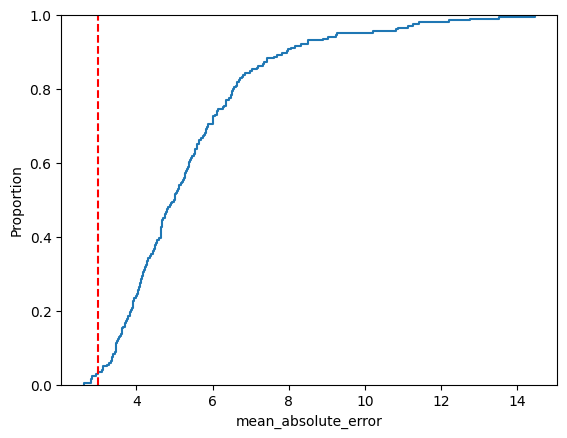

In [83]:
# visualizing the error distribution
sns.ecdfplot(x=metrics_results['mean_absolute_error'])
plt.axvline(3, color='red', linestyle='--')

<Axes: xlabel='mean_absolute_error', ylabel='Count'>

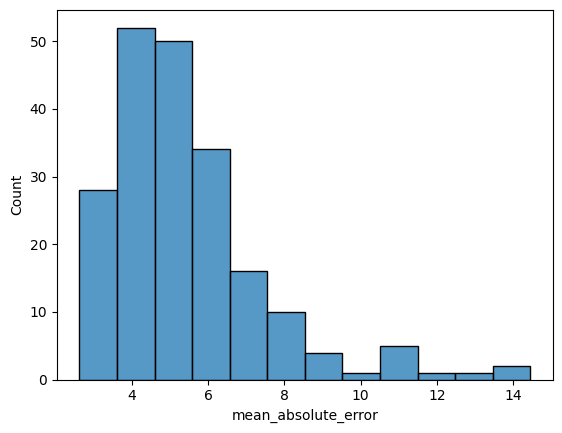

In [99]:
# histrogram plot for a more comprehensive analysis
sns.histplot(x=metrics_results['mean_absolute_error'], binwidth=1 )

In [64]:
results

{'15eavenue_laurier': (                     pred
  2024-08-29 15:15:00  11.0
  2024-08-29 15:30:00  13.0
  2024-08-29 15:45:00  12.0
  2024-08-29 16:00:00  10.0
  2024-08-29 16:15:00  10.0
  ...                   ...
  2025-02-24 02:30:00   2.0
  2025-02-24 02:45:00   2.0
  2025-02-24 03:00:00   2.0
  2025-02-24 03:15:00   3.0
  2025-02-24 03:30:00   3.0
  
  [17138 rows x 1 columns],
     mean_absolute_error
  0             5.536877)}

<Axes: xlabel='datetime', ylabel='15eavenue_laurier'>

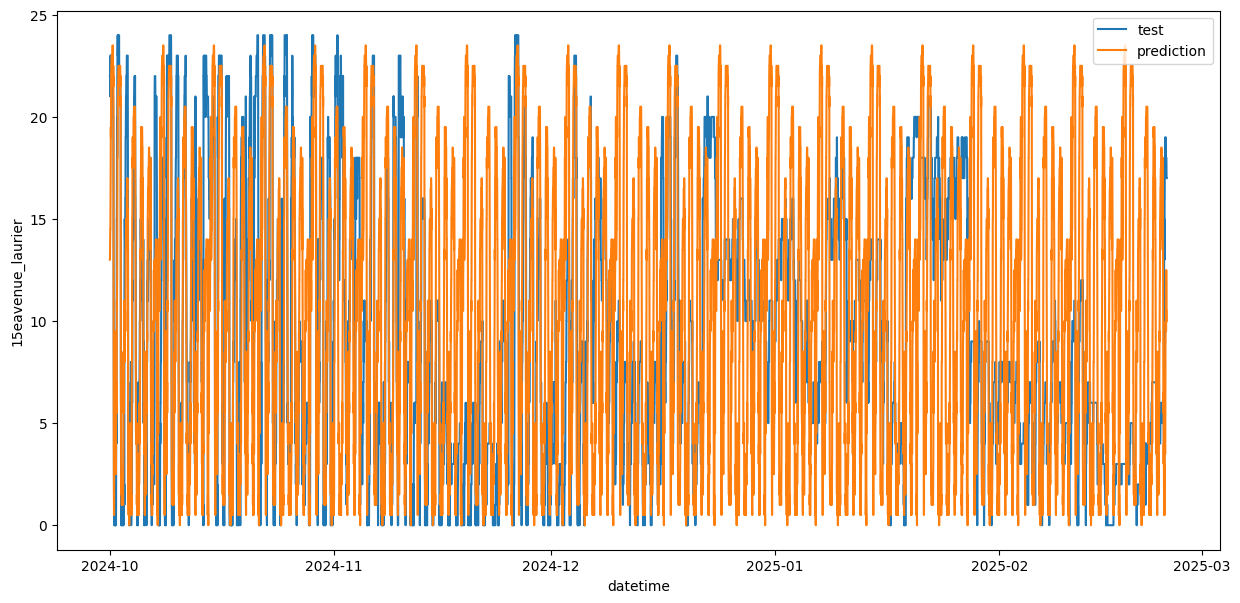

In [216]:
# plotting to visualize results
station = '15eavenue_laurier'
plt.figure(figsize=(15,7))
sns.lineplot(x=test.index, y=test[station], label='test')
sns.lineplot(x=predictions_df.index, y=predictions_df[station], label='prediction')

## Model

In [82]:
# transforming stations into a dictionary
operating_stations_dict = series_long_to_dict(
    data      = operating_stations,
    series_id = 'station',
    index     = 'datetime',
    values    = 'bikes',
    freq      = '15min'
)

# setting train and test datasets
end_train = '2024-12-31 23:45:00'
train = {k: v.loc[: end_train,] for k, v in operating_stations_dict.items()}
test  = {k: v.loc[end_train:,] for k, v in operating_stations_dict.items()}

# removing empty series
train.pop('hochelaga_dzry')

Series([], Freq: 15min, Name: hochelaga_dzry, dtype: uint8)

In [31]:
# pivoting dataframe to fit the global to fit
# the global multi-sries
global_time_series = operating_stations.pivot_table(
    values='bikes',
    columns='station',
    index='datetime'
)

global_time_series = global_time_series.asfreq('15T')

stations = operating_stations['station'].drop_duplicates().to_list()

/tmp/ipykernel_5667/3759195527.py:9: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  global_time_series = global_time_series.asfreq('15T')


In [43]:
end_training = '2024-12-31 23:45:00'
train = global_time_series[global_time_series.index < end_training]
test = global_time_series[global_time_series.index > end_training]

In [53]:
station_levels = {}
for item in global_time_series:
    station_levels[item] = global_time_series[item]

In [60]:
# creating the baseline forecast model for the same 
baseline_forecaster = ForecasterEquivalentDate(
                 offset    = DateOffset(days=7),
                 n_offsets = 1
)

# using the baseline for the global multiseries model
forecaster_ms = ForecasterRecursiveMultiSeries(
                    regressor          = baseline_forecaster,
                    lags = 16
                )


# Backtesting forecaster for all items
cv = TimeSeriesFold(
        steps              = 8,
        initial_train_size = len(train),
        refit              = False,
     )

multi_series_mae, predictions_ms = backtesting_forecaster_multiseries(
                                       forecaster            = forecaster_ms,
                                       series                = global_time_series,
                                       levels                = None,
                                       cv                    = cv,
                                       metric                = 'mean_absolute_error',
                                       add_aggregated_metric = False,
                                       verbose               = False,
                                       show_progress         = True  
                                   )  

TypeError: ForecasterEquivalentDate.fit() got an unexpected keyword argument 'X'

In [38]:
len(train)

2387302

In [112]:
baseline_df.reset_index('station')

,station,bikes,stands
datetime,,,
2024-08-22 15:00:00,15eavenue_laurier,13,11
2024-08-22 15:15:00,15eavenue_laurier,11,13
2024-08-22 15:30:00,15eavenue_laurier,13,11
2024-08-22 15:45:00,15eavenue_laurier,12,12
2024-08-22 16:00:00,15eavenue_laurier,10,14
...,...,...,...
2025-02-24 11:00:00,workman_vinet,9,14
2025-02-24 11:15:00,workman_vinet,9,14
2025-02-24 11:30:00,workman_vinet,9,14


In [92]:
baseline_df[baseline_df['station'] == "15eavenue_laurier"]['bikes'].index

DatetimeIndex(['2024-08-22 15:00:00', '2024-08-22 15:15:00',
               '2024-08-22 15:30:00', '2024-08-22 15:45:00',
               '2024-08-22 16:00:00', '2024-08-22 16:15:00',
               '2024-08-22 16:30:00', '2024-08-22 16:45:00',
               '2024-08-22 17:00:00', '2024-08-22 17:15:00',
               ...
               '2025-02-24 01:15:00', '2025-02-24 01:30:00',
               '2025-02-24 01:45:00', '2025-02-24 02:00:00',
               '2025-02-24 02:15:00', '2025-02-24 02:30:00',
               '2025-02-24 02:45:00', '2025-02-24 03:00:00',
               '2025-02-24 03:15:00', '2025-02-24 03:30:00'],
              dtype='datetime64[ns]', name='datetime', length=17811, freq=None)

In [89]:
baseline_df

,bikes,stands,station
datetime,,,
2024-08-22 15:00:00,13,11,15eavenue_laurier
2024-08-22 15:15:00,11,13,15eavenue_laurier
2024-08-22 15:30:00,13,11,15eavenue_laurier
2024-08-22 15:45:00,12,12,15eavenue_laurier
2024-08-22 16:00:00,10,14,15eavenue_laurier
...,...,...,...
2025-02-24 11:00:00,9,14,workman_vinet
2025-02-24 11:15:00,9,14,workman_vinet
2025-02-24 11:30:00,9,14,workman_vinet
